In [16]:
import sys
sys.path.append('../Quality/')

import pickle
import numpy as np
from tqdm import tqdm
from skimage import io
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Quality import compute_overlap_array
from skimage.filters import threshold_otsu
from scipy.ndimage.filters import convolve
from scipy.stats import gaussian_kde as kde
from numpy.lib.stride_tricks import as_strided
from skimage.measure import label

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [2]:
NOMADS_out = io.imread(open('results.tiff', 'rb'))
print(NOMADS_out.shape)

(20, 125, 175)


In [3]:
data = pickle.load(open('downsample_collman15.pkl', 'rb'))
print(data.keys())
annot = np.stack(data['annotation'])
print(annot.shape)

dict_keys(['GS594', 'GABA488', 'NR1594', 'GAD647', 'annotation', 'MBP488', 'PSD95_488', 'gephyrin594', 'Synapsin647', 'VGluT1_647'])
(20, 125, 175)


In [4]:
#first thing is first... let's get a volume of only the synapses that NOMADS misses
fn_pseudo_labels = []
for pseudo_label in tqdm(np.unique(annot)):
    current_synapse = np.array(annot == pseudo_label).astype(int)
    overlap = np.multiply(current_synapse, NOMADS_out)
    if np.count_nonzero(overlap) == 0:
        fn_pseudo_labels.append(pseudo_label)

100%|██████████| 178/178 [00:00<00:00, 591.39it/s]


In [5]:
fn_annot = np.isin(annot, fn_pseudo_labels)

In [6]:
fn_centroids = []
for fn_pseudo_label in fn_pseudo_labels:
    expressions = np.where(annot == fn_pseudo_label)
    centroid = [int(np.mean(expressions[0])),
                int(np.mean(expressions[1])),
                int(np.mean(expressions[2]))]
    fn_centroids.append(centroid)

In [7]:
trace = go.Scatter3d(
    z = [elem[0] for elem in fn_centroids],
    y = [elem[1] for elem in fn_centroids],
    x = [elem[2] for elem in fn_centroids],
    mode = 'markers',
    marker = dict(
        size=5,
        color=100,
        opacity = .7
    )
)
scatter_data = [trace]
layout = go.Layout(margin=dict(l=0, r=0, t=0, b=0))
fig = go.Figure(data=scatter_data, layout=layout)
iplot(fig)

From this visualization, we can see that the missed synapses are about evenly spaced throughout the volume. This means that there is unlikely a large improvement from doing something like discounting the top or bottom slice.

The next thing to look at is the biomarker expression as a function of distance form the fn_centroids

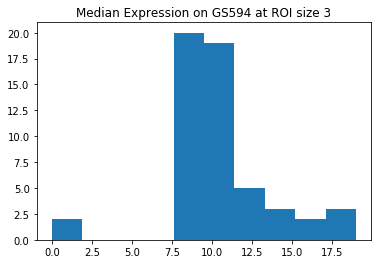

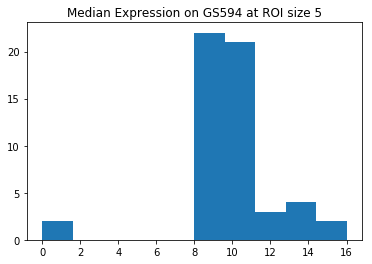

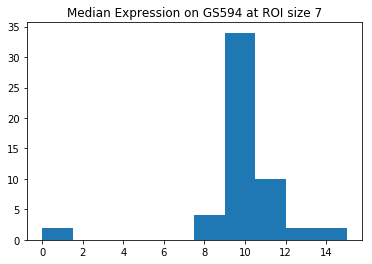

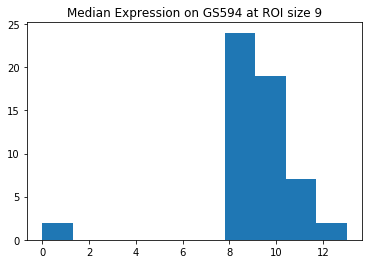

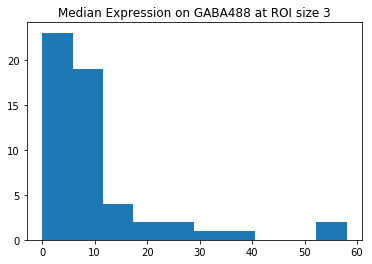

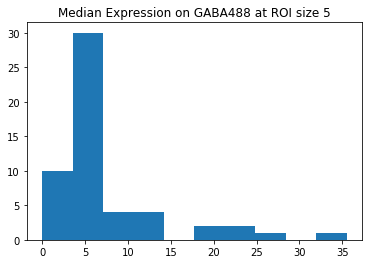

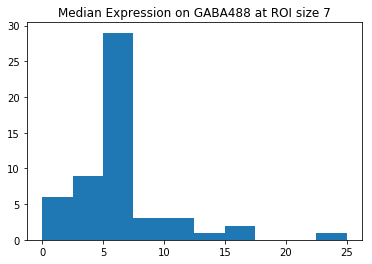

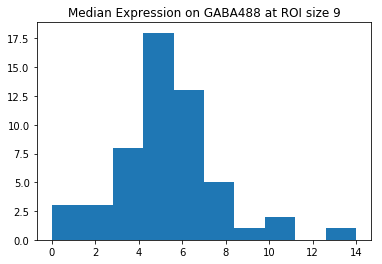

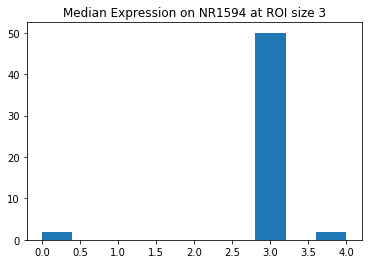

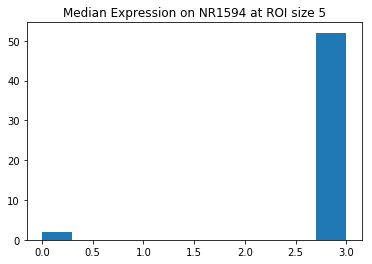

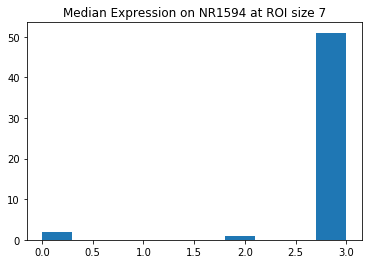

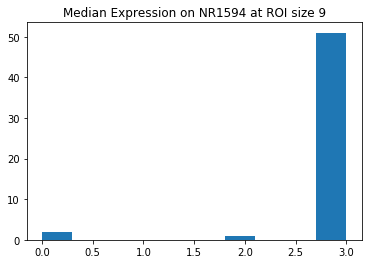

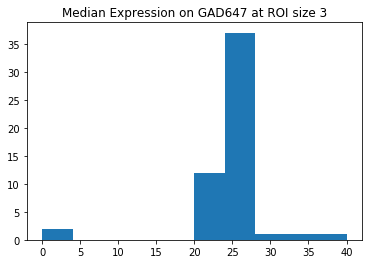

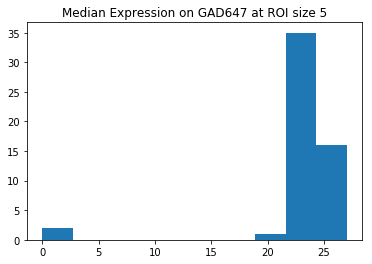

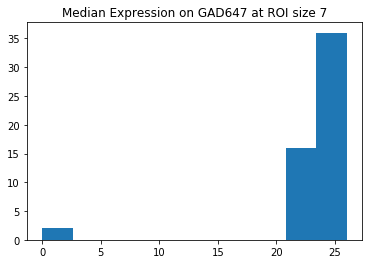

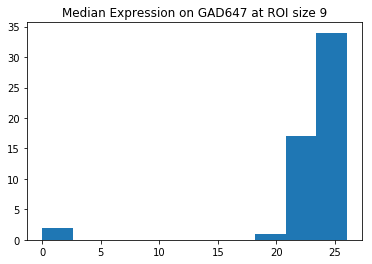

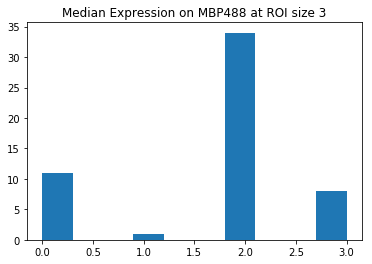

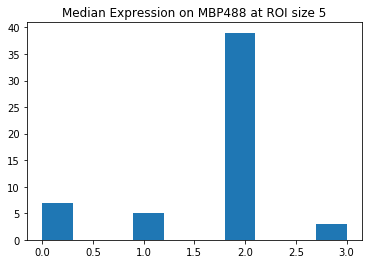

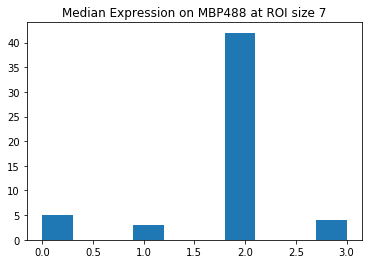

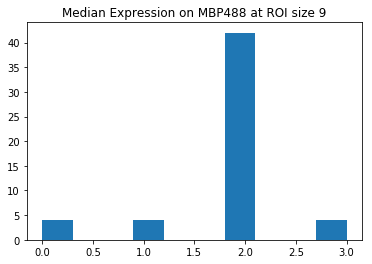

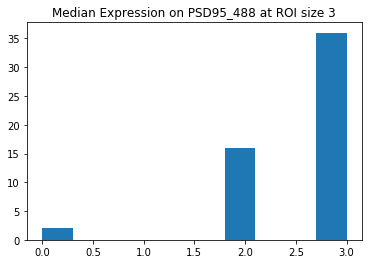

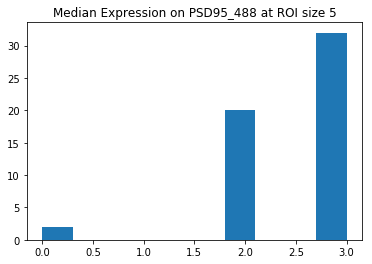

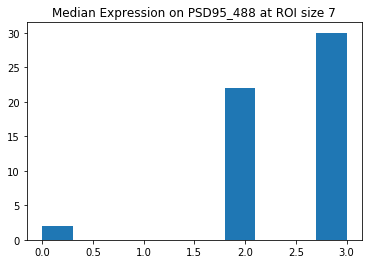

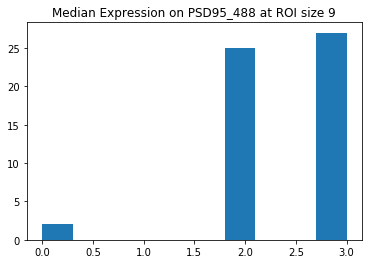

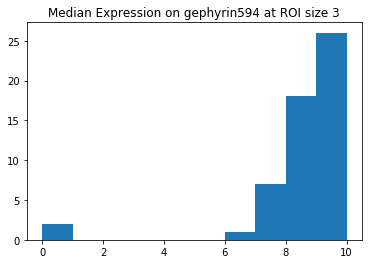

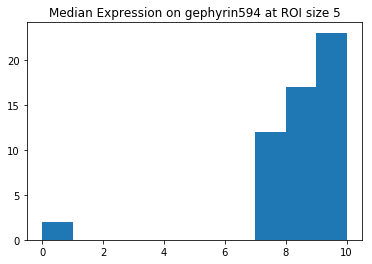

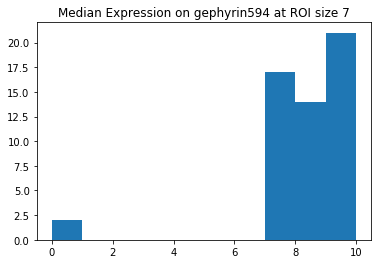

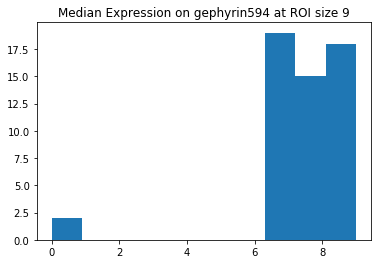

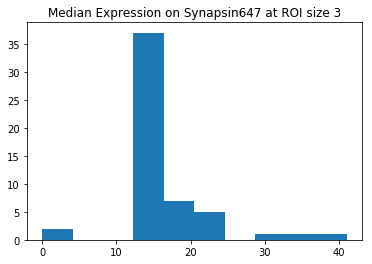

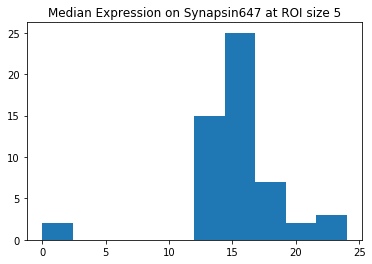

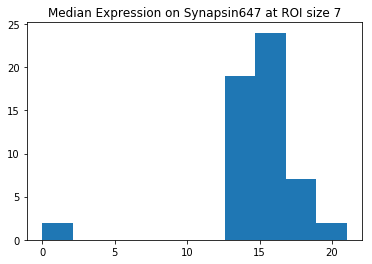

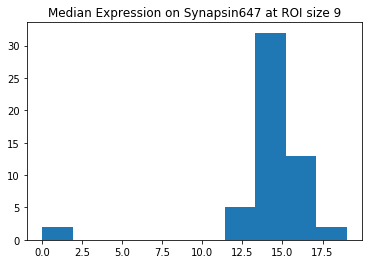

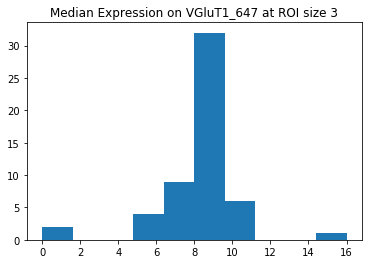

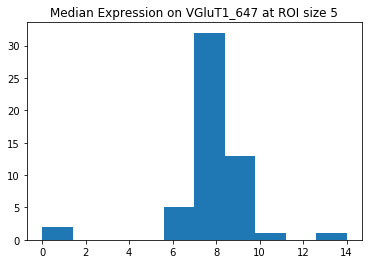

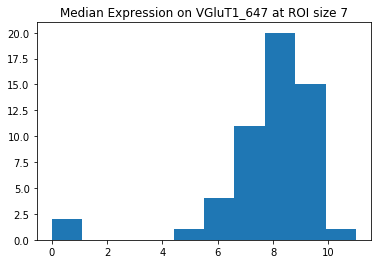

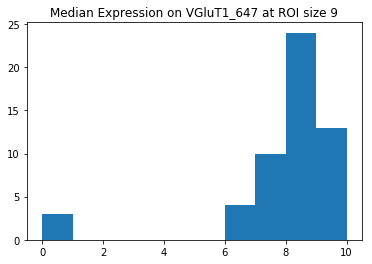

In [8]:
for key in data.keys():
    if not 'annot' in key:
        biomarker_volume = np.stack(data[key])
        z_size = 3
        for xy_size in range(3, 10, 2):
            cur_size_dist = []
            for centroid in fn_centroids:
                roi = biomarker_volume[max(centroid[0] - z_size,0):min(centroid[0] + z_size, biomarker_volume.shape[0]-1),
                                       max(centroid[1] - xy_size,0):min(centroid[1] + xy_size, biomarker_volume.shape[1]-1),
                                       max(centroid[2] - xy_size,0):min(centroid[2] + xy_size, biomarker_volume.shape[2]-1)]
                
                cur_size_dist.append(np.median(roi))

            plt.figure()
            plt.title('Median Expression on ' + str(key) + ' at ROI size ' + str(xy_size))
            plt.hist([elem for elem in cur_size_dist if not elem is None])
            plt.show()

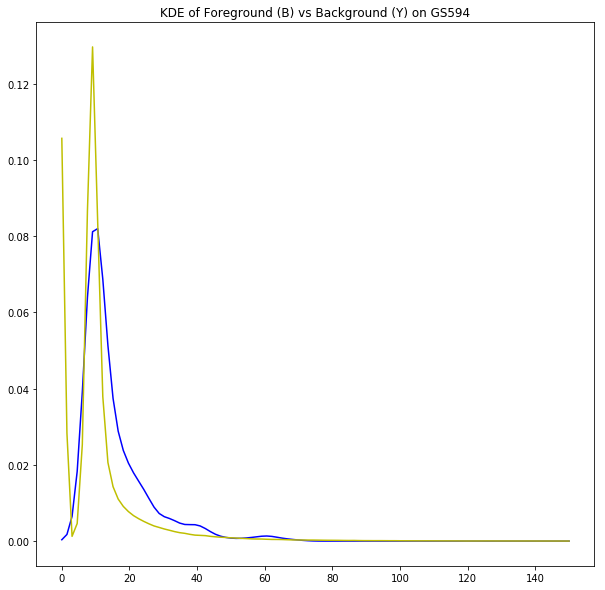

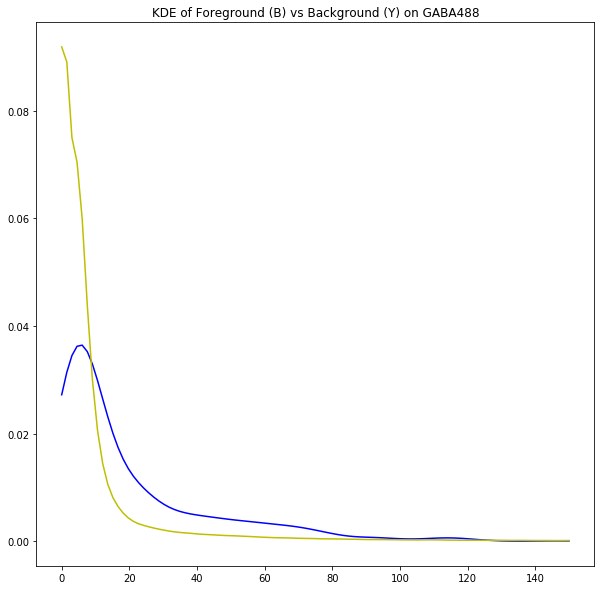

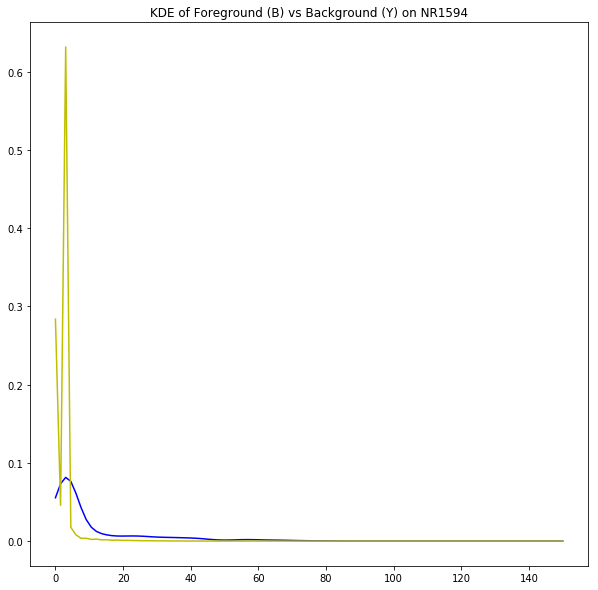

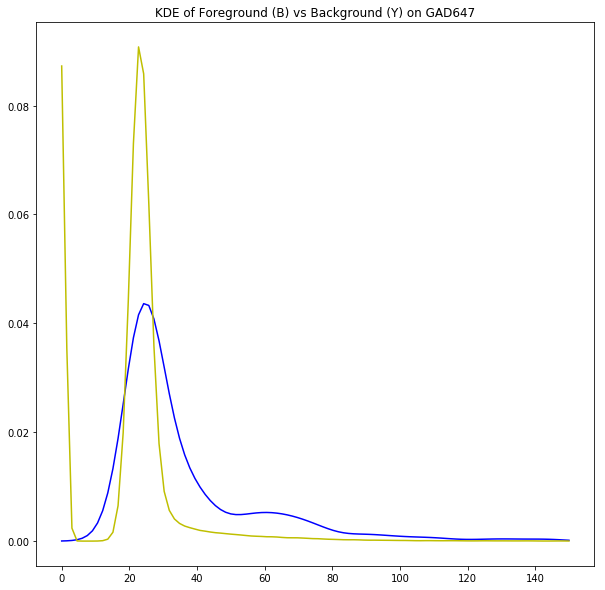

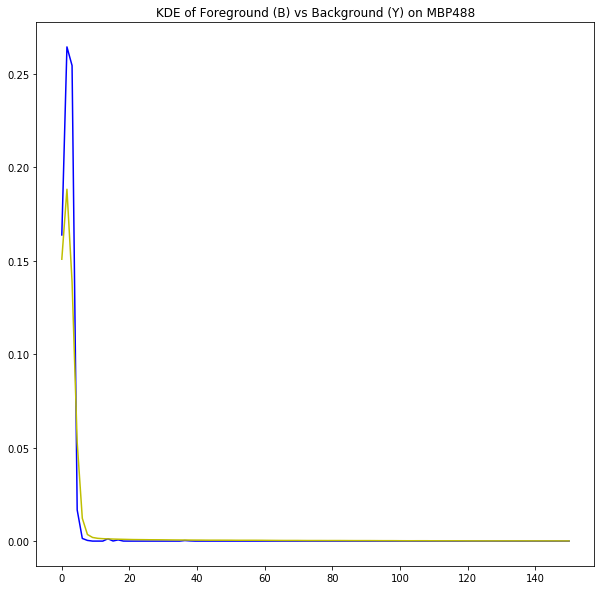

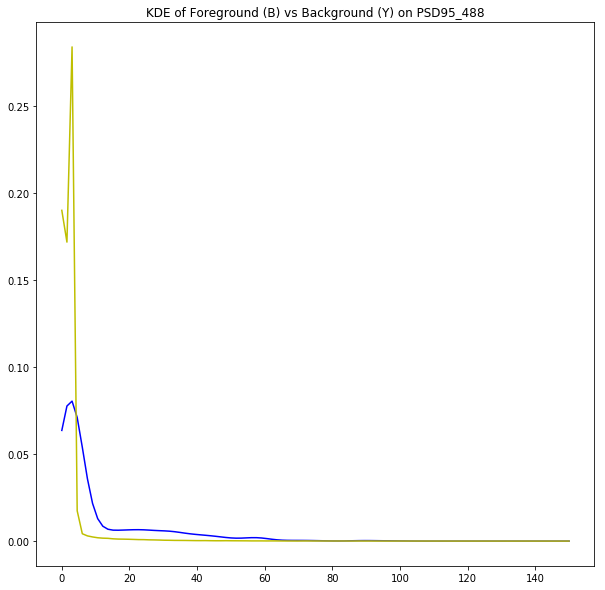

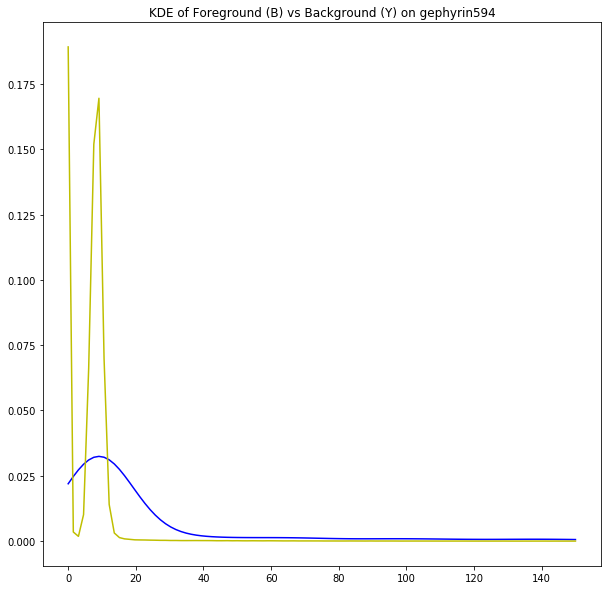

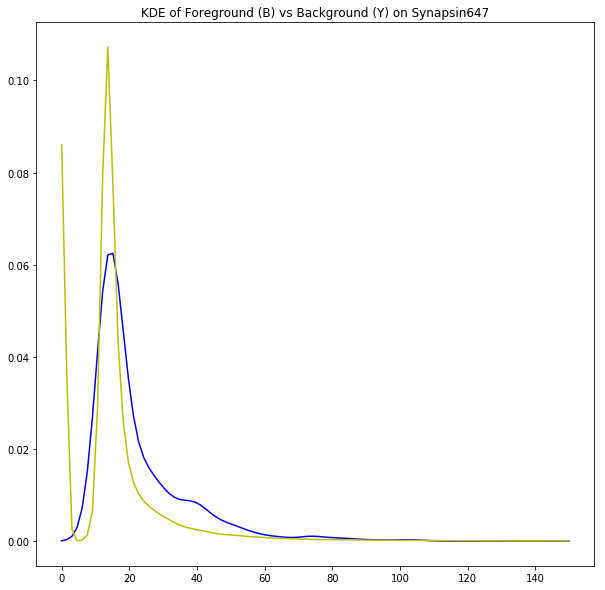

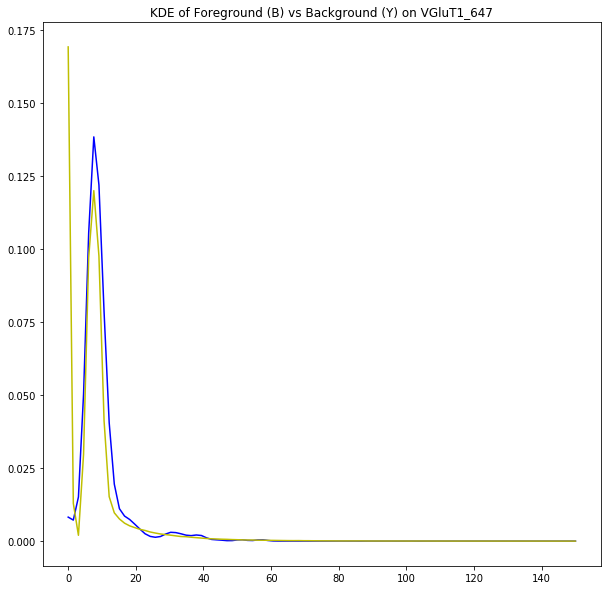

In [9]:
for key in data.keys():
    if not 'annot' in key:
        biomarker_volume = np.stack(data[key])
        fn_pop = biomarker_volume[np.where(fn_annot != 0)]
        fn_density = kde(fn_pop)
        
        background_pop = biomarker_volume[np.where(annot == 0)]
        background_density = kde(background_pop)
        
        xs = np.linspace(0, 150, 100)
        
        plt.figure(figsize=(10, 10))
        plt.title('KDE of Foreground (B) vs Background (Y) on ' + str(key))
        plt.plot(xs, fn_density(xs), c='b')
        plt.plot(xs, background_density(xs), c='y')
        plt.show()
        

In [10]:
def compute_convolutional_cov(vol1, vol2, kernel_shape):
    mu_kernel = np.ones(kernel_shape)/float(np.sum(np.ones(kernel_shape)))
    e1 = convolve(vol1, mu_kernel)
    e2 = convolve(vol2, mu_kernel)

    e12 = convolve(np.log(np.exp(vol1)+np.exp(vol2)), mu_kernel)

    cov = e12 - np.log(np.exp(e1) + np.exp(e2))

    return cov

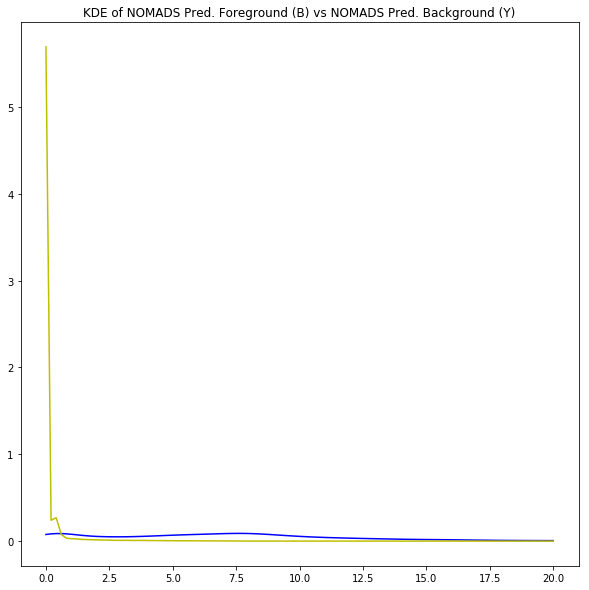

In [11]:
b_vol_1 = np.stack(data['PSD95_488']).astype(float)
b_vol_2 = np.stack(data['Synapsin647']).astype(float)
cov_vol = compute_convolutional_cov(b_vol_1,
                                    b_vol_2,
                                    (3, 3, 3))

pred_pop = cov_vol[np.where(NOMADS_out != 0)]
foreground_density = kde(pred_pop)


background_pop = cov_vol[np.where(NOMADS_out == 0)]
background_density = kde(background_pop)

xs = np.linspace(0, 20, 100)

plt.figure(figsize=(10, 10))
plt.title('KDE of NOMADS Pred. Foreground (B) vs NOMADS Pred. Background (Y)')
plt.plot(xs, foreground_density(xs), c='b')
plt.plot(xs, background_density(xs), c='y')
plt.show()

The above KDE shows the distribution between foreground and background that allowed the otsu threshold to perform well. I believe that, if I can find another covariance with this same distribution with respect to foreground and background defined via the missed synapses, that I can simply run the same binarization and append the results to the output.

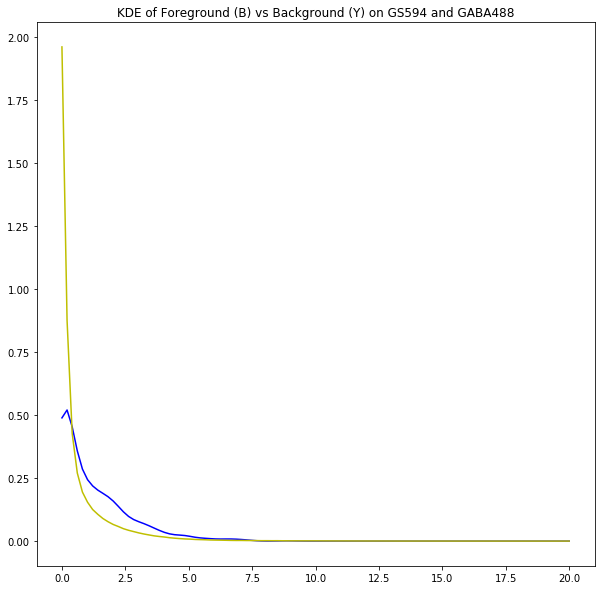

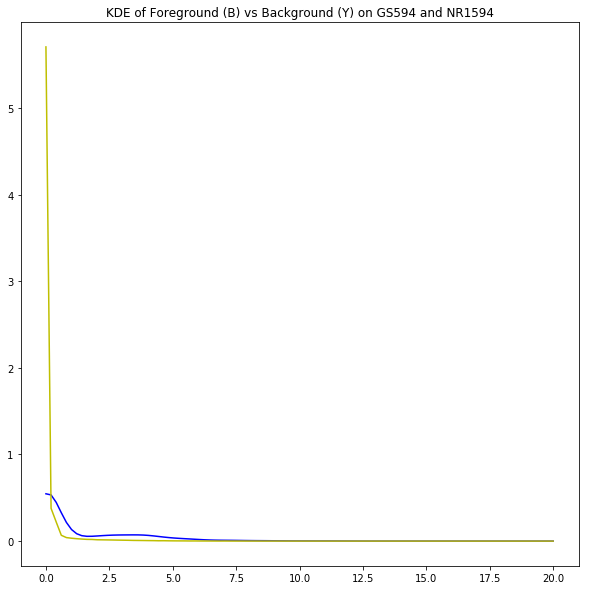

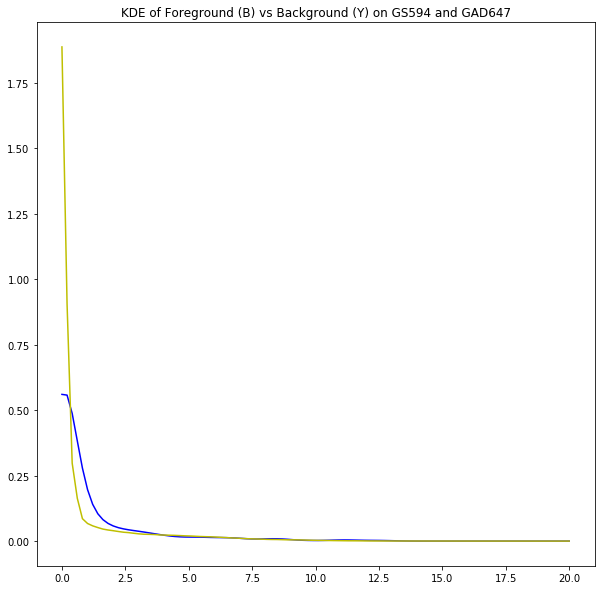

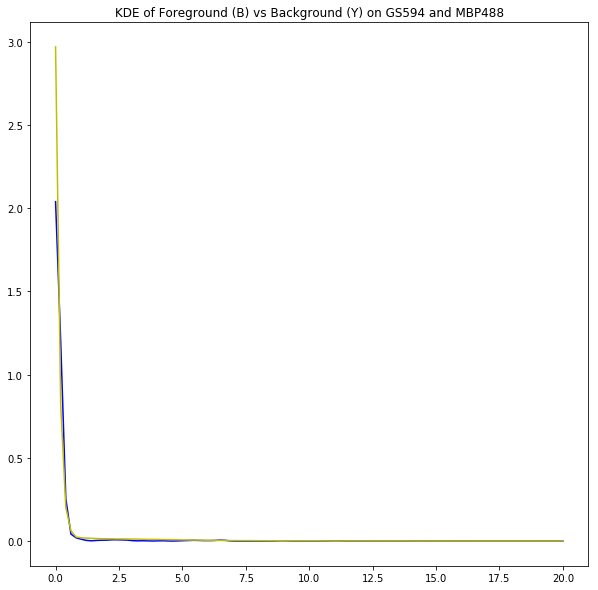

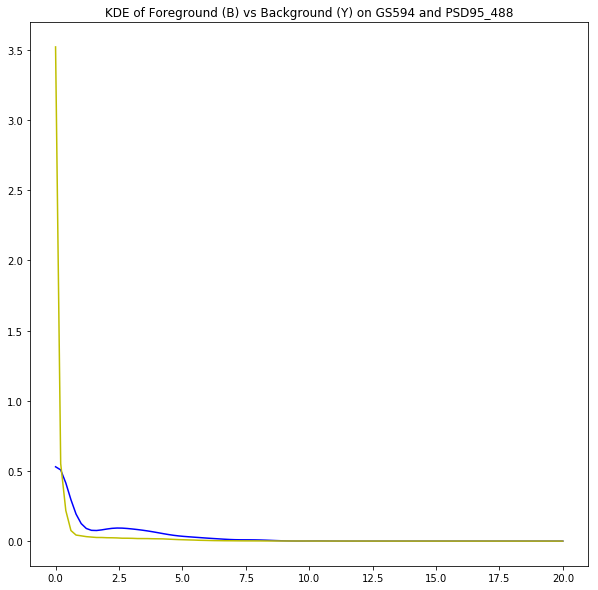

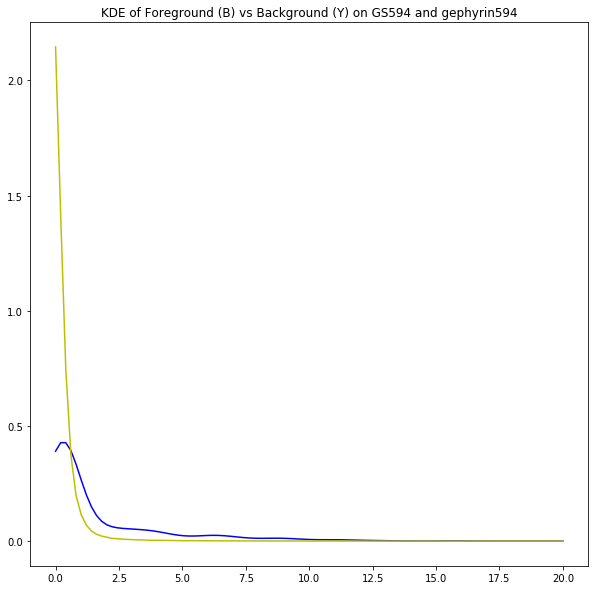

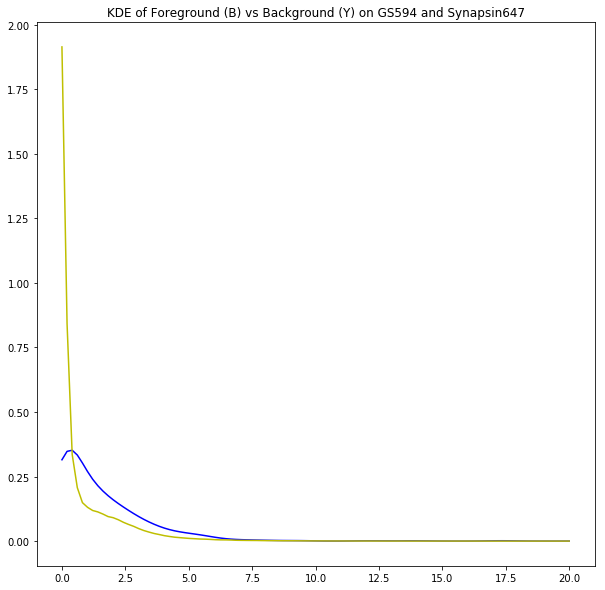

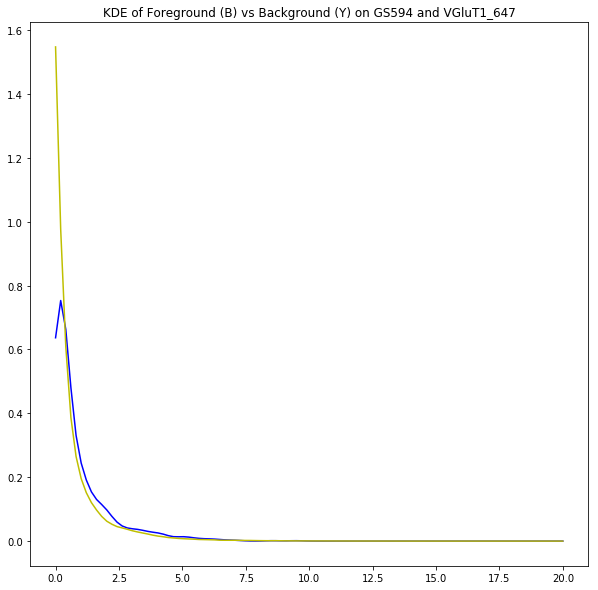

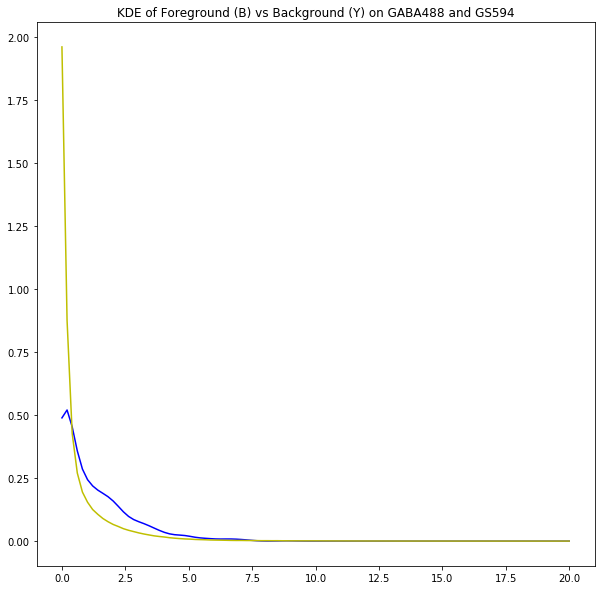

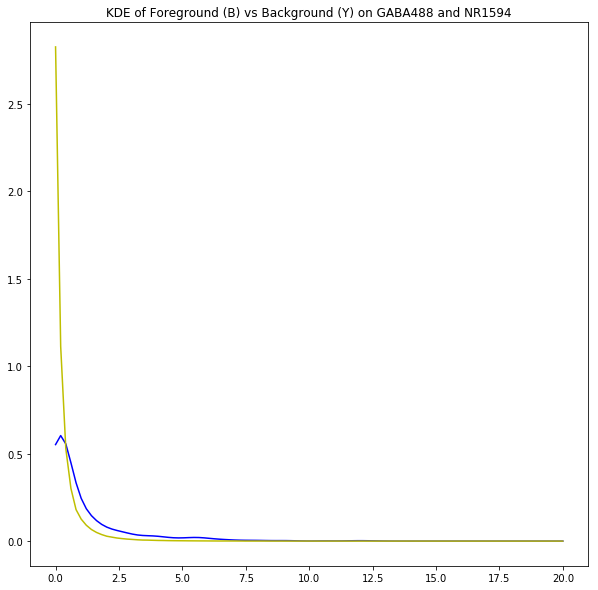

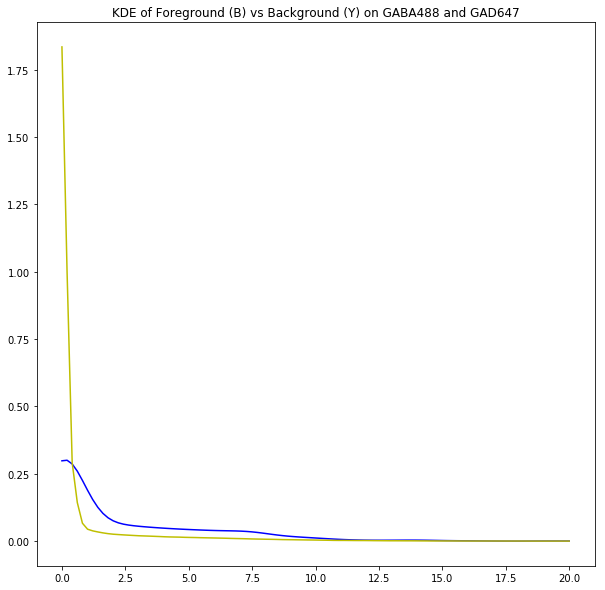

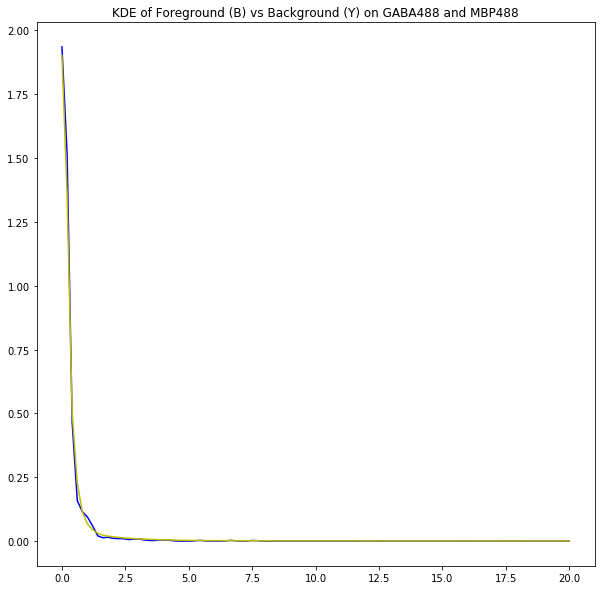

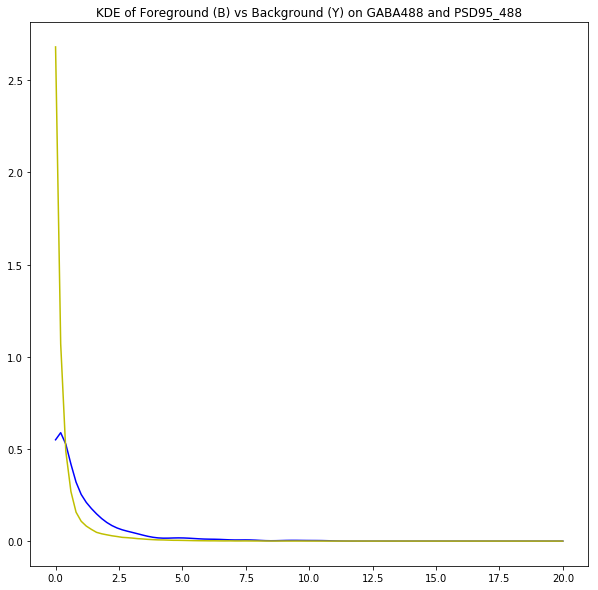

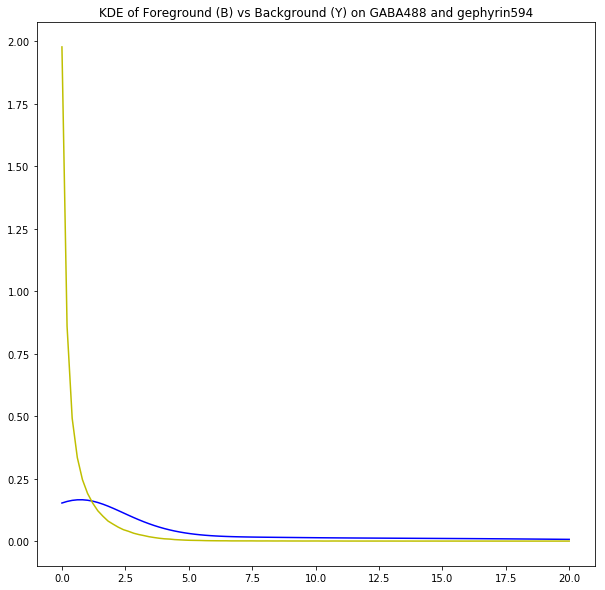

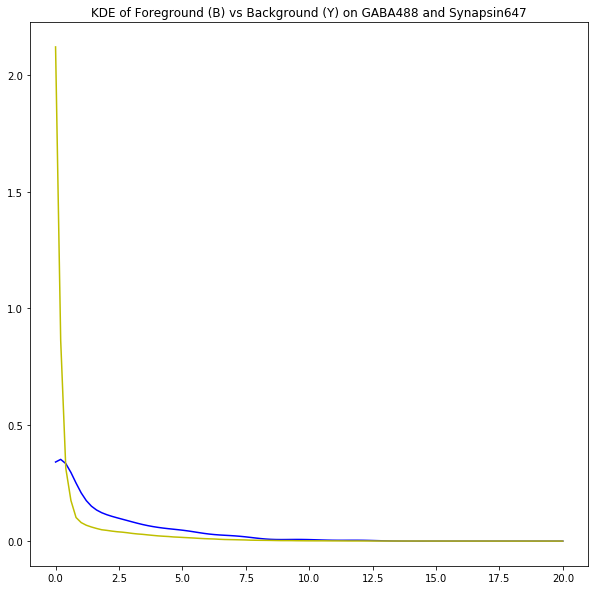

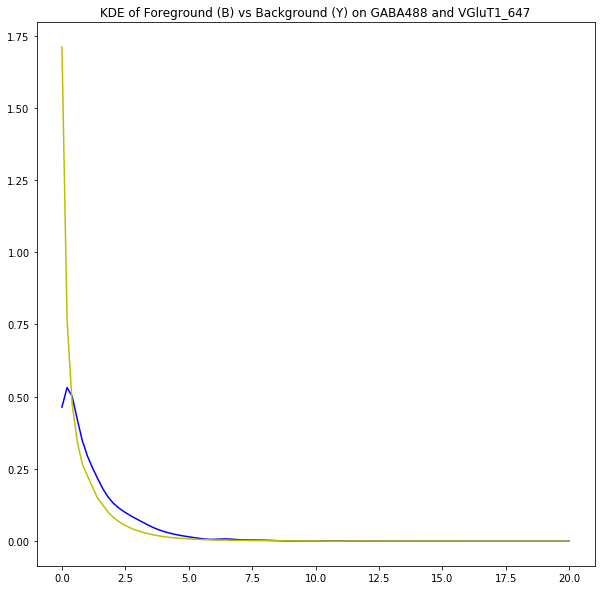

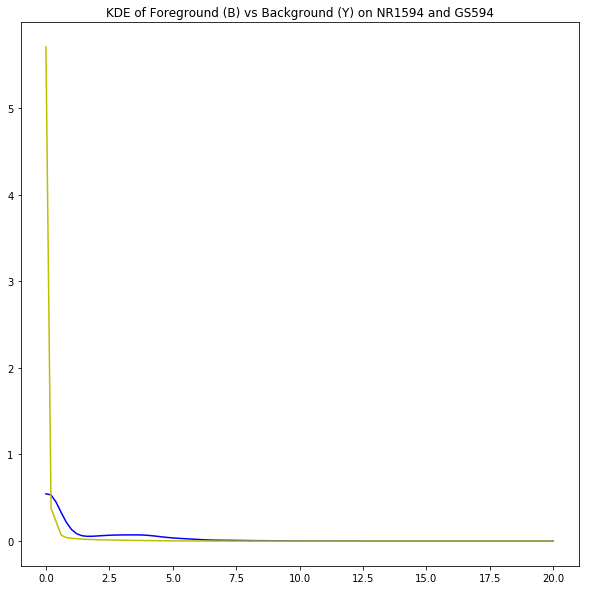

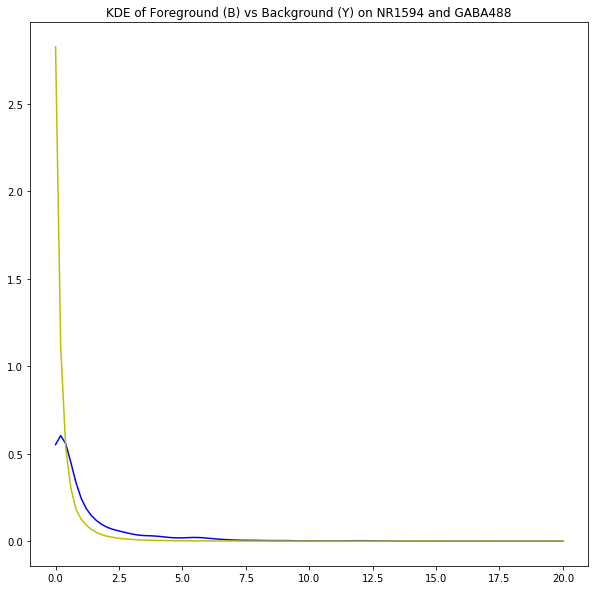

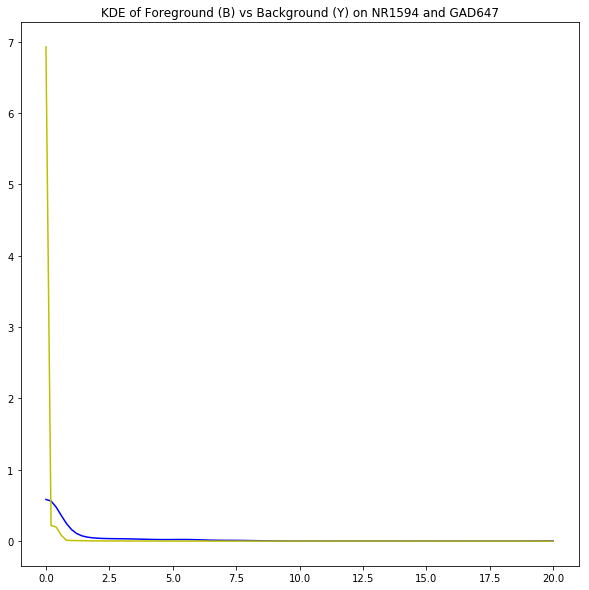

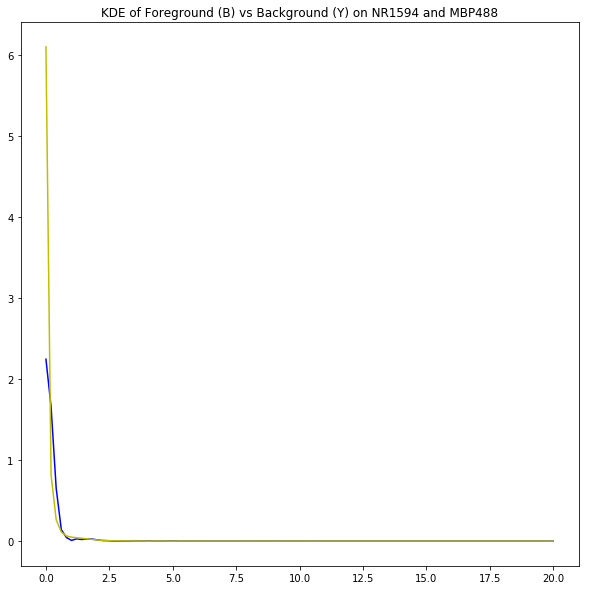

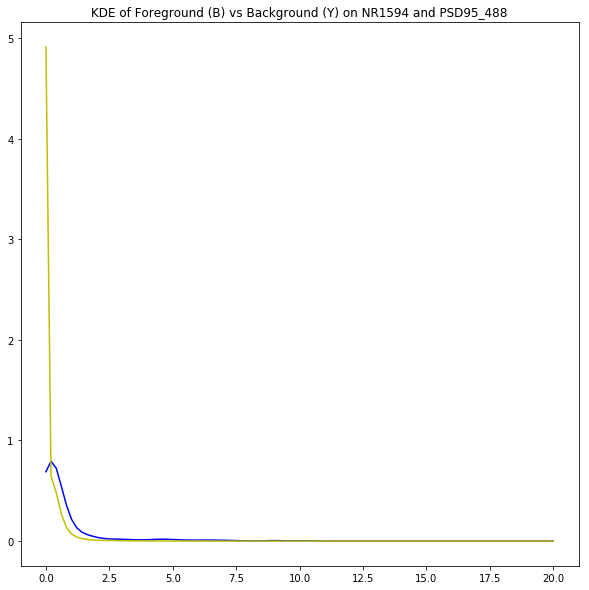

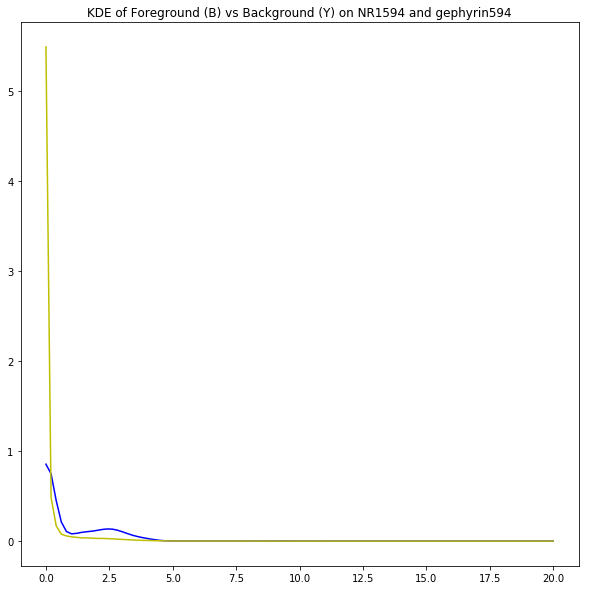

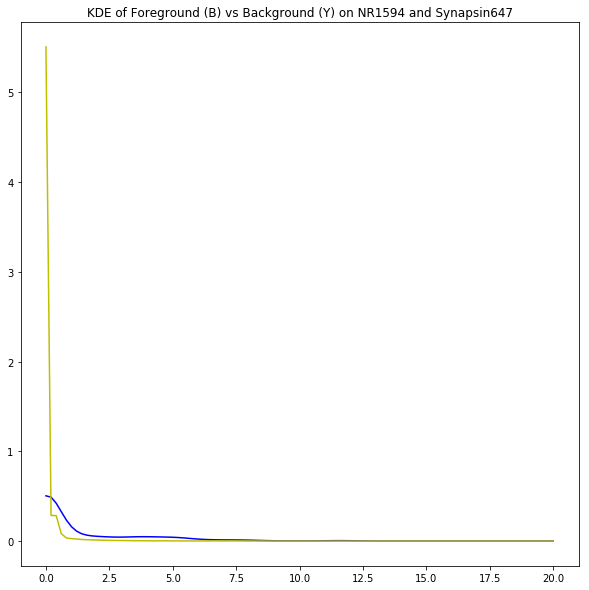

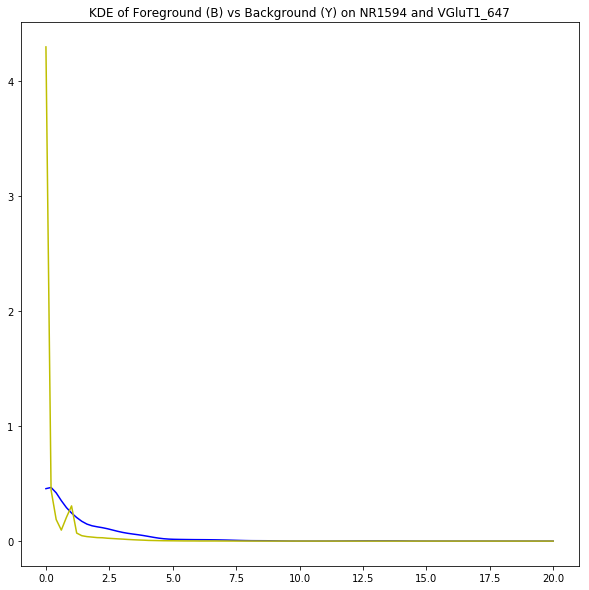

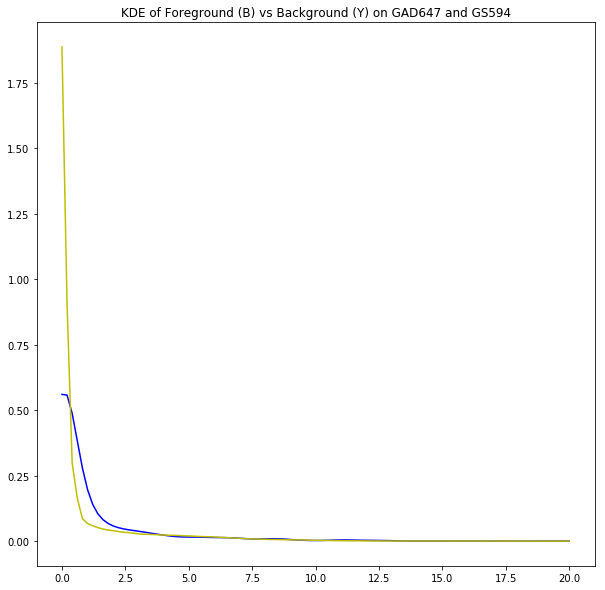

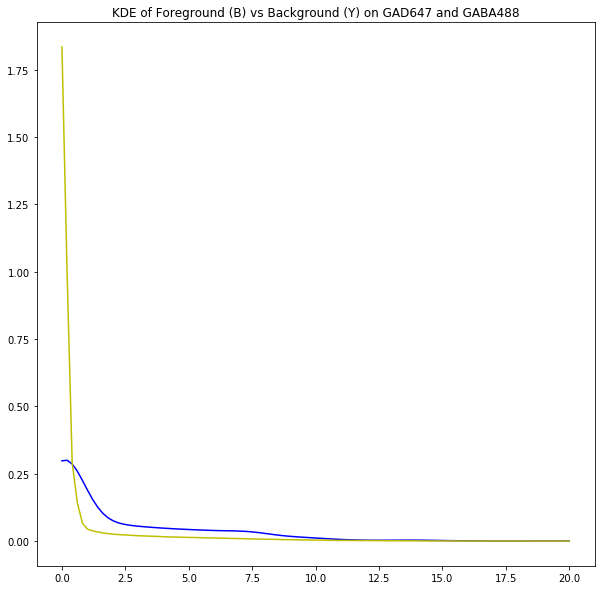

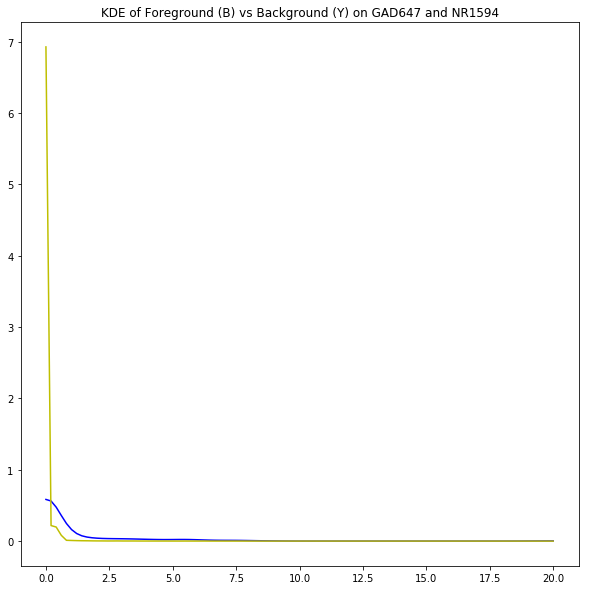

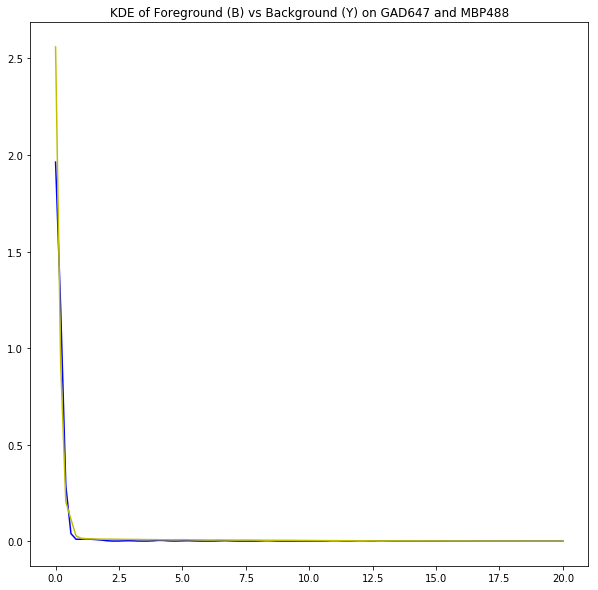

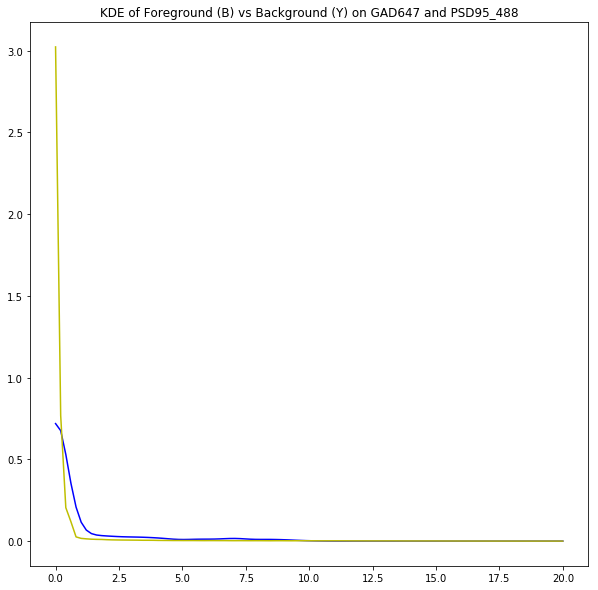

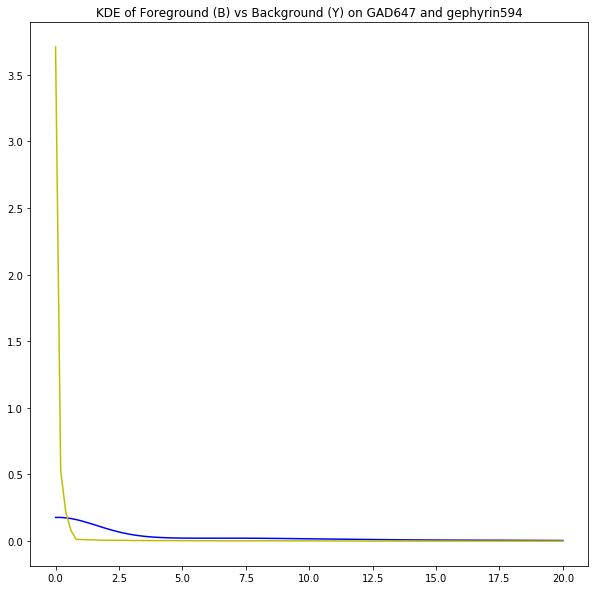

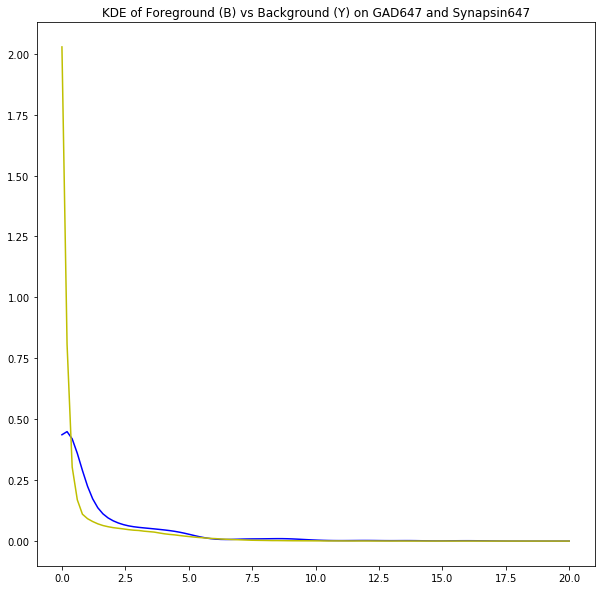

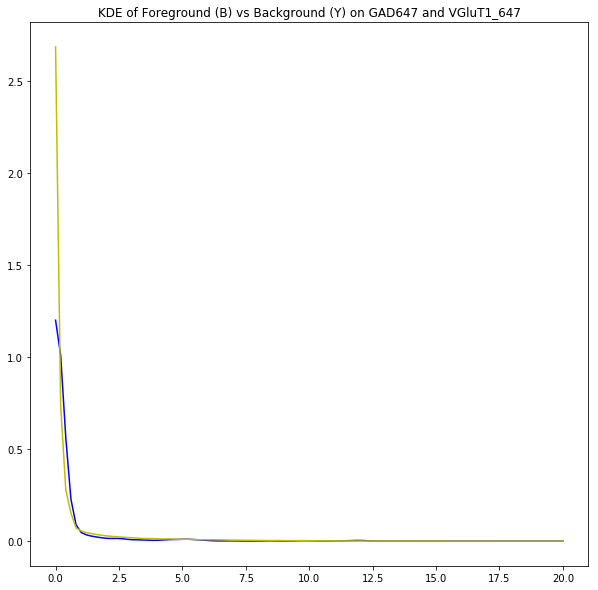

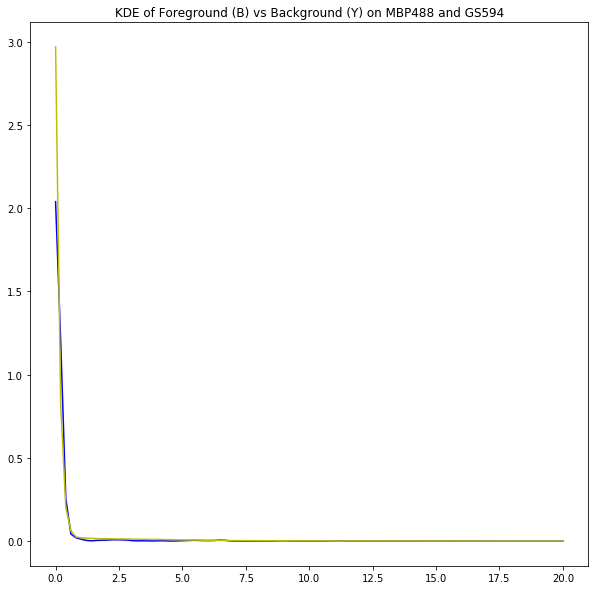

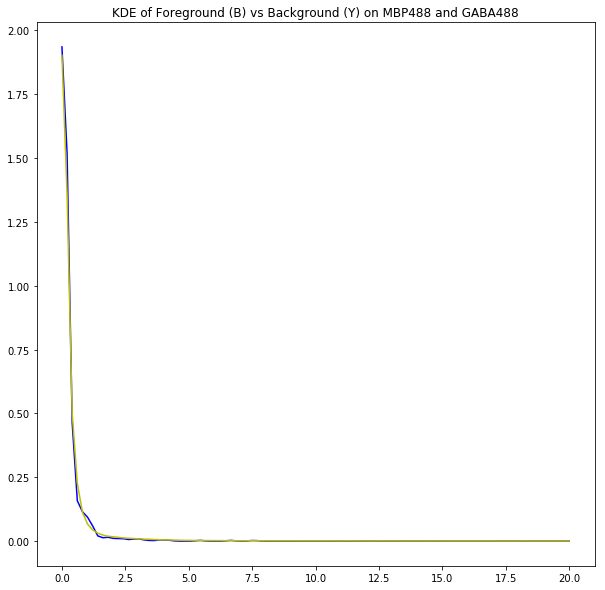

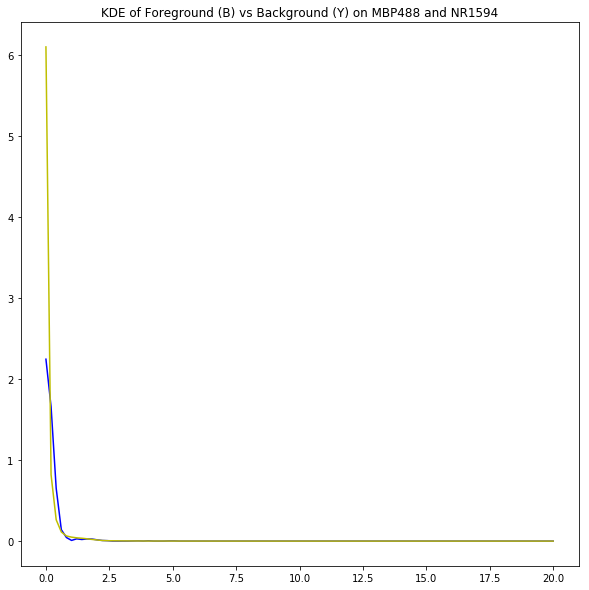

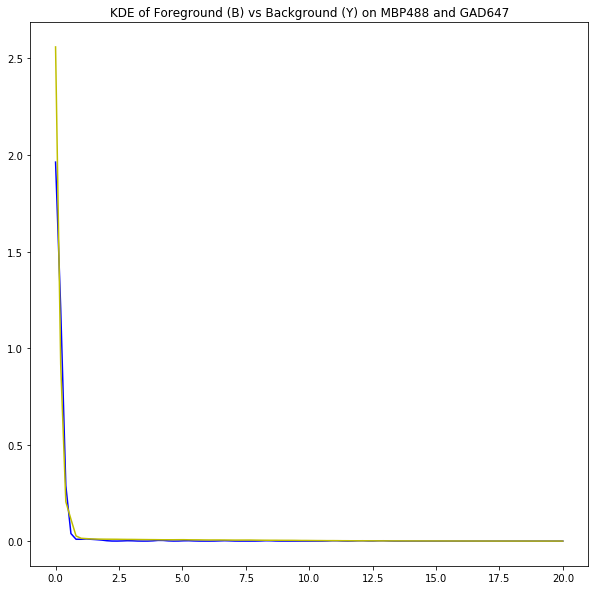

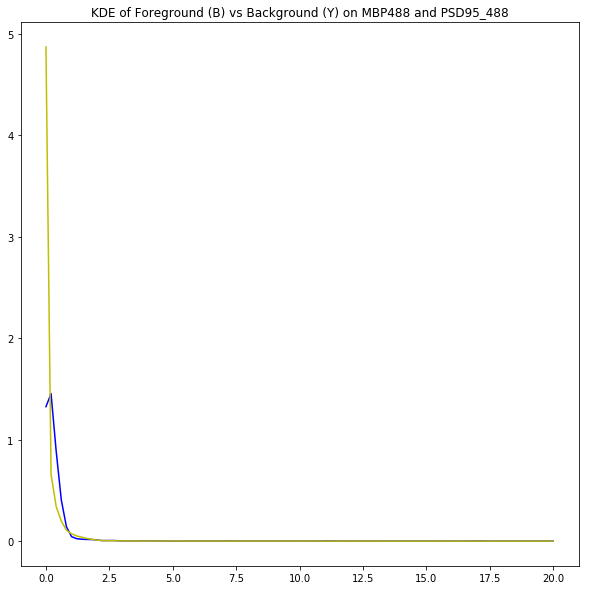

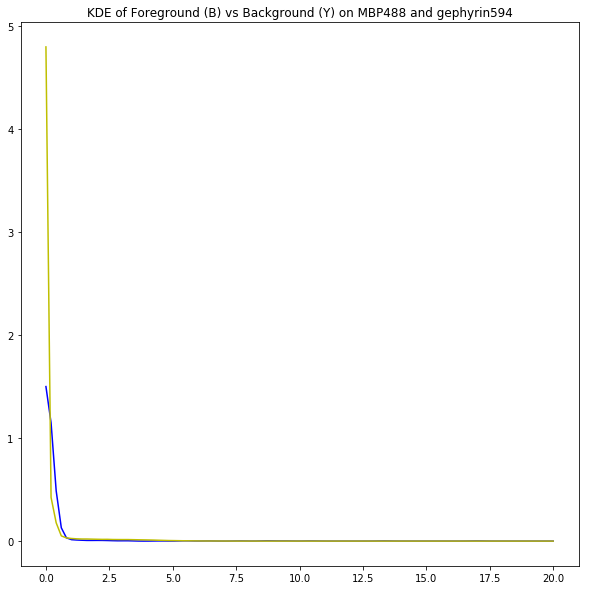

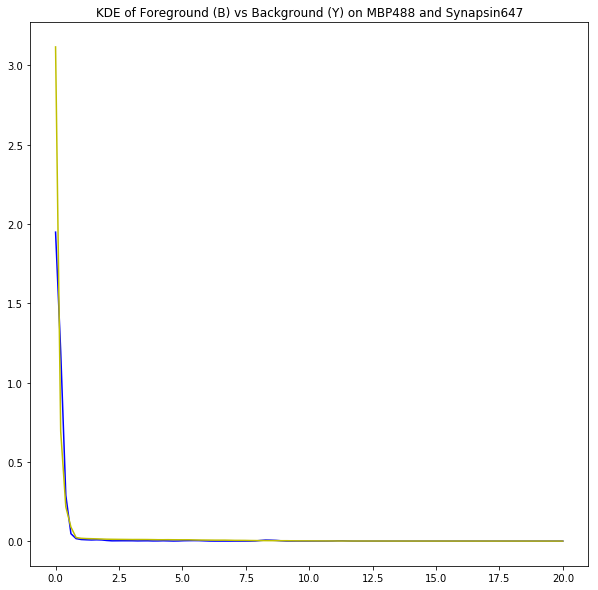

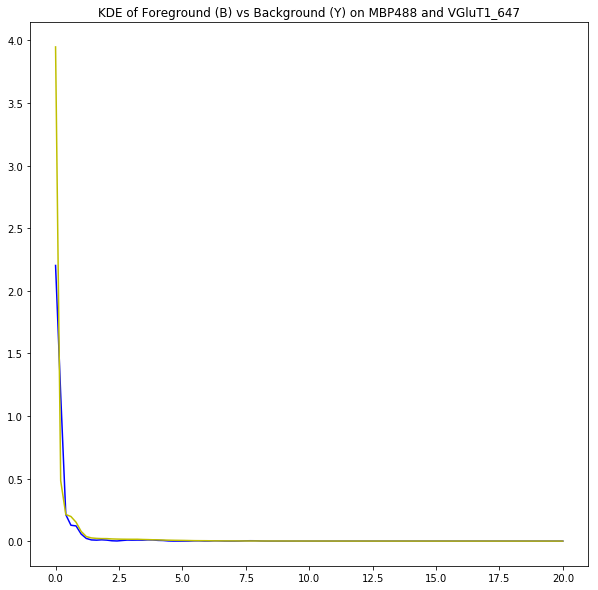

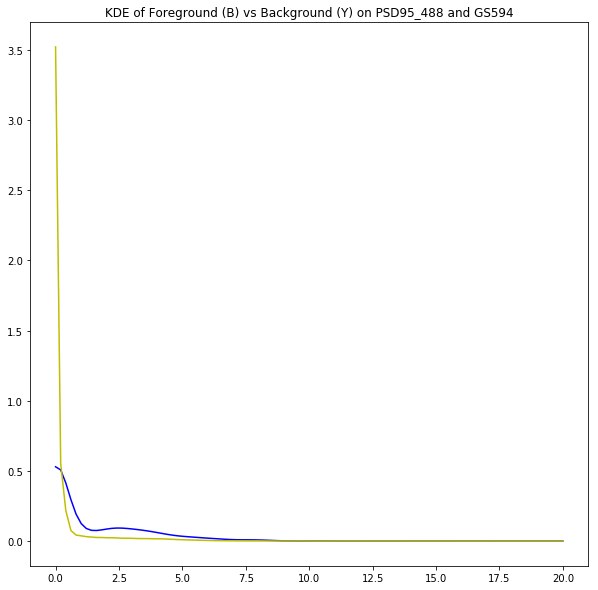

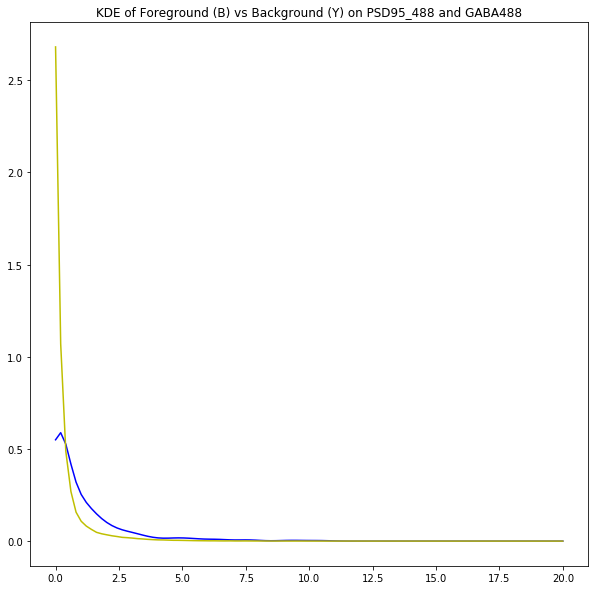

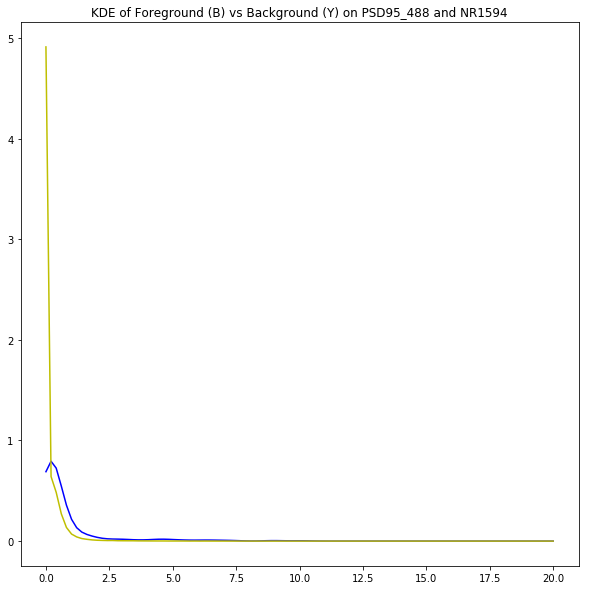

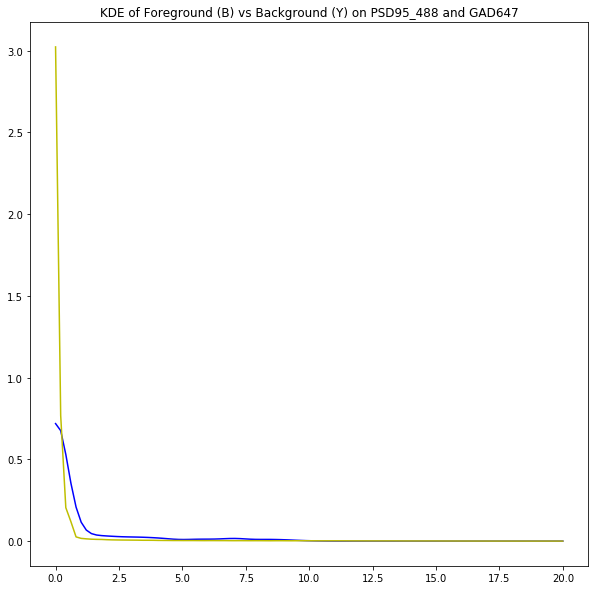

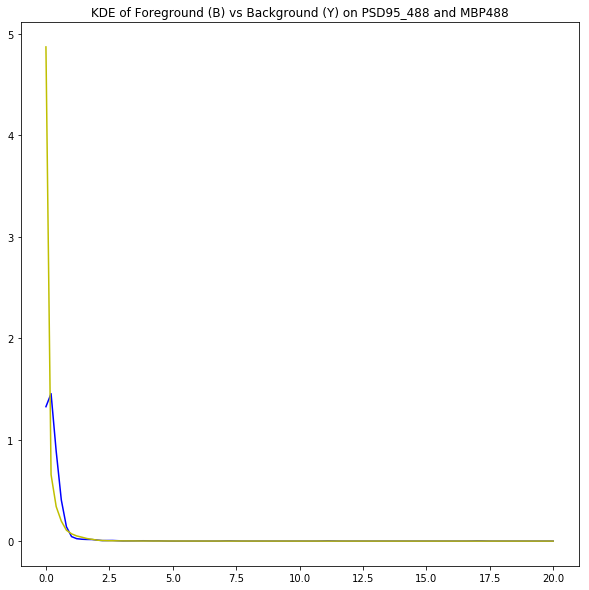

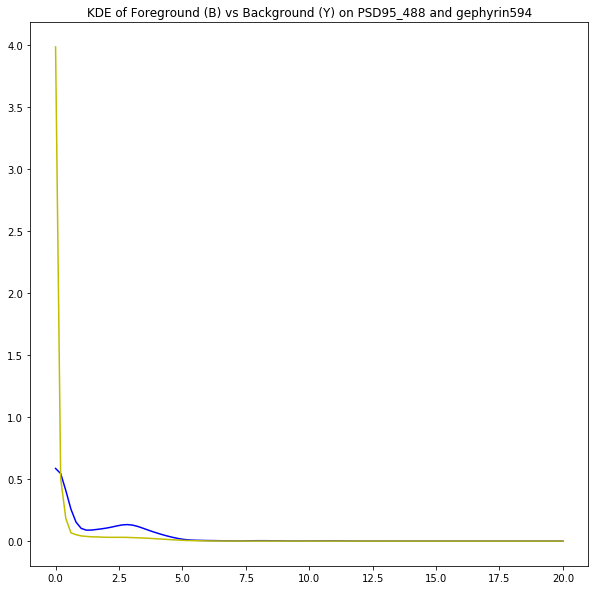

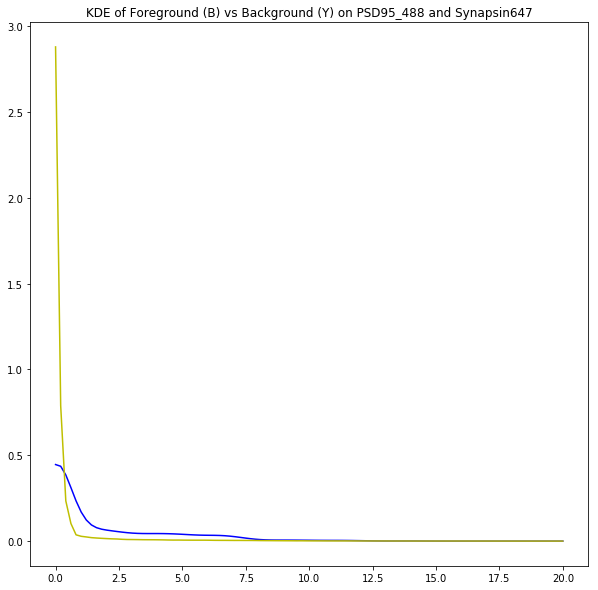

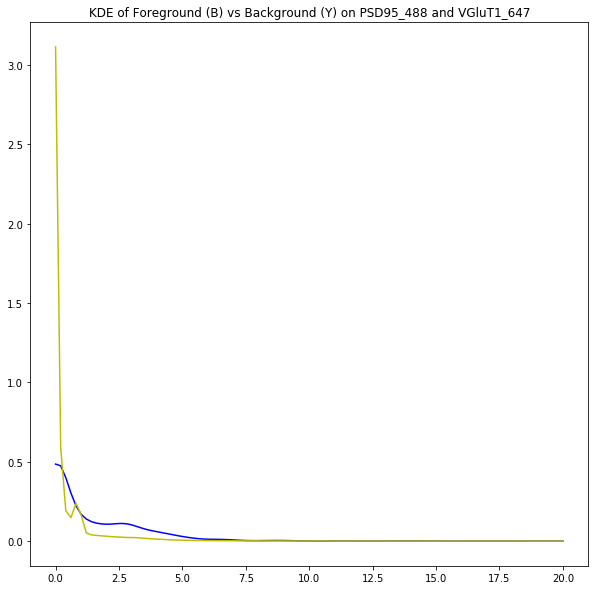

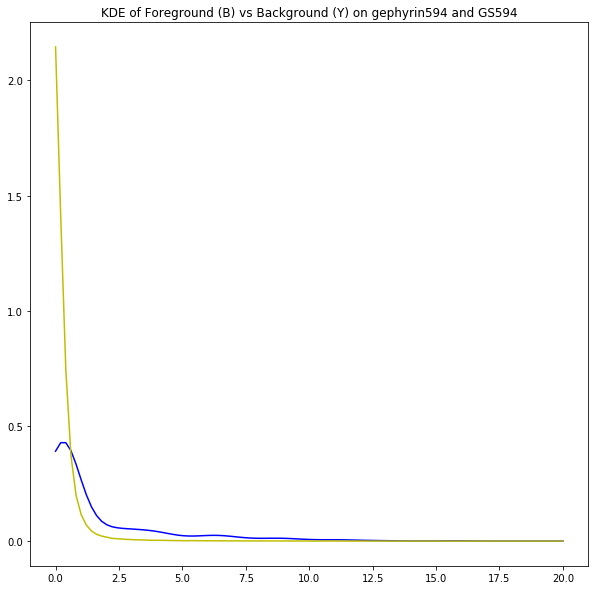

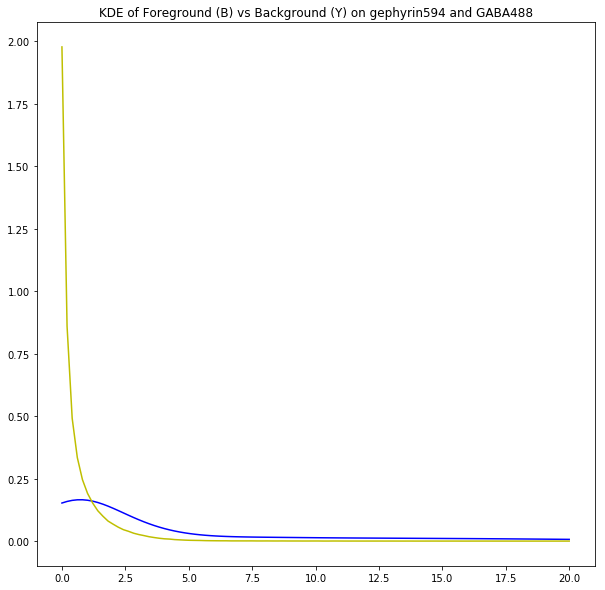

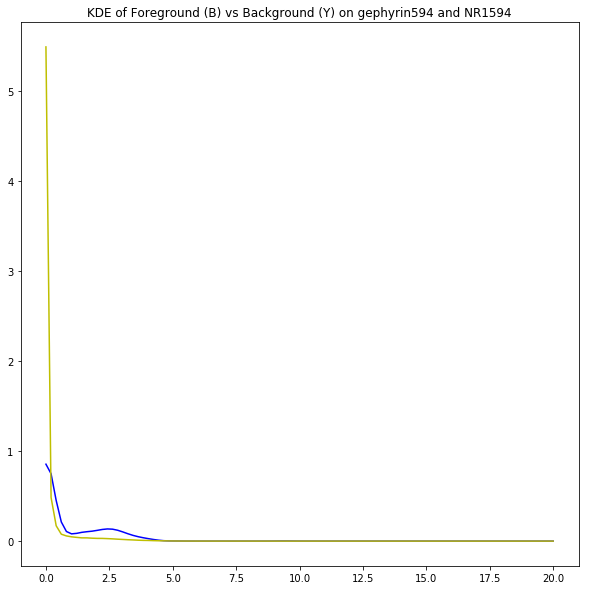

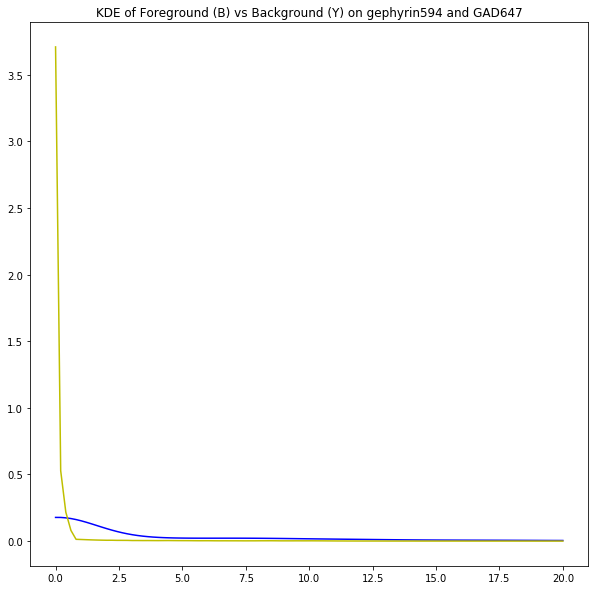

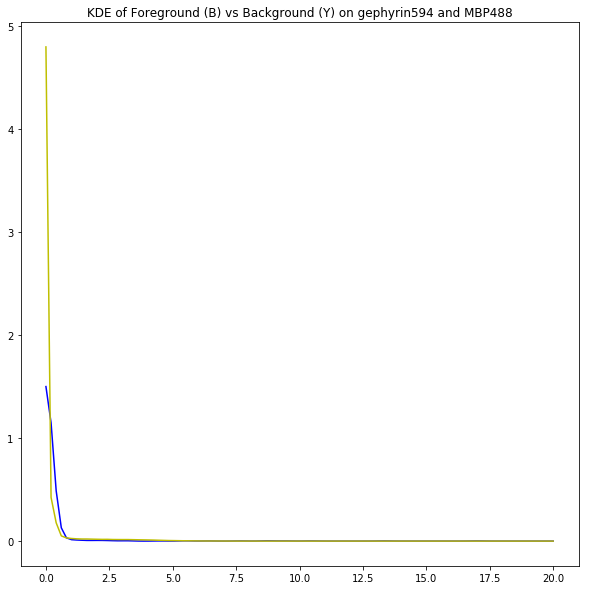

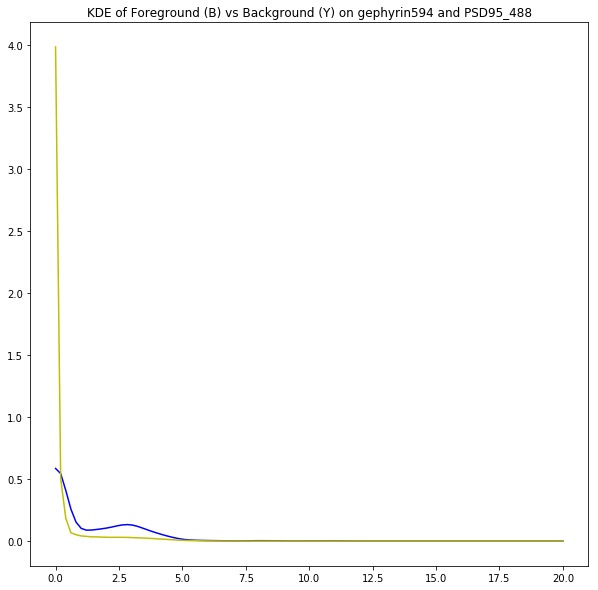

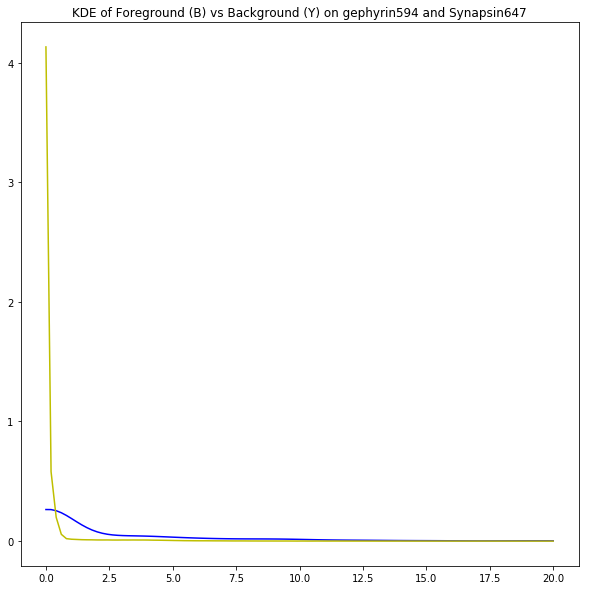

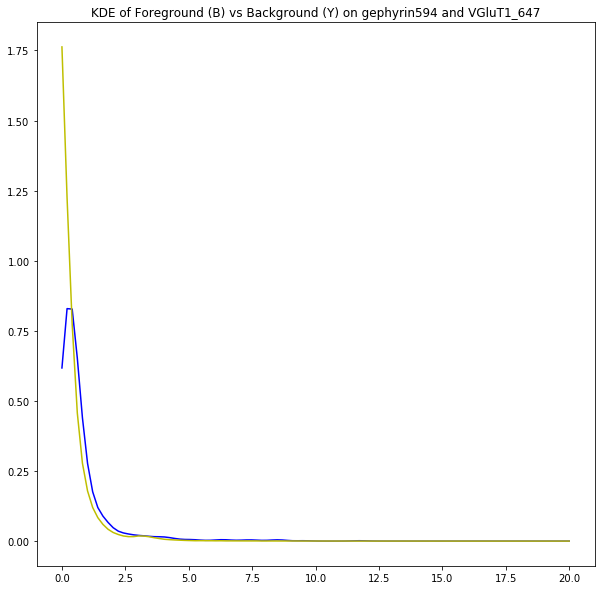

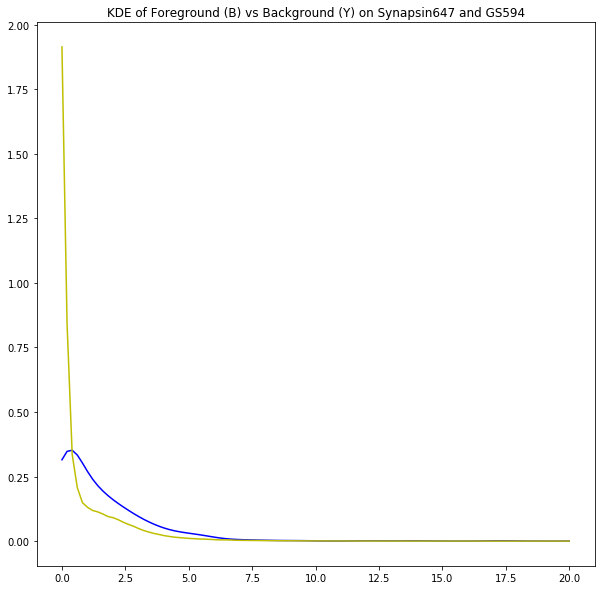

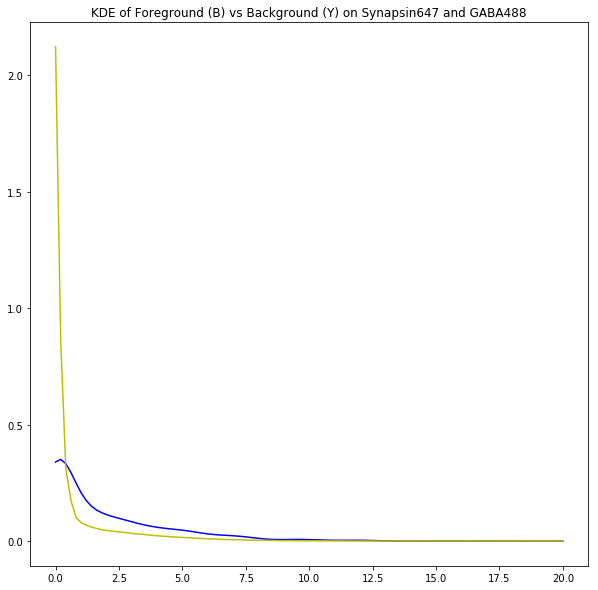

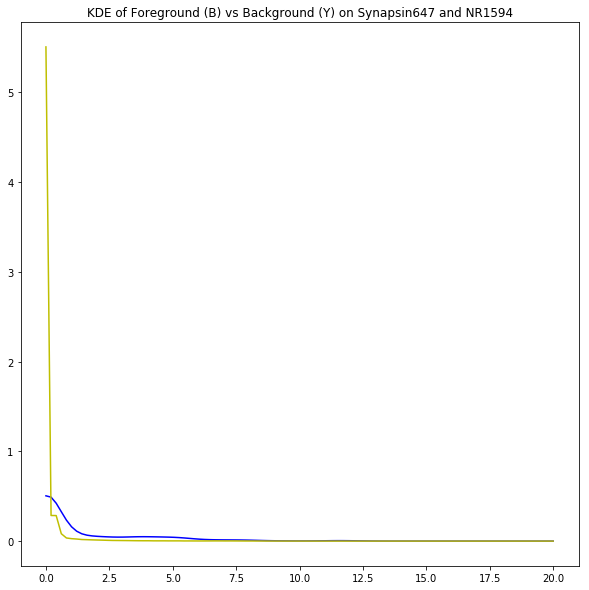

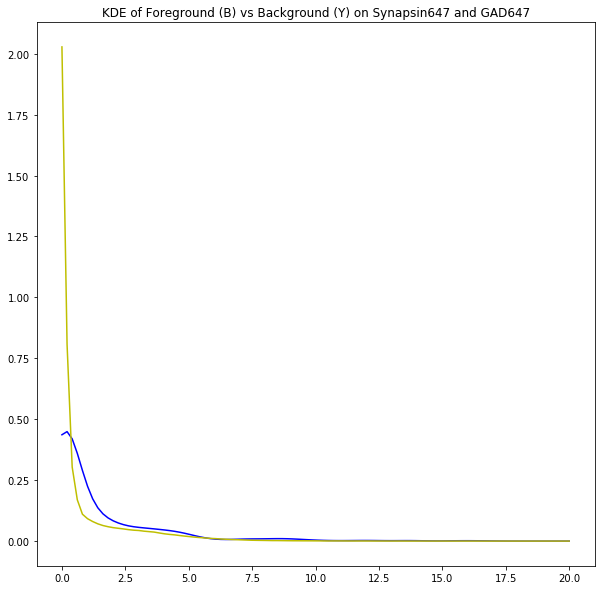

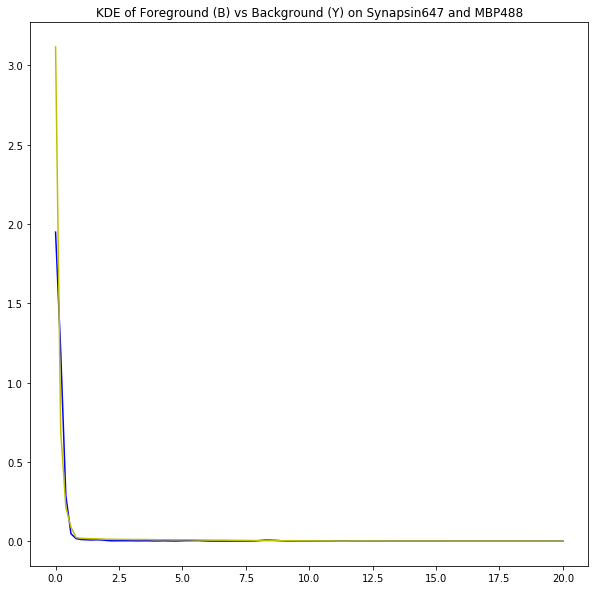

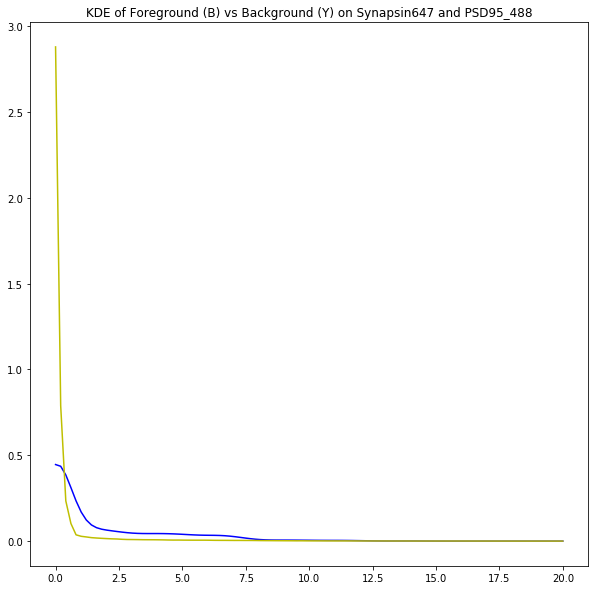

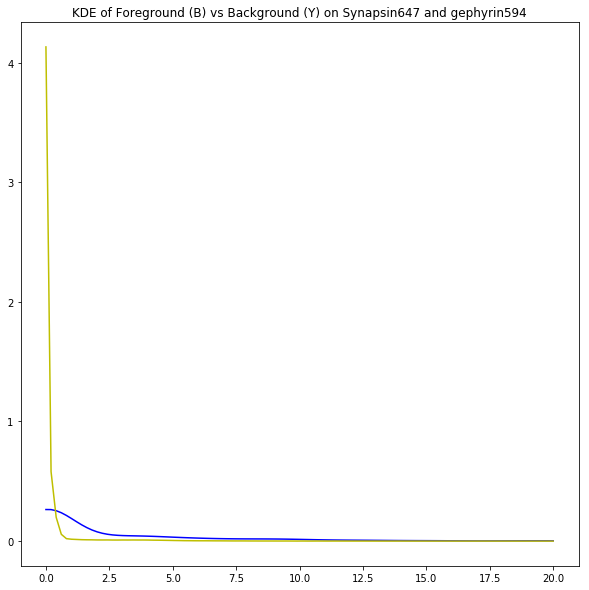

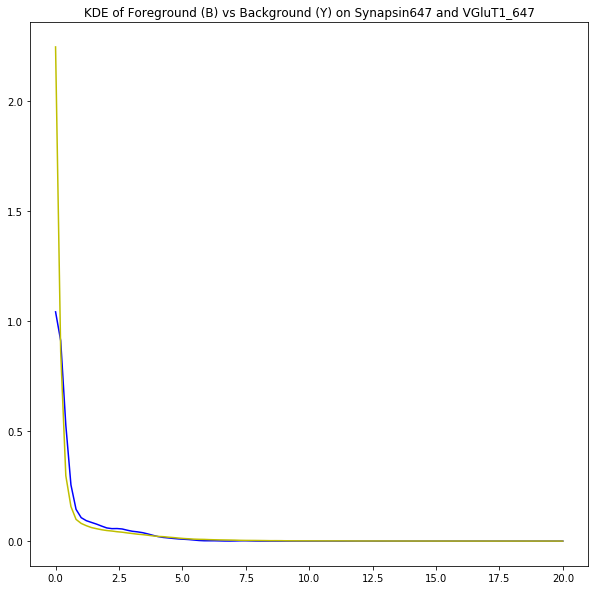

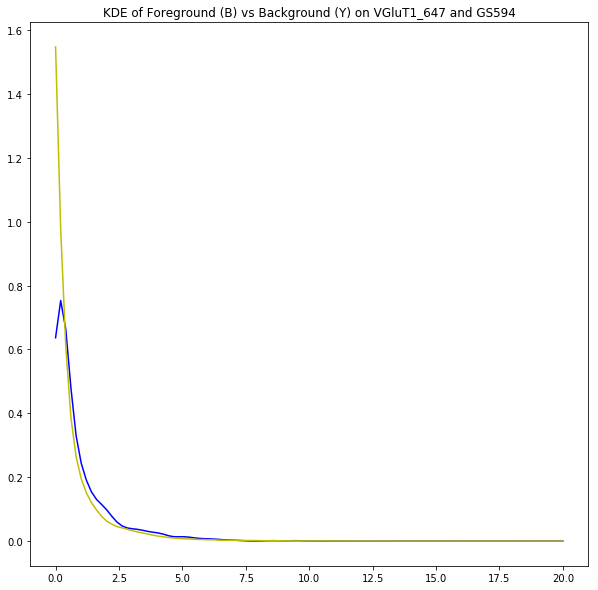

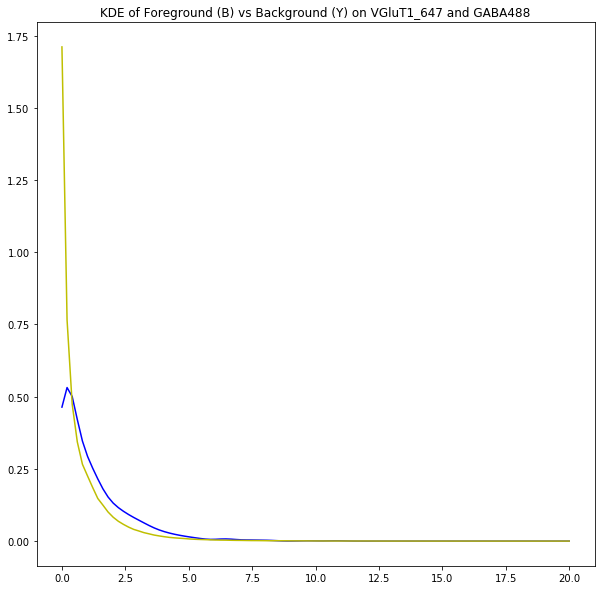

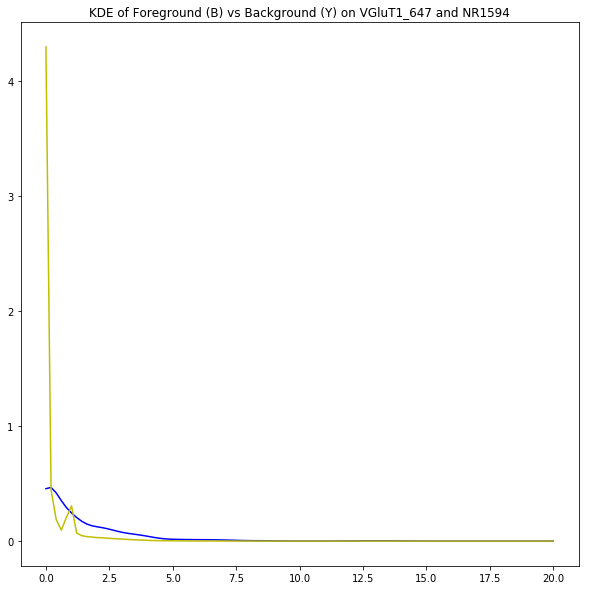

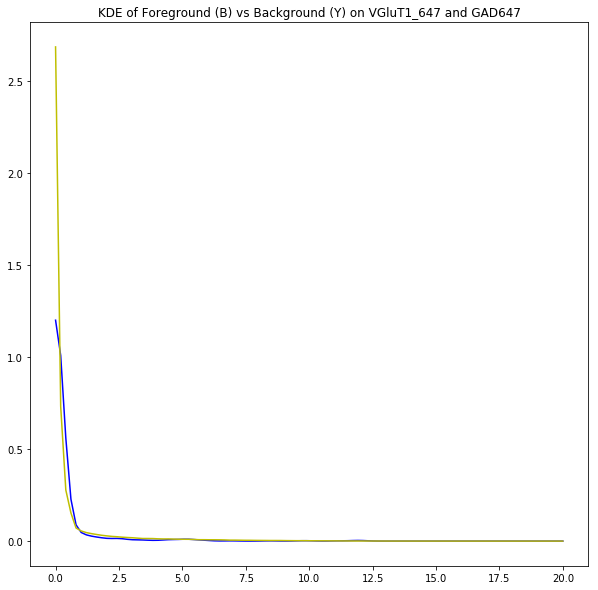

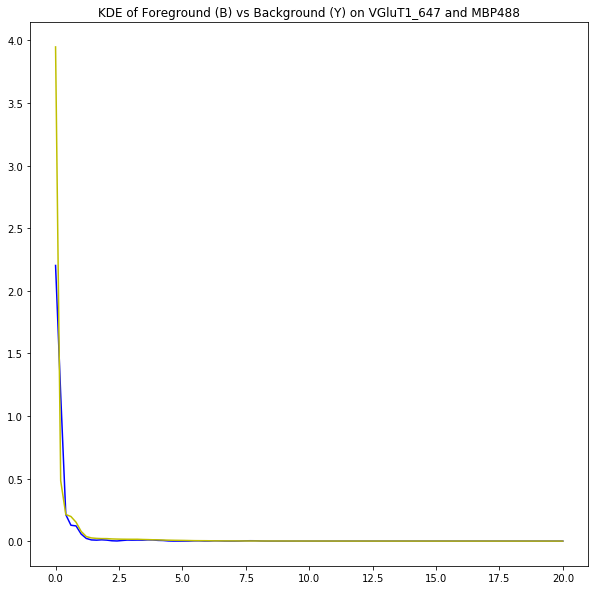

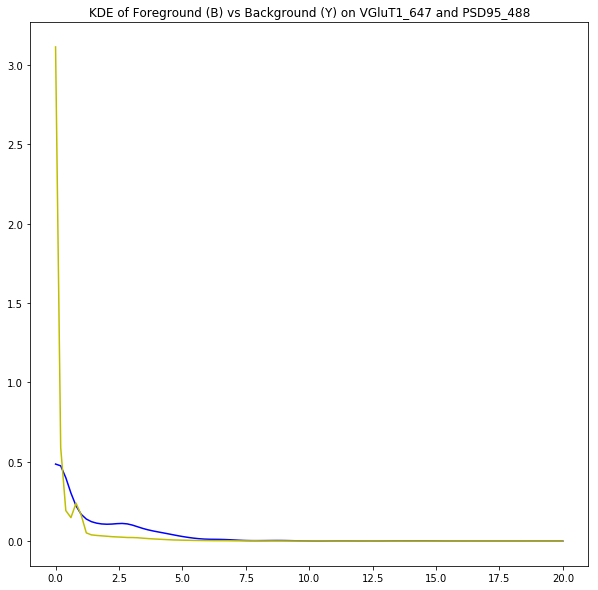

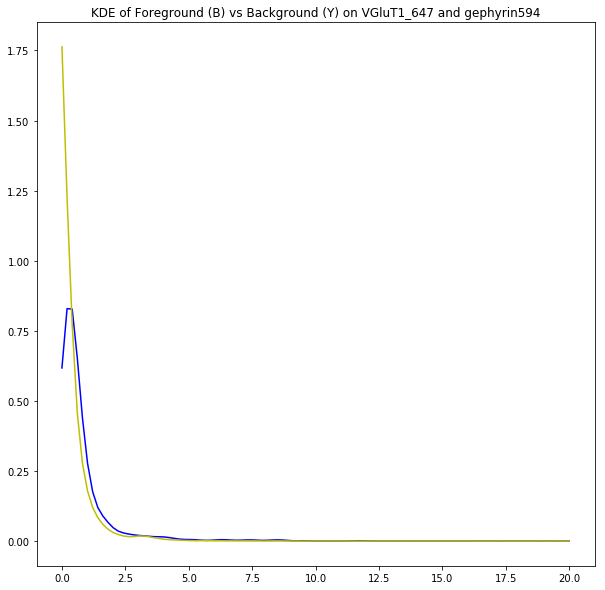

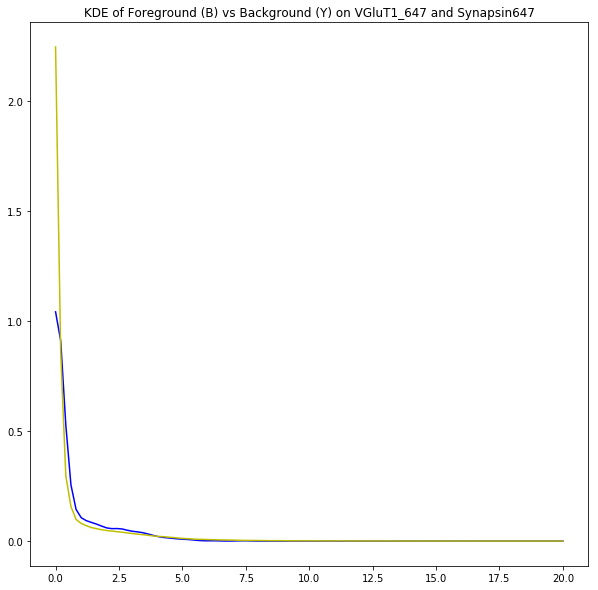

In [12]:
for key1 in data.keys():
    for key2 in data.keys():
        if not 'annot' in key1 and not 'annot' in key2 and not key1==key2:
            biomarker_volume_1 = np.stack(data[key1]).astype(float)
            biomarker_volume_2 = np.stack(data[key2]).astype(float)
            cov_vol = compute_convolutional_cov(biomarker_volume_1,
                                                biomarker_volume_2,
                                                (3, 3, 3))
            
            fn_pop = cov_vol[np.where(fn_annot != 0)]
            fn_density = kde(fn_pop)

            background_pop = cov_vol[np.where(annot == 0)]
            background_density = kde(background_pop)

            xs = np.linspace(0, 20, 100)

            plt.figure(figsize=(10, 10))
            plt.title('KDE of Foreground (B) vs Background (Y) on ' + str(key1) + ' and ' + str(key2))
            plt.plot(xs, fn_density(xs), c='b')
            plt.plot(xs, background_density(xs), c='y')
            plt.show()


From this, a few interesting observations can be made:
- There is a clear bimodality in the following plots:
    1. PSD & Gephyrin
    2. PSD & GS
    3. NR1 & Gephyrin
This means that a binarization based on their feature representation will likely perform with high accuracy and moderate recall. 

Further, the GAD & GABA KDE exhibits a VERY long tail compaired to the background - This will also likely allow the otsu binarization to perform well. I try these different approaches below

In [13]:
def z_transform(img):
    sigma = np.std(img)
    mu = np.average(img)
    return (img - mu)/sigma


def normalize_data(data):
    return np.stack([z_transform(chan) for chan in data])


def predict_from_feature_map(feature_map):
    foreground = feature_map > threshold_otsu(feature_map)
    predictions = label(foreground)
    return predictions

In [14]:
data.keys()

dict_keys(['GS594', 'GABA488', 'NR1594', 'GAD647', 'annotation', 'MBP488', 'PSD95_488', 'gephyrin594', 'Synapsin647', 'VGluT1_647'])

In [17]:

bm1 = normalize_data(np.stack(data['NR1594']).astype(float))
bm2 = normalize_data(np.stack(data['gephyrin594']).astype(float))
cov_map = compute_convolutional_cov(bm1,
                                    bm2,
                                    (3, 3, 3))
pred = predict_from_feature_map(cov_map)
total_overlap_array = compute_overlap_array(pred, np.stack(data['annotation']).astype(int))
fn_overlap_array = compute_overlap_array(pred, np.stack(fn_annot).astype(int))

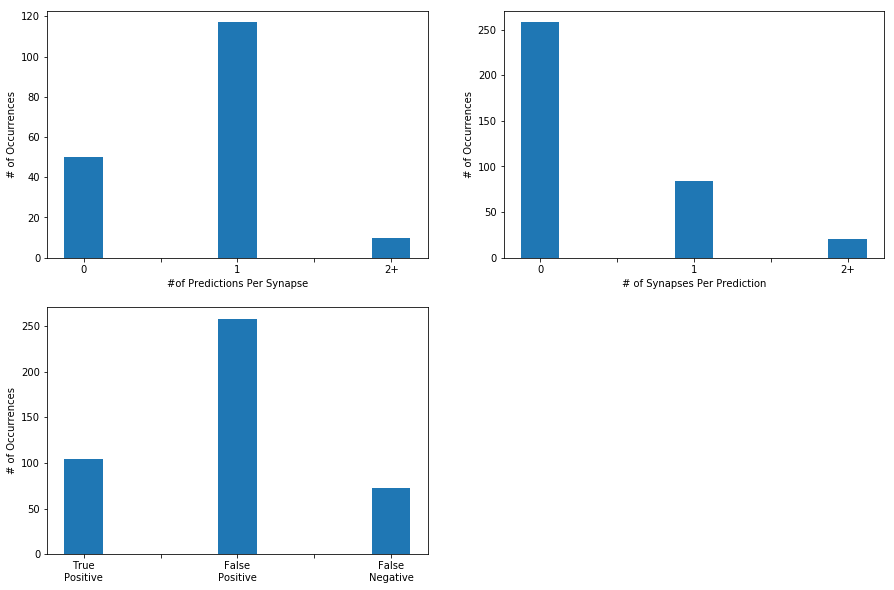

In [18]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(221)
ax.set_xlabel('#of Predictions Per Synapse')
ax.set_ylabel('# of Occurrences')

arr = np.array(total_overlap_array['predictionPerGt'])

freq = [np.sum([arr == 0]),
        np.sum([arr == 1]),
        np.sum([arr >= 2])]

r1 = ax.bar([0, 1, 2], freq, .25)
ax.set_xticklabels(('','0', '', '1','', '2+'))


ax = plt.subplot(222)
ax.set_xlabel('# of Synapses Per Prediction')
ax.set_ylabel('# of Occurrences')

arr = np.array(total_overlap_array['gtPerPrediction'])

freq = [np.sum([arr == 0]),
        np.sum([arr == 1]),
        np.sum([arr >= 2])]



r1 = ax.bar([0, 1, 2], freq, .25)


ax.set_xticklabels(('','0', '', '1','', '2+'))

ax = plt.subplot(223)
ax.set_ylabel('# of Occurrences')


arr = np.array(total_overlap_array['gtPerPrediction'])
tp = np.sum([arr >= 1])
fp = np.sum([arr == 0])
arr = np.array(total_overlap_array['predictionPerGt'])
fn = np.sum(np.ones_like(arr)) - tp


ax.set_xticklabels(('','True\nPositive','', 'False\nPositive','', 'False\nNegative'))
r1 = ax.bar([0, 1, 2], [tp, fp, fn], .25)


plt.show()



The false positive rate here is unacceptably high. I think this is a result of the initial distribution not being bimodal enough for strong OTSU performance

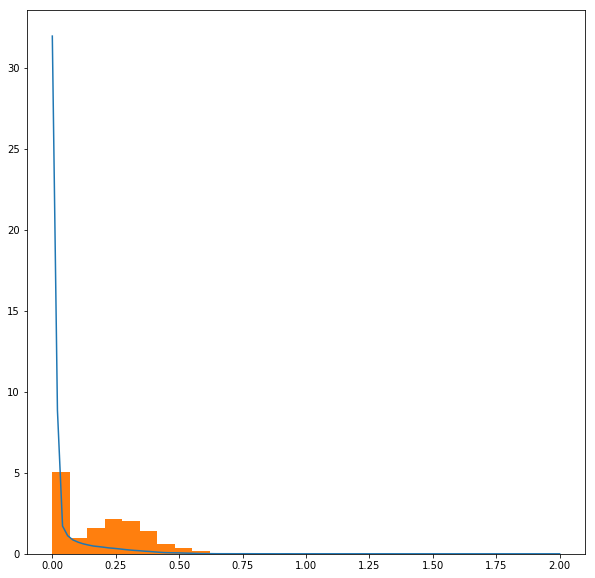

In [19]:
my_kde = kde(cov_map.flatten())
xs = np.linspace(0, 2, 100)

plt.figure(figsize=(10, 10))
plt.plot(xs, my_kde(xs))
plt.hist(cov_map[np.where(fn_annot != 0)], normed=True, bins=20)
plt.show()

In [20]:
def norm_pdf(x, mu, var):
    return 1./np.sqrt(2 * 3.14 * var) * np.exp(-1*(x - mu)**2/(2*var))

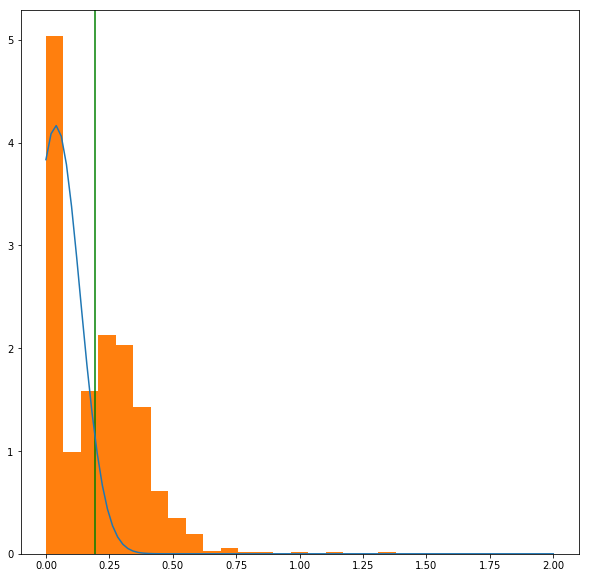

In [21]:
mu = np.mean(cov_map)
var = np.var(cov_map)
xs = np.linspace(0, 2, 100)

plt.figure(figsize=(10, 10))
plt.axvline(x = 2*np.sqrt(var), c='g')
plt.plot(xs, [norm_pdf(elem, mu, var) for elem in xs])
plt.hist(cov_map[np.where(fn_annot!= 0)], normed=True, bins=20)
plt.show()

In [22]:
pred = label(cov_map > 2 * np.std(cov_map))
total_overlap_array = compute_overlap_array(pred, np.stack(data['annotation']).astype(int))

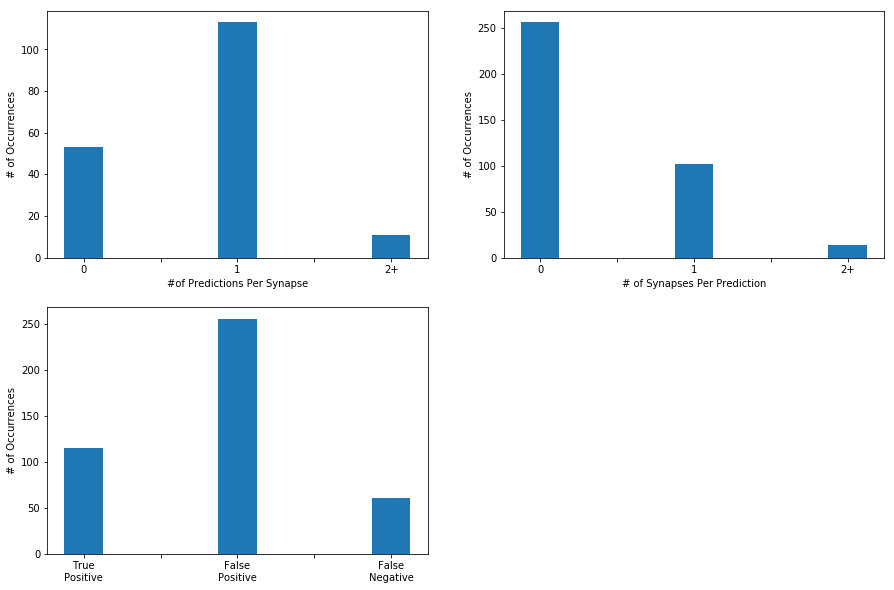

In [23]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(221)
ax.set_xlabel('#of Predictions Per Synapse')
ax.set_ylabel('# of Occurrences')

arr = np.array(total_overlap_array['predictionPerGt'])

freq = [np.sum([arr == 0]),
        np.sum([arr == 1]),
        np.sum([arr >= 2])]

r1 = ax.bar([0, 1, 2], freq, .25)
ax.set_xticklabels(('','0', '', '1','', '2+'))


ax = plt.subplot(222)
ax.set_xlabel('# of Synapses Per Prediction')
ax.set_ylabel('# of Occurrences')

arr = np.array(total_overlap_array['gtPerPrediction'])

freq = [np.sum([arr == 0]),
        np.sum([arr == 1]),
        np.sum([arr >= 2])]



r1 = ax.bar([0, 1, 2], freq, .25)


ax.set_xticklabels(('','0', '', '1','', '2+'))

ax = plt.subplot(223)
ax.set_ylabel('# of Occurrences')


arr = np.array(total_overlap_array['gtPerPrediction'])
tp = np.sum([arr >= 1])
fp = np.sum([arr == 0])
arr = np.array(total_overlap_array['predictionPerGt'])
fn = np.sum(np.ones_like(arr)) - tp


ax.set_xticklabels(('','True\nPositive','', 'False\nPositive','', 'False\nNegative'))
r1 = ax.bar([0, 1, 2], [tp, fp, fn], .25)


plt.show()



In [24]:
def compute_convolutional_triv(vol1, vol2, vol3, kernel_shape):
    mu_kernel = np.ones(kernel_shape)/float(np.sum(np.ones(kernel_shape)))
    e1 = convolve(vol1, mu_kernel)
    e2 = convolve(vol2, mu_kernel)
    e3 = convolve(vol3, mu_kernel)

    e123 = convolve(np.log(np.exp(vol1)+np.exp(vol2)+np.exp(vol3)), mu_kernel)

    cov = e123 - np.log(np.exp(e1) + np.exp(e2) + np.exp(e3))

    return cov

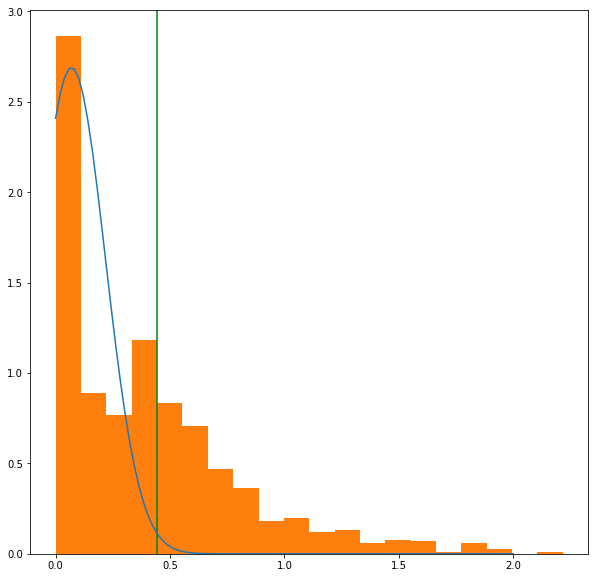

In [25]:
bm1 = normalize_data(np.stack(data['NR1594']).astype(float))
bm2 = normalize_data(np.stack(data['gephyrin594']).astype(float))
bm3 = normalize_data(np.stack(data['GABA488']).astype(float))


cov_map = compute_convolutional_triv(bm1, bm2, bm3, (3, 3 ,3))
mu = np.mean(cov_map)
var = np.var(cov_map)
xs = np.linspace(0, 2, 100)

plt.figure(figsize=(10, 10))
plt.axvline(x = 3*np.sqrt(var), c='g')
plt.plot(xs, [norm_pdf(elem, mu, var) for elem in xs])
plt.hist(cov_map[np.where(fn_annot!= 0)], normed=True, bins=20)
plt.show()

In [26]:
pred = label(cov_map > .5)
total_overlap_array = compute_overlap_array(pred, np.stack(data['annotation']).astype(int))

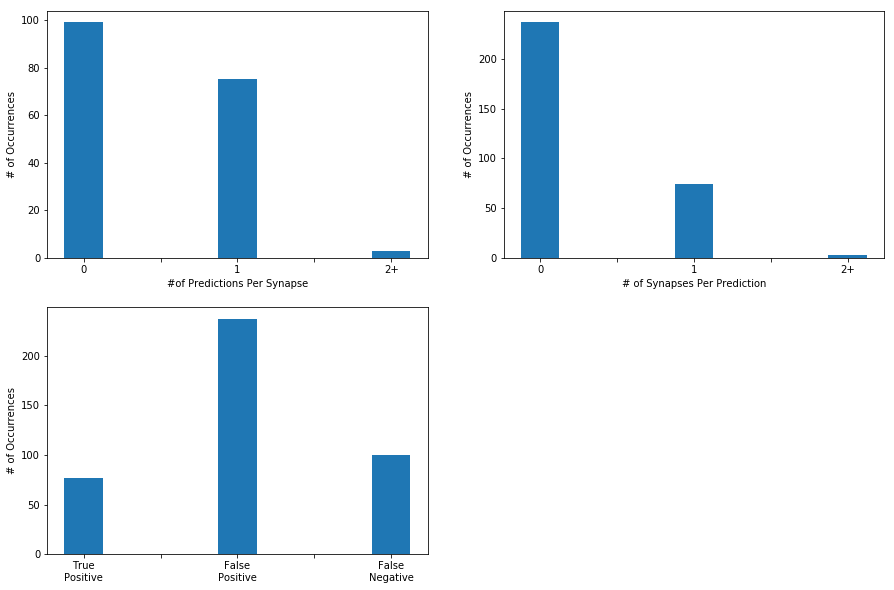

In [27]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(221)
ax.set_xlabel('#of Predictions Per Synapse')
ax.set_ylabel('# of Occurrences')

arr = np.array(total_overlap_array['predictionPerGt'])

freq = [np.sum([arr == 0]),
        np.sum([arr == 1]),
        np.sum([arr >= 2])]

r1 = ax.bar([0, 1, 2], freq, .25)
ax.set_xticklabels(('','0', '', '1','', '2+'))


ax = plt.subplot(222)
ax.set_xlabel('# of Synapses Per Prediction')
ax.set_ylabel('# of Occurrences')

arr = np.array(total_overlap_array['gtPerPrediction'])

freq = [np.sum([arr == 0]),
        np.sum([arr == 1]),
        np.sum([arr >= 2])]



r1 = ax.bar([0, 1, 2], freq, .25)


ax.set_xticklabels(('','0', '', '1','', '2+'))

ax = plt.subplot(223)
ax.set_ylabel('# of Occurrences')


arr = np.array(total_overlap_array['gtPerPrediction'])
tp = np.sum([arr >= 1])
fp = np.sum([arr == 0])
arr = np.array(total_overlap_array['predictionPerGt'])
fn = np.sum(np.ones_like(arr)) - tp


ax.set_xticklabels(('','True\nPositive','', 'False\nPositive','', 'False\nNegative'))
r1 = ax.bar([0, 1, 2], [tp, fp, fn], .25)


plt.show()



GS594  at  1


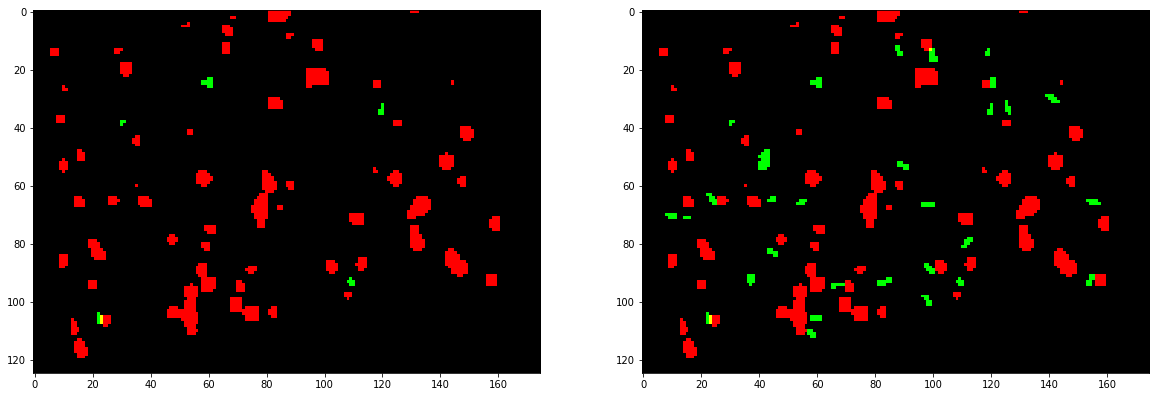

GS594  at  2


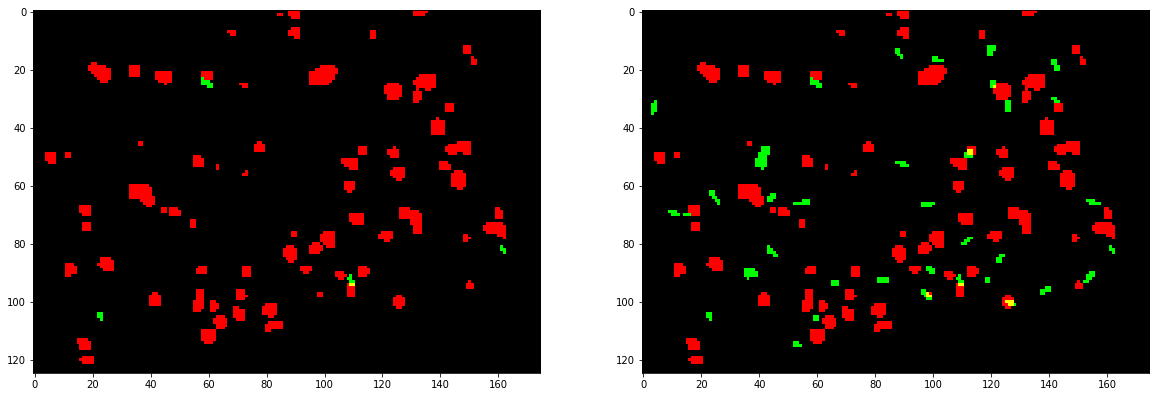

GS594  at  3


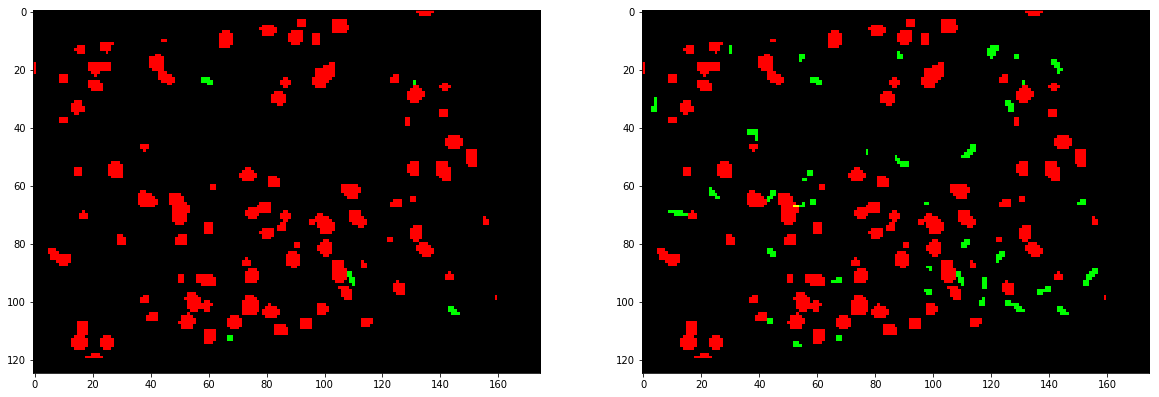

GS594  at  4


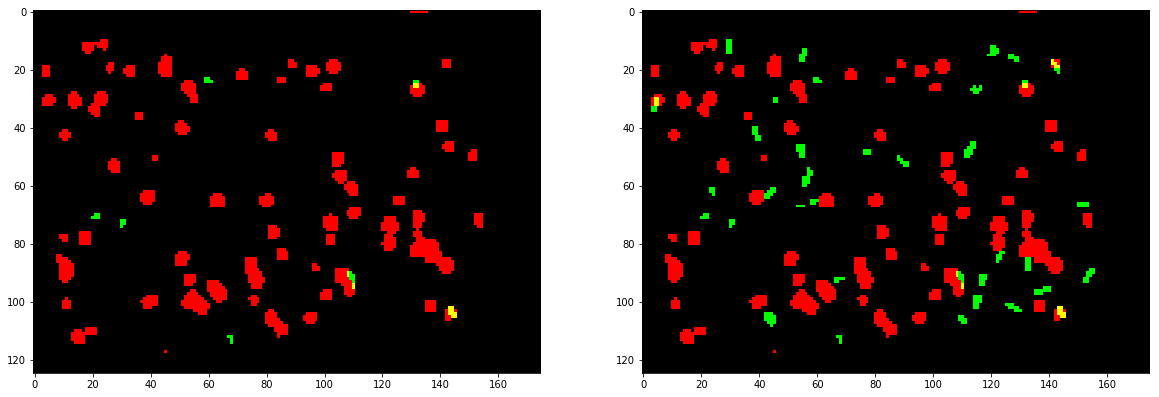

GS594  at  5


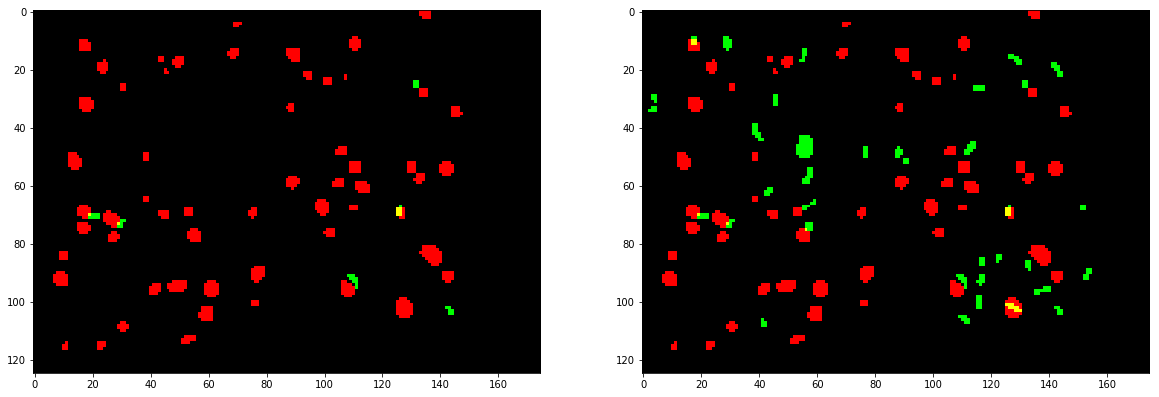

GS594  at  6


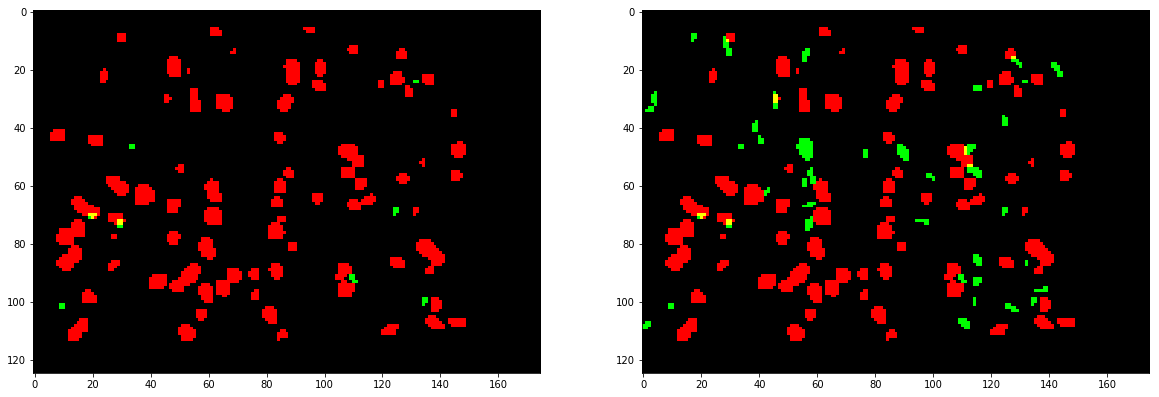

GS594  at  7


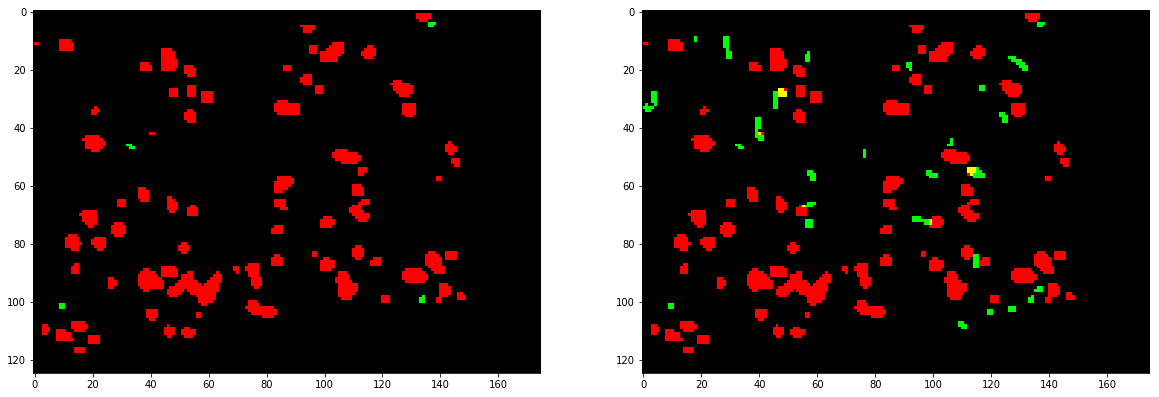

GS594  at  8


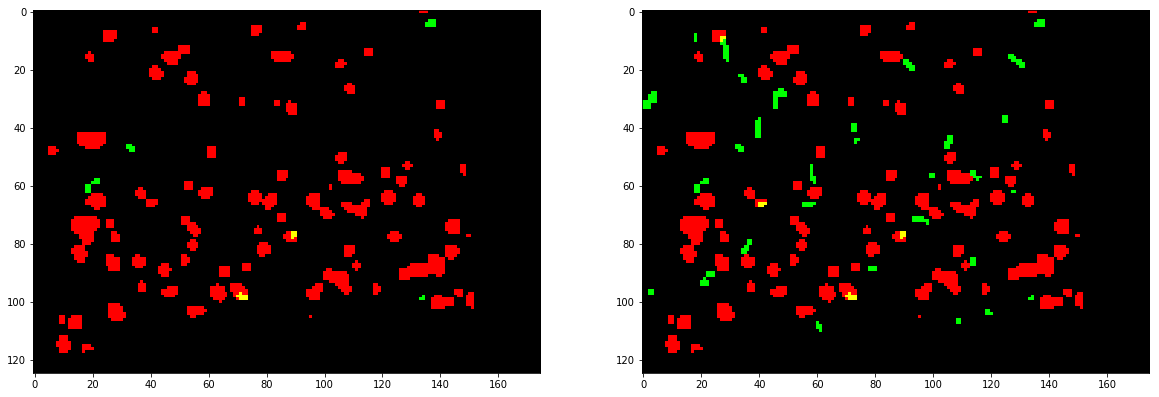

GS594  at  9


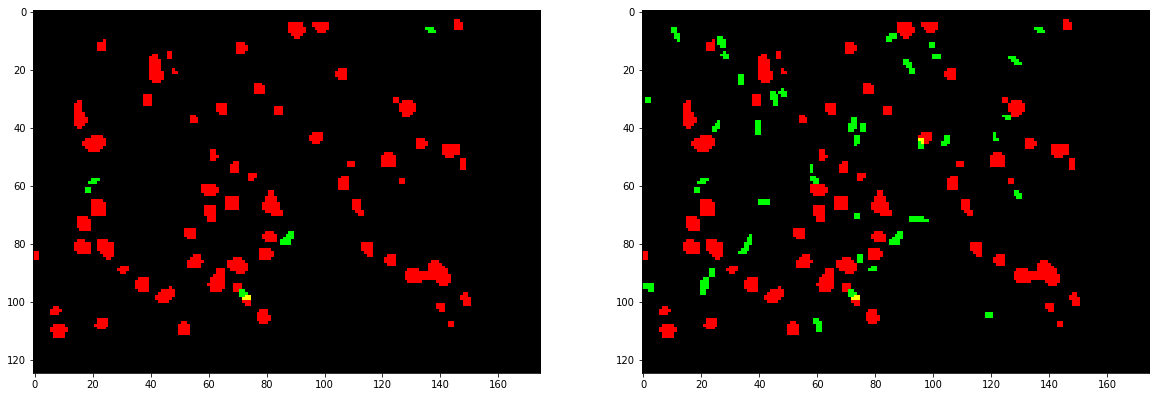

GABA488  at  1


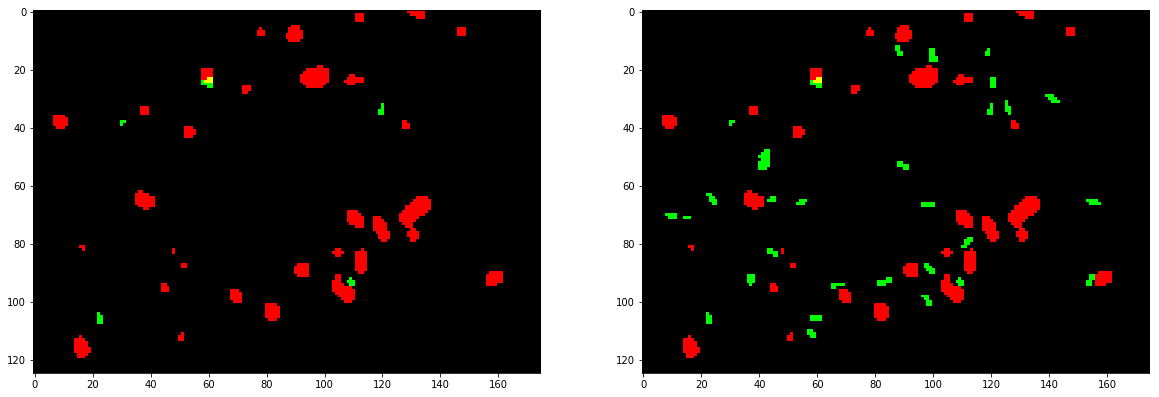

GABA488  at  2


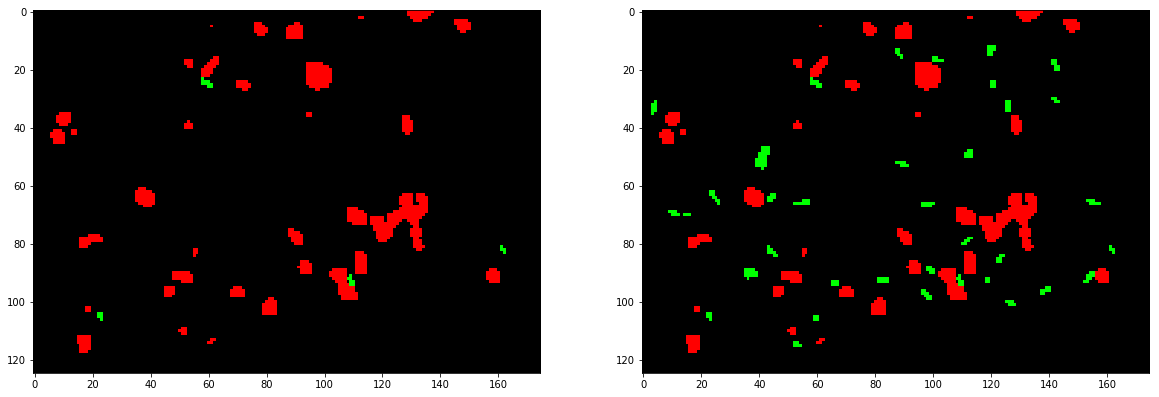

GABA488  at  3


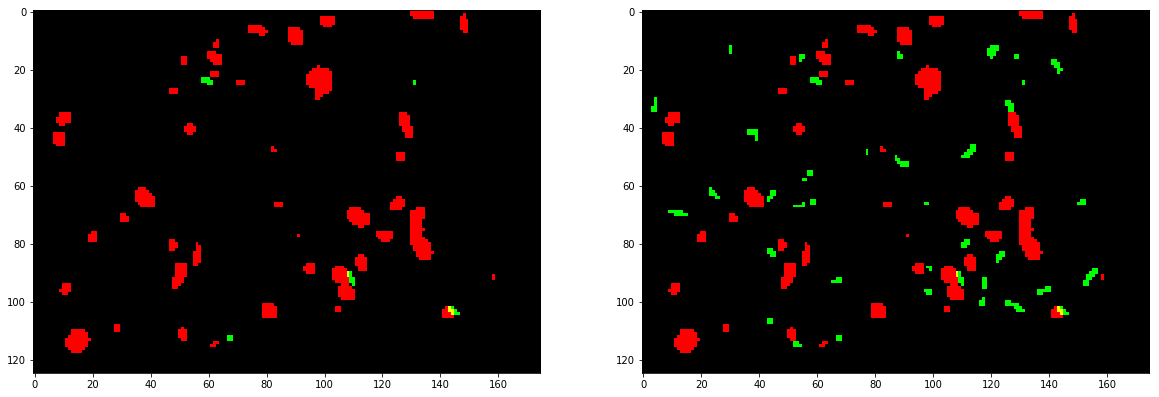

GABA488  at  4


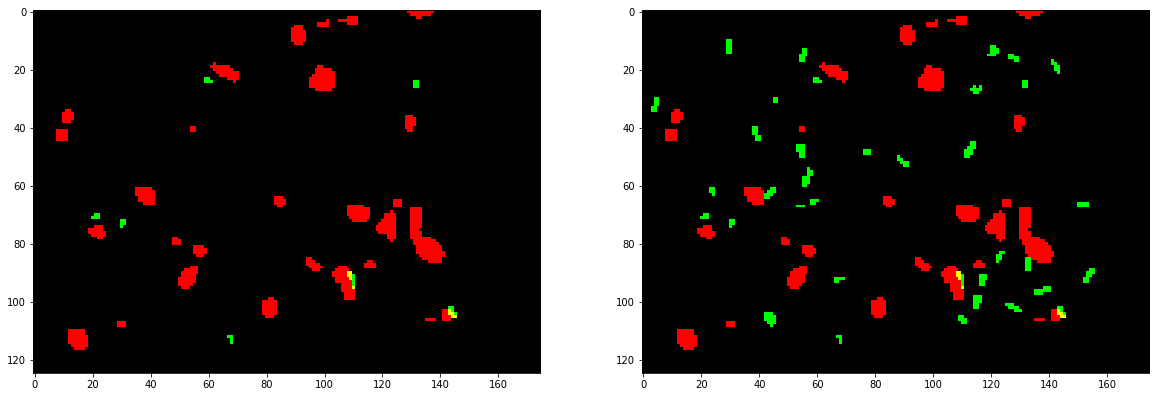

GABA488  at  5


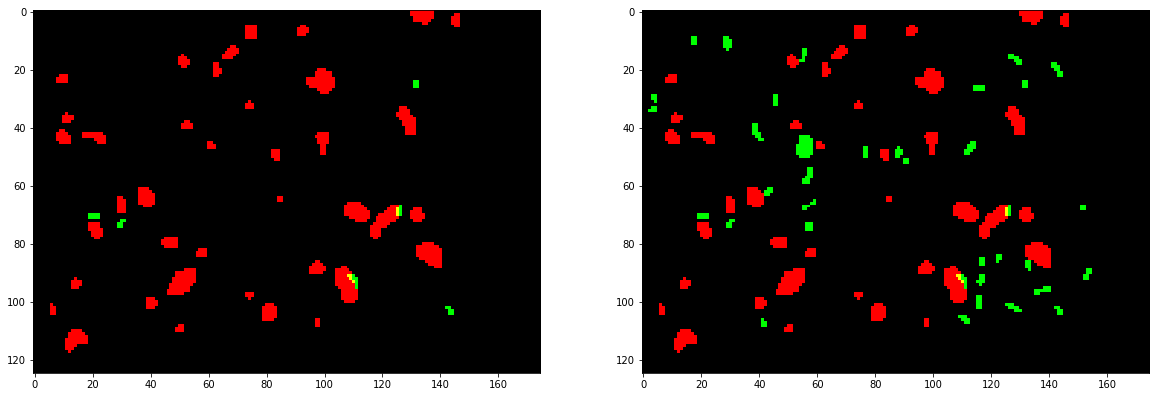

GABA488  at  6


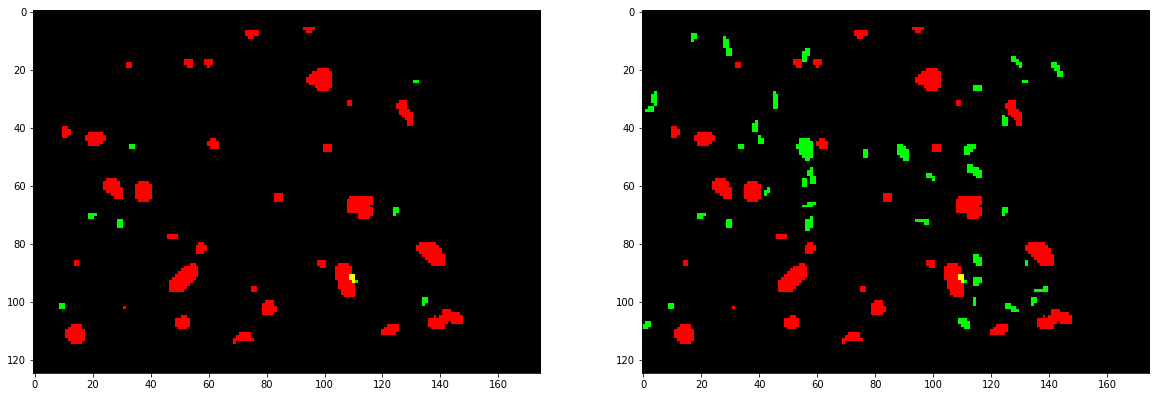

GABA488  at  7


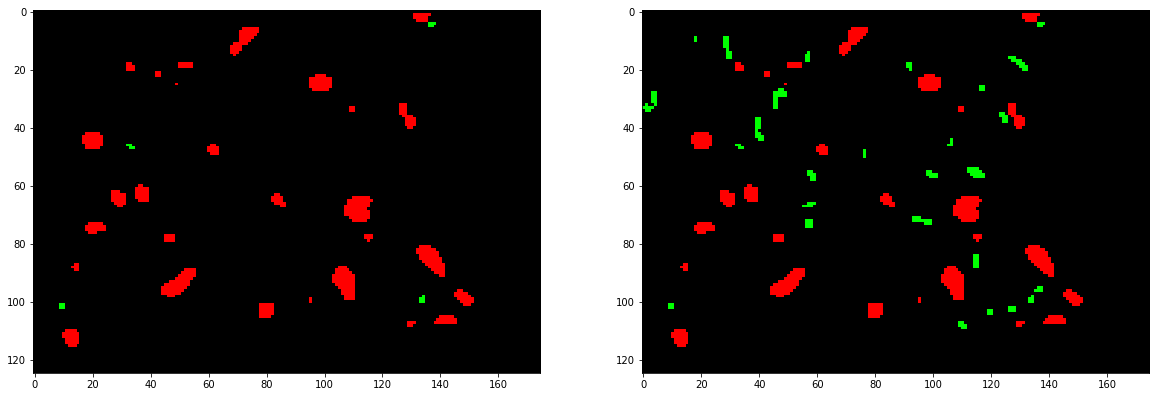

GABA488  at  8


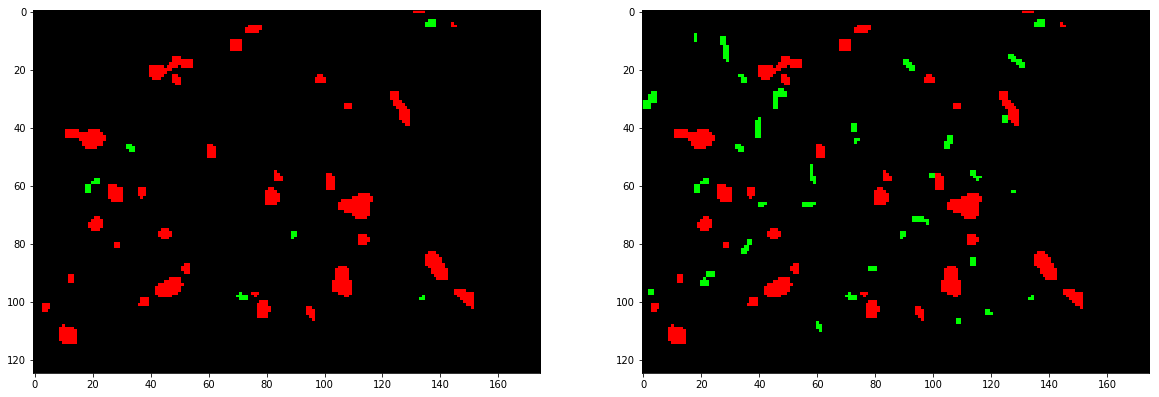

GABA488  at  9


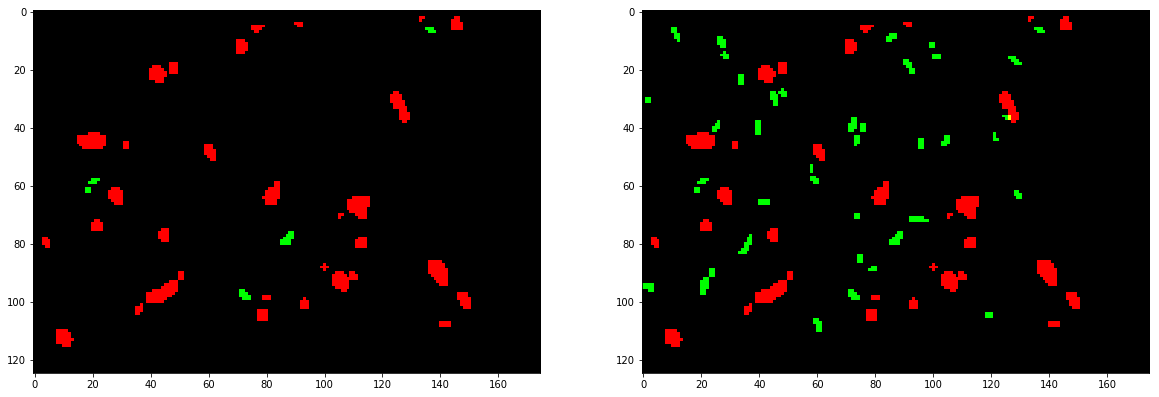

NR1594  at  1


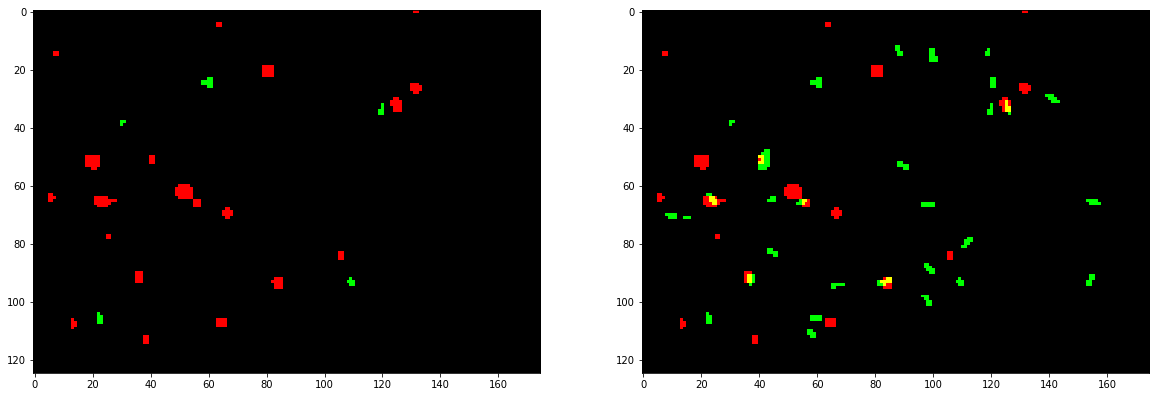

NR1594  at  2


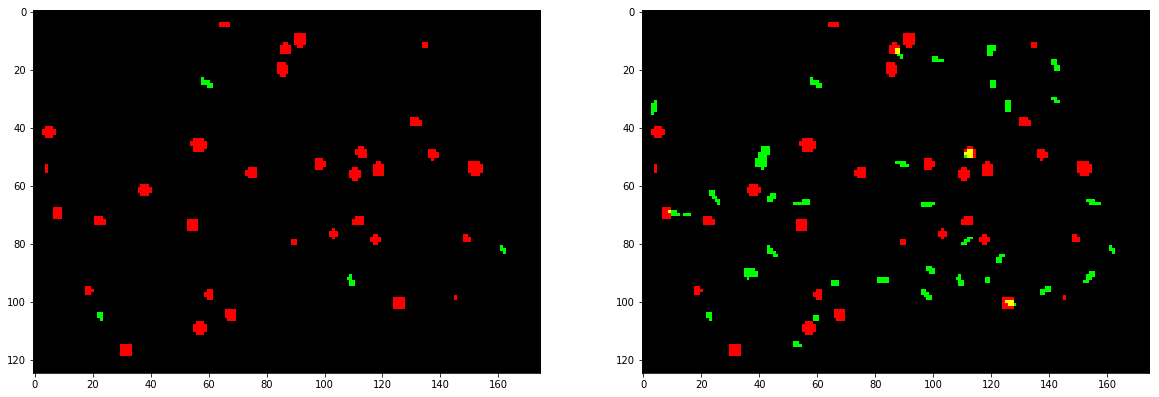

NR1594  at  3


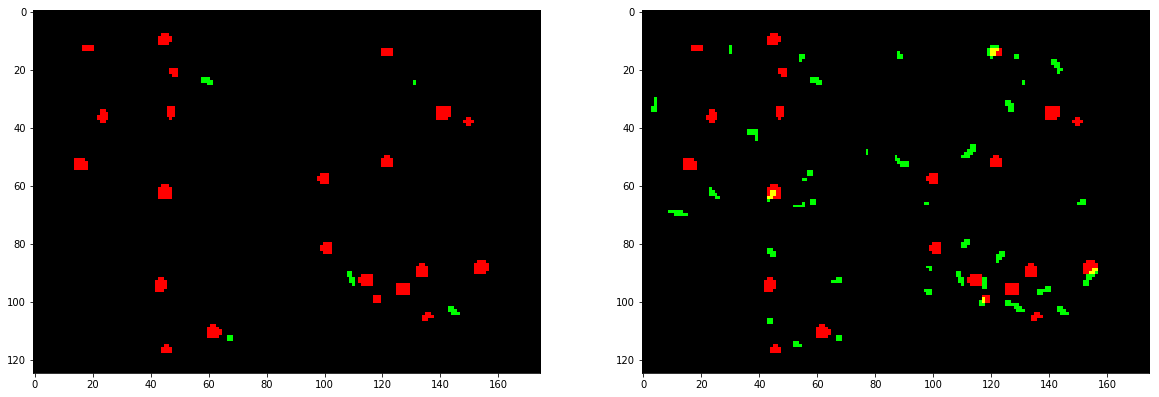

NR1594  at  4


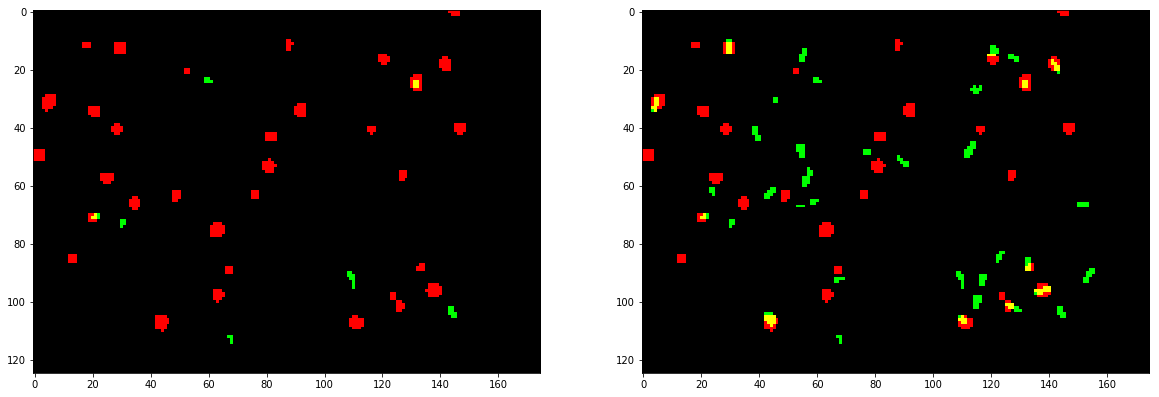

NR1594  at  5


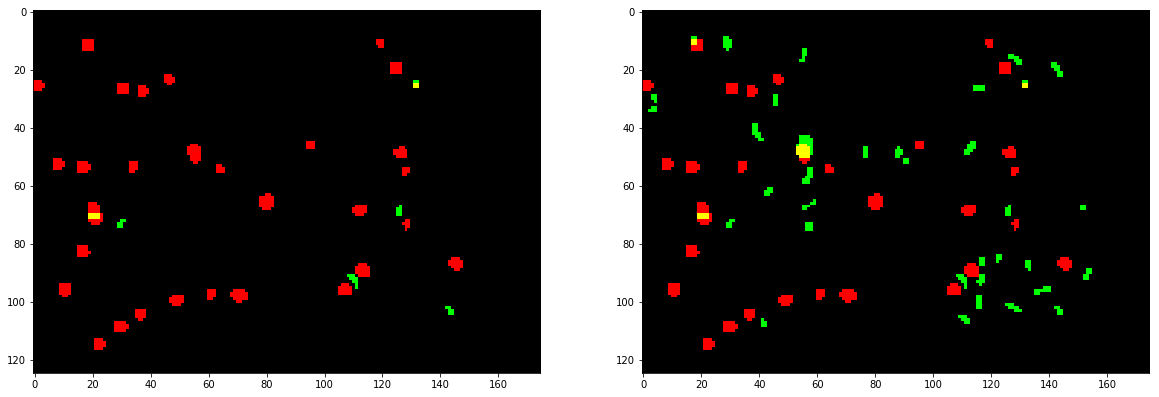

NR1594  at  6


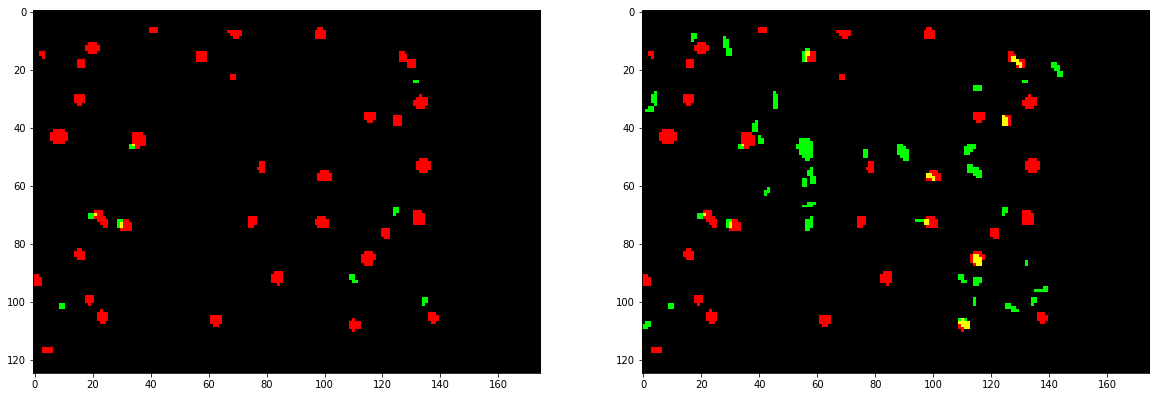

NR1594  at  7


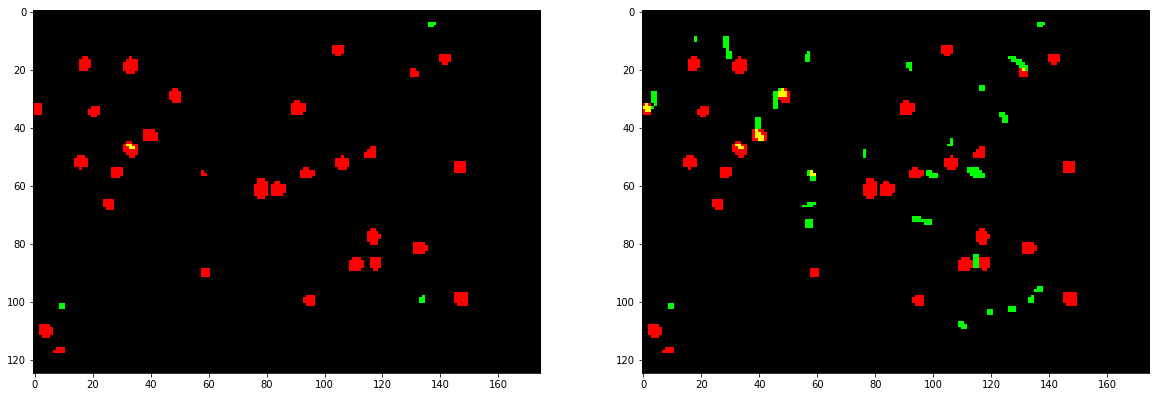

NR1594  at  8


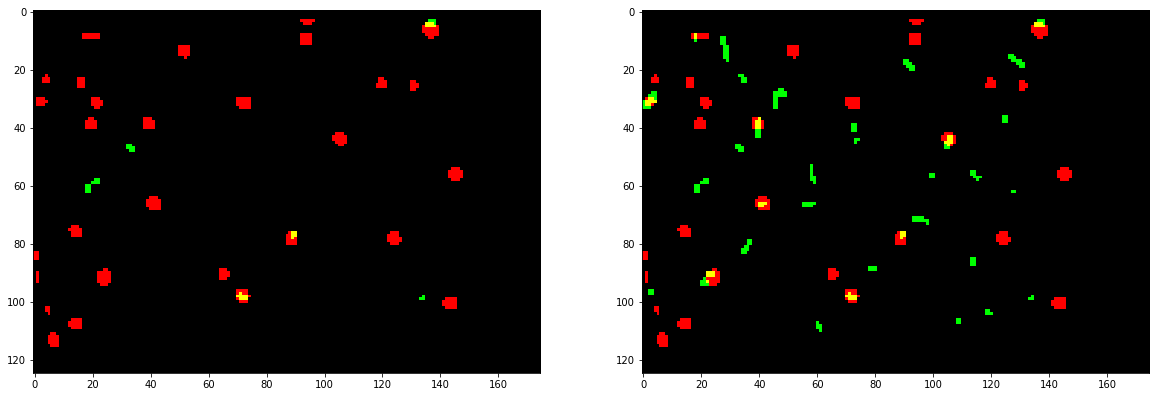

NR1594  at  9


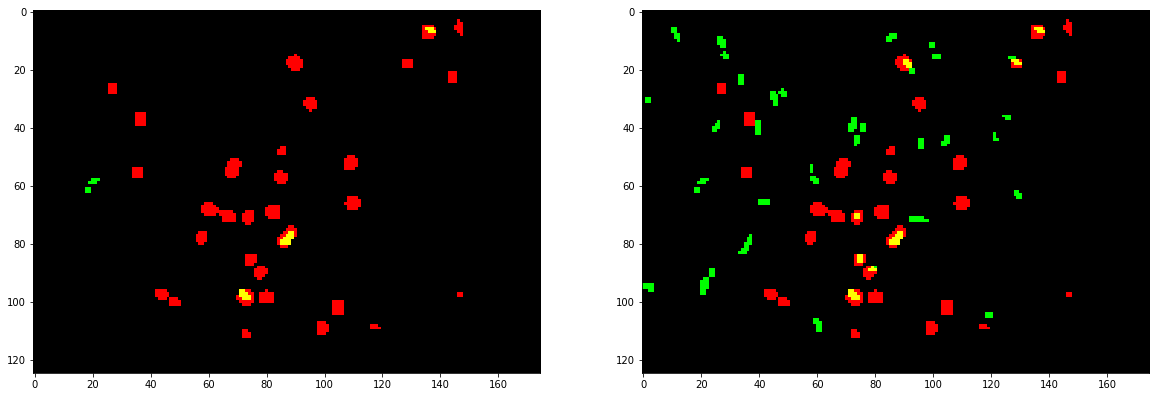

GAD647  at  1


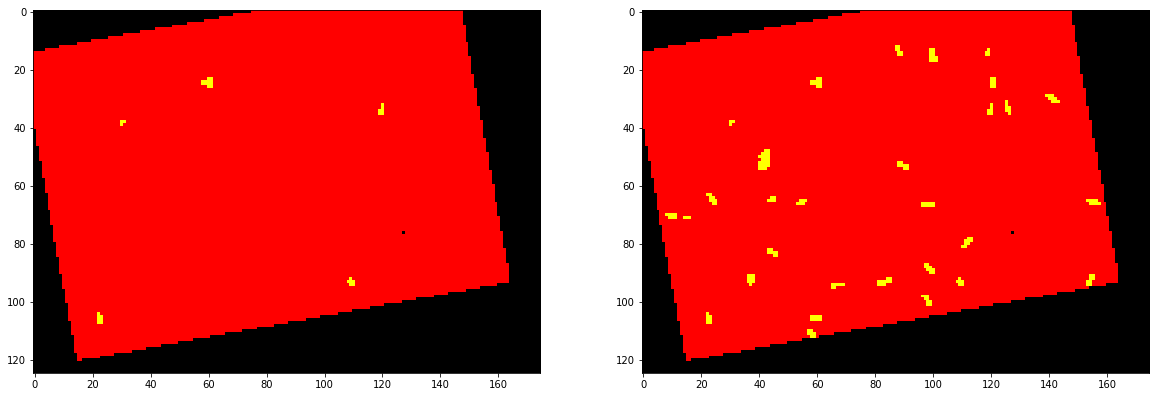

GAD647  at  2


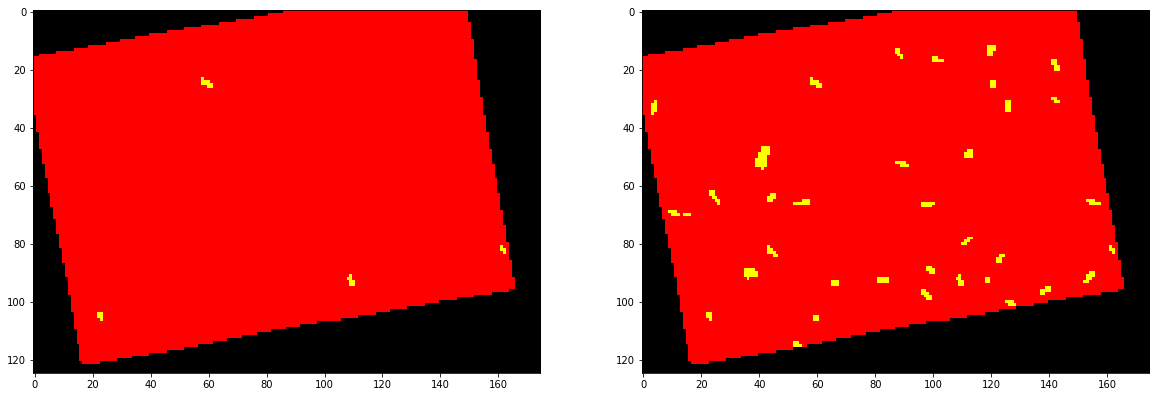

GAD647  at  3


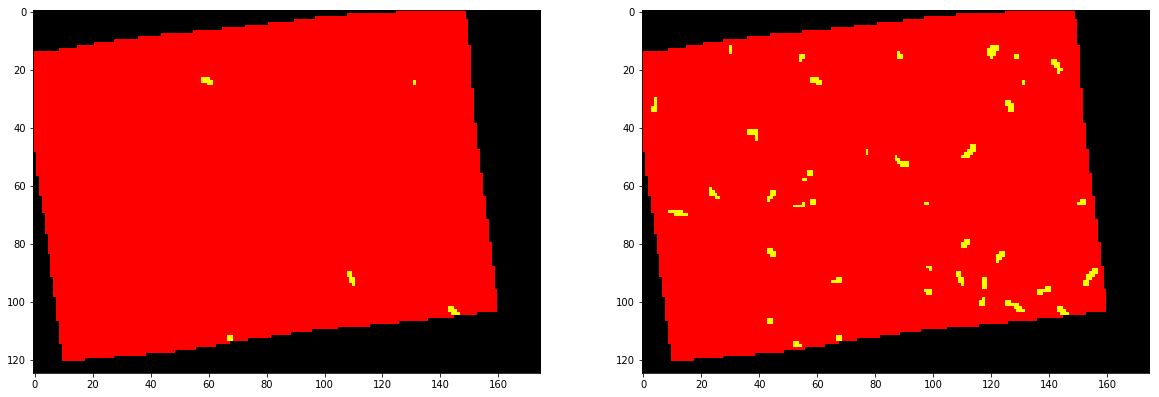

GAD647  at  4


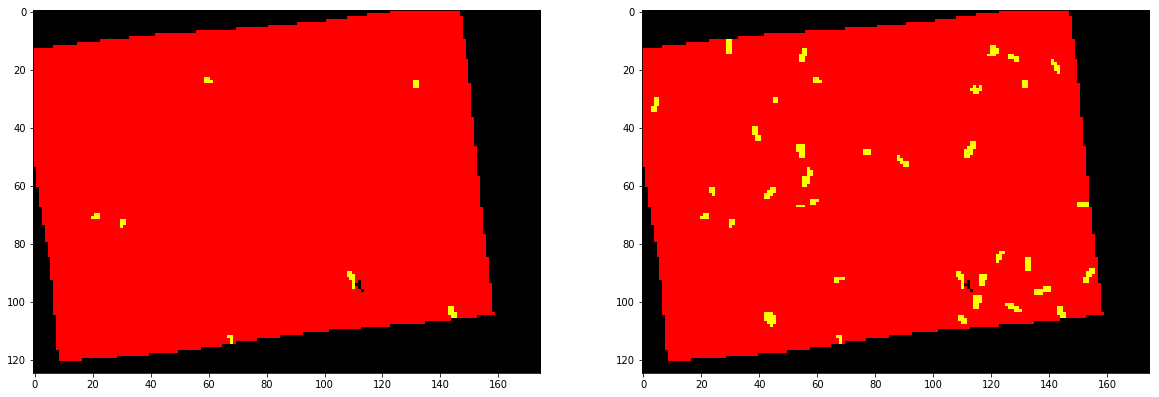

GAD647  at  5


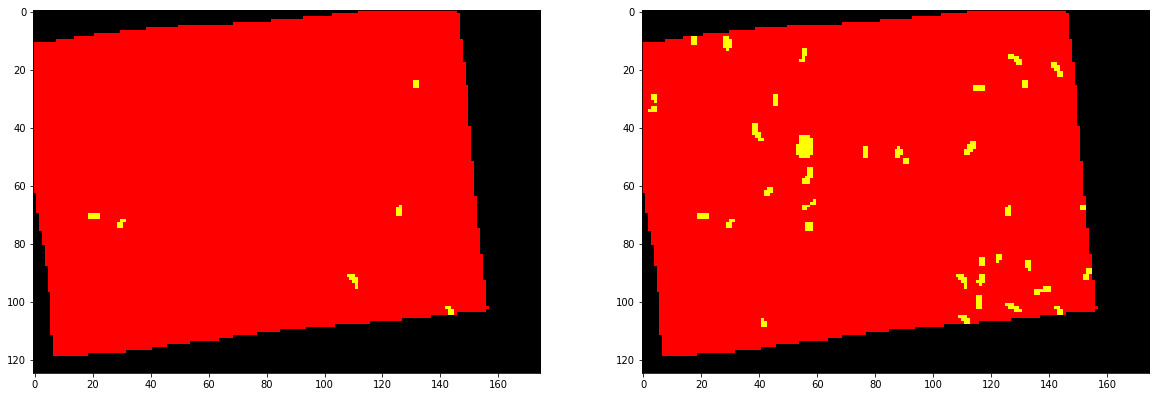

GAD647  at  6


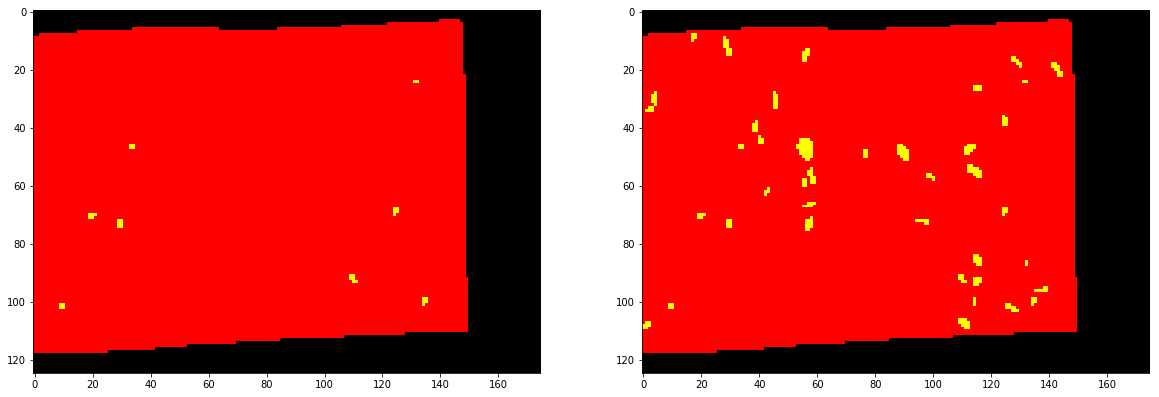

GAD647  at  7


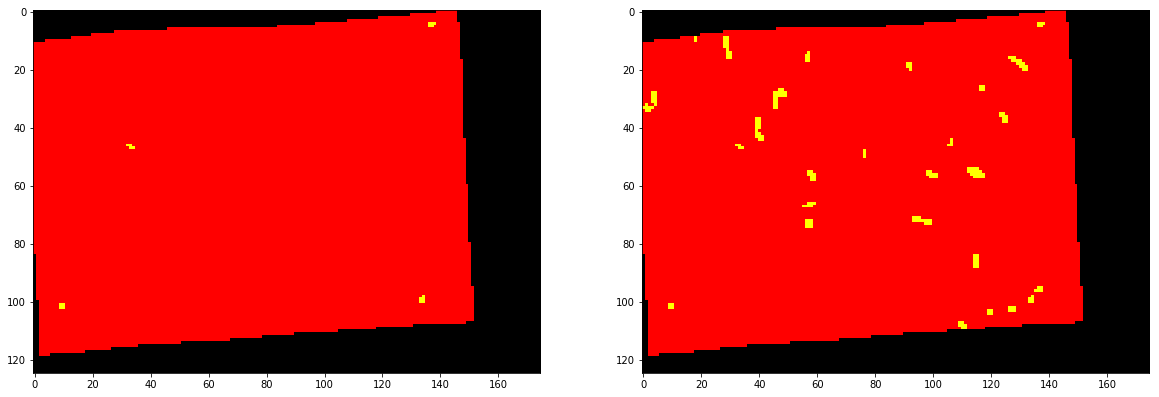

GAD647  at  8


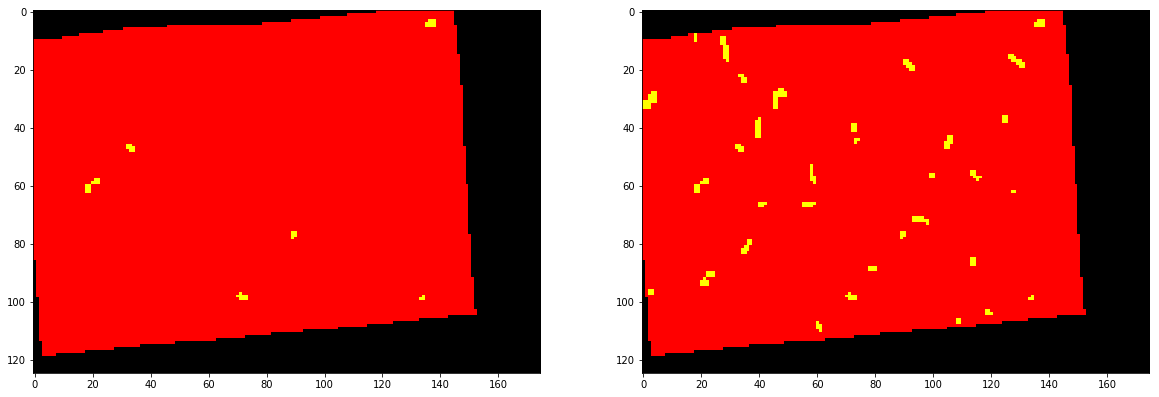

GAD647  at  9


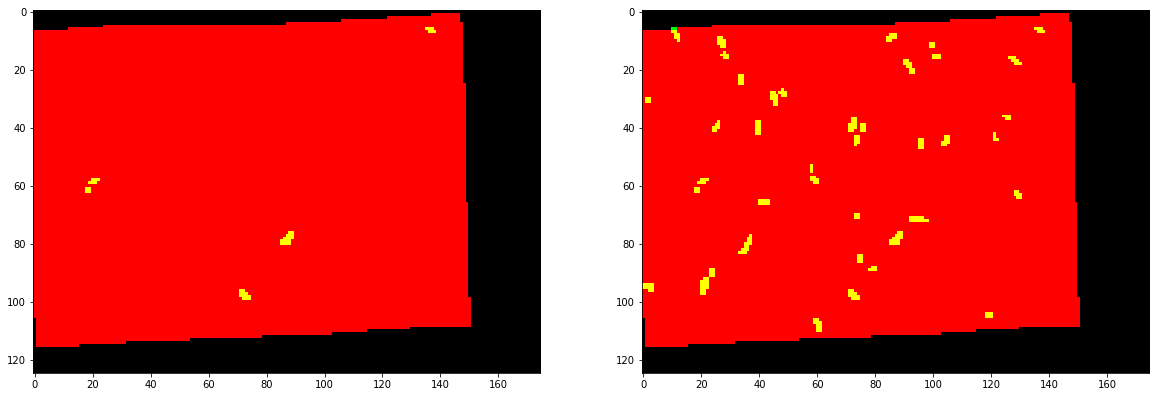

MBP488  at  1


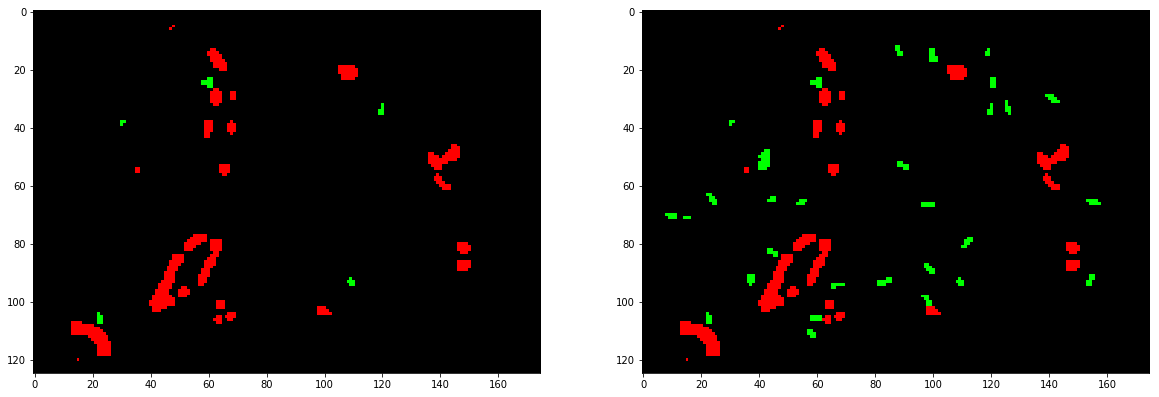

MBP488  at  2


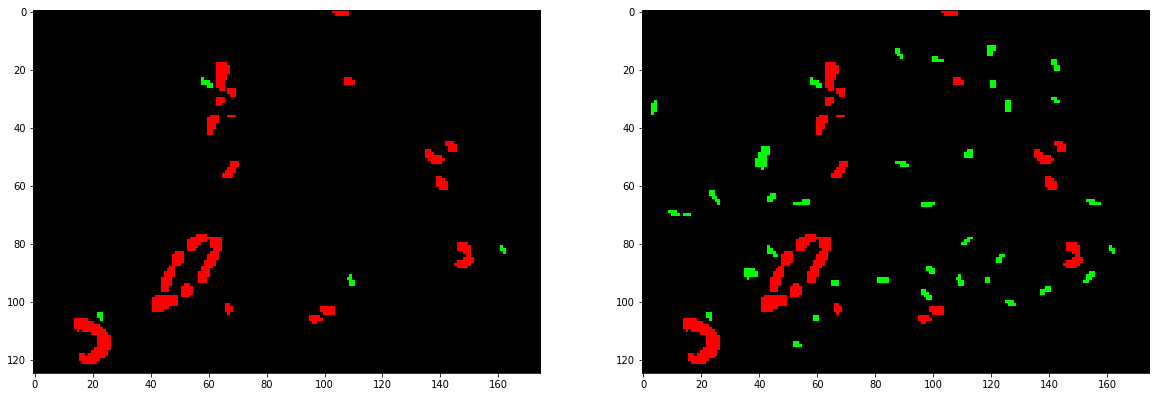

MBP488  at  3


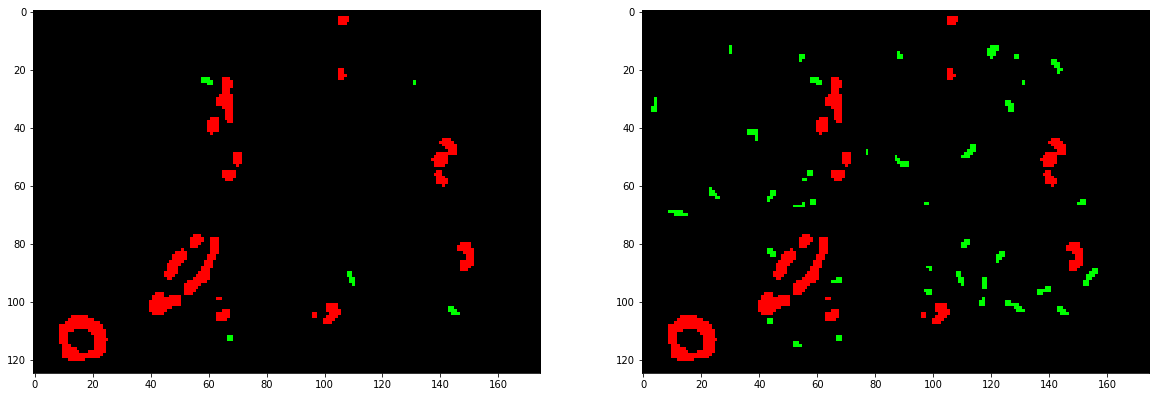

MBP488  at  4


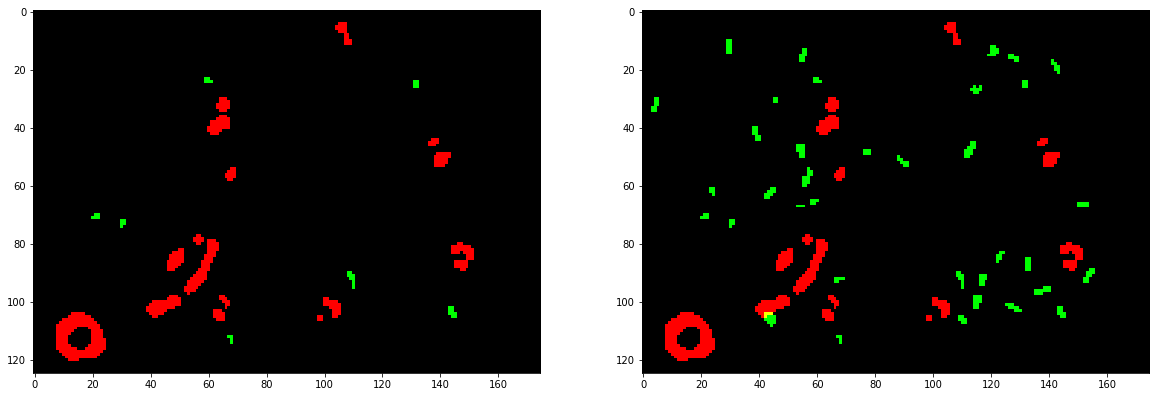

MBP488  at  5


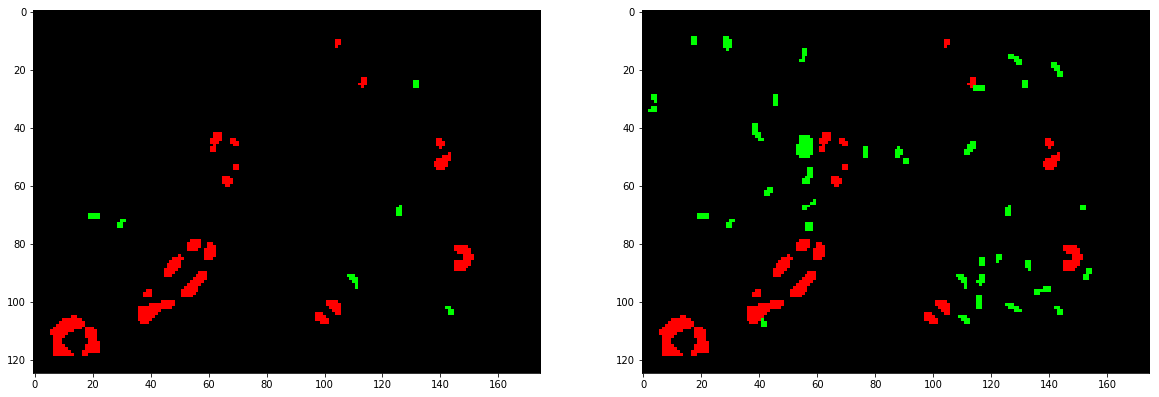

MBP488  at  6


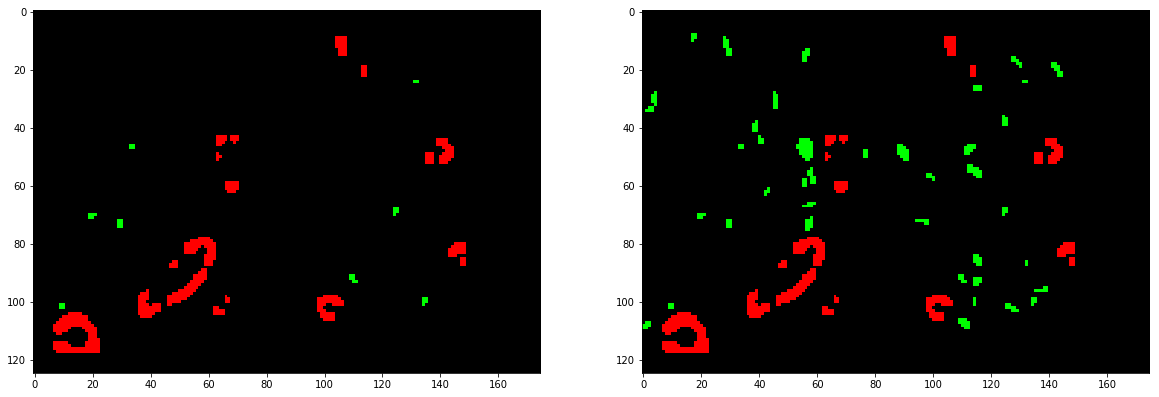

MBP488  at  7


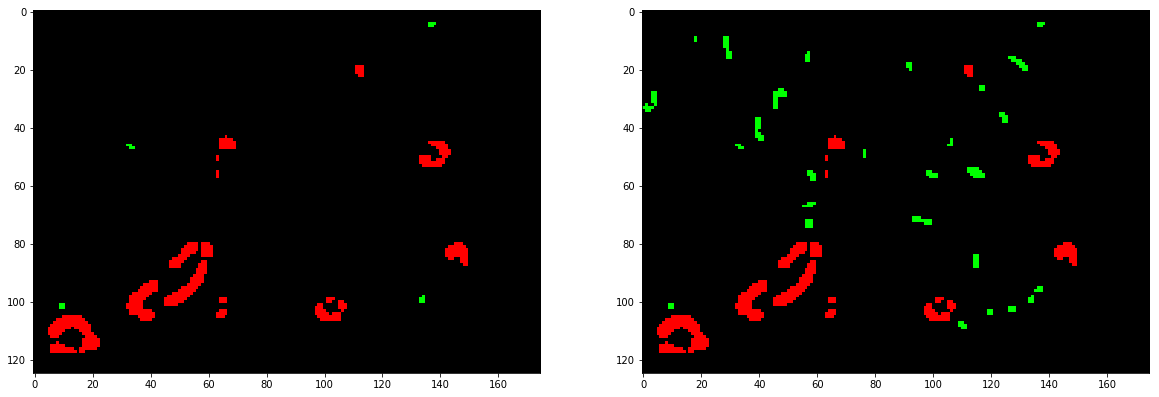

MBP488  at  8


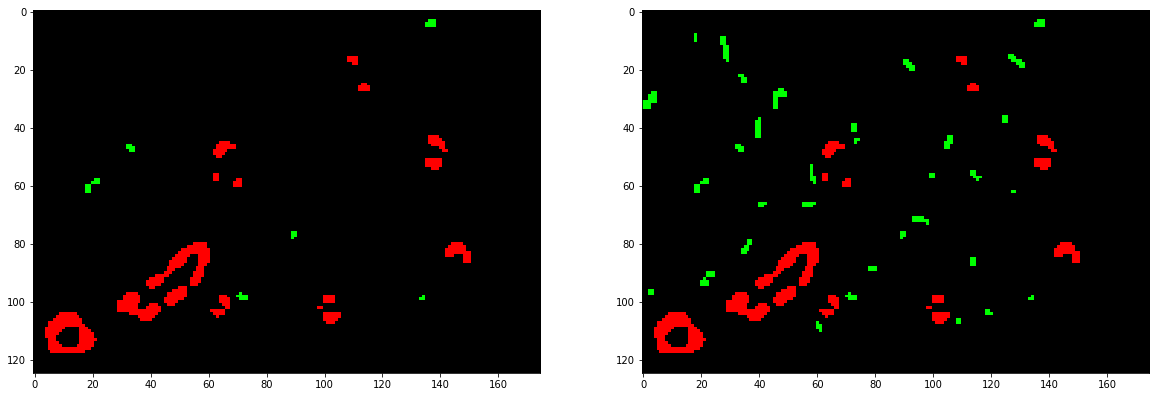

MBP488  at  9


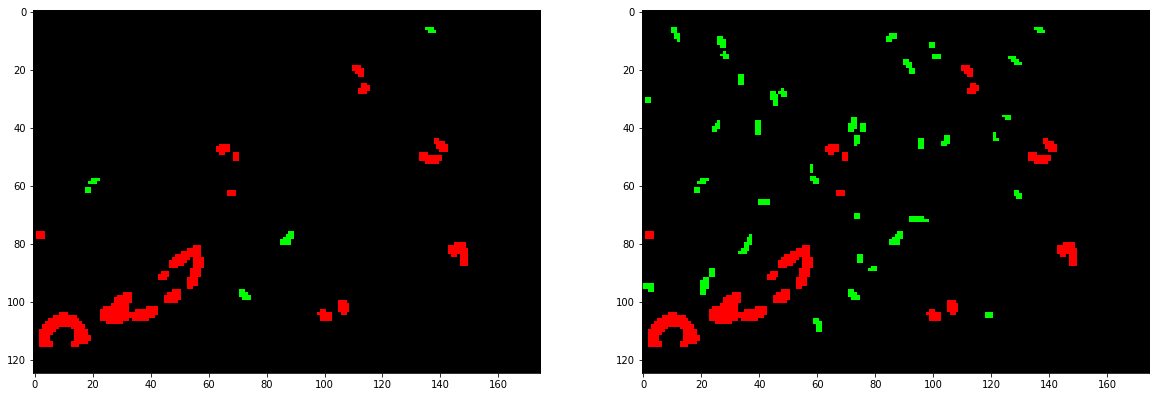

PSD95_488  at  1


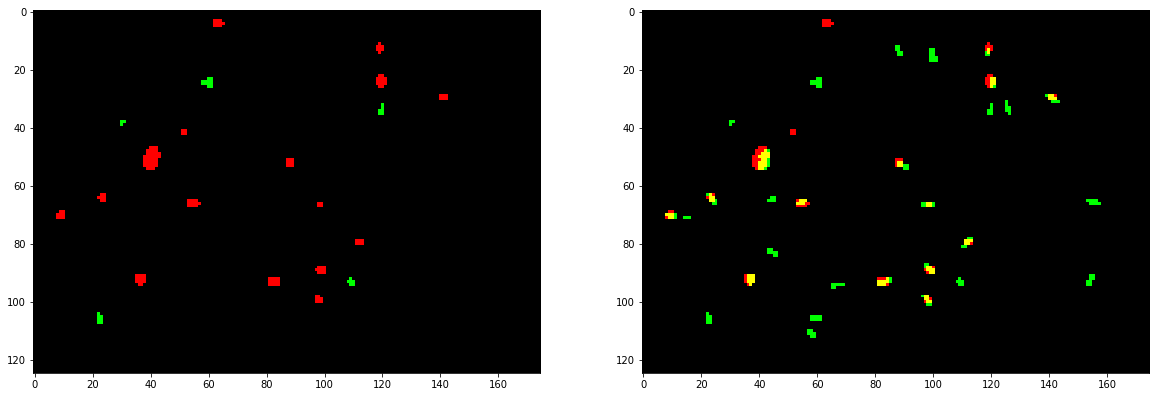

PSD95_488  at  2


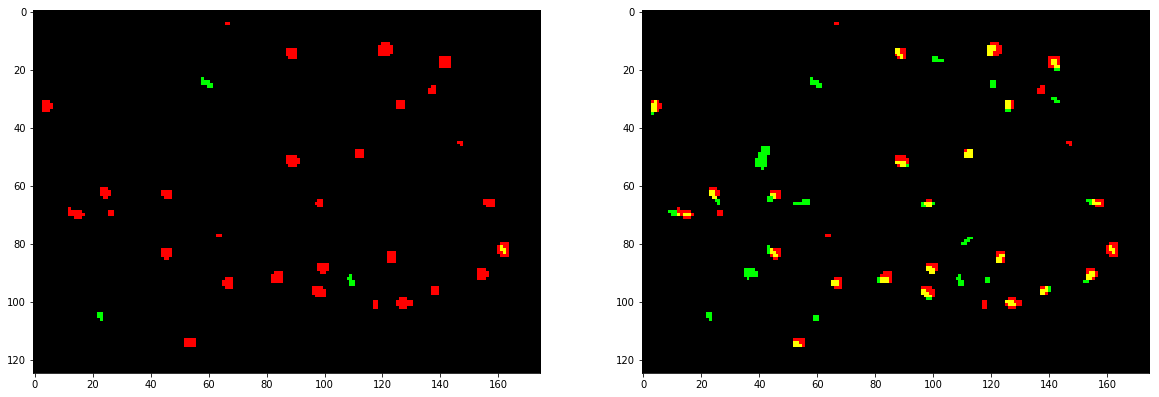

PSD95_488  at  3


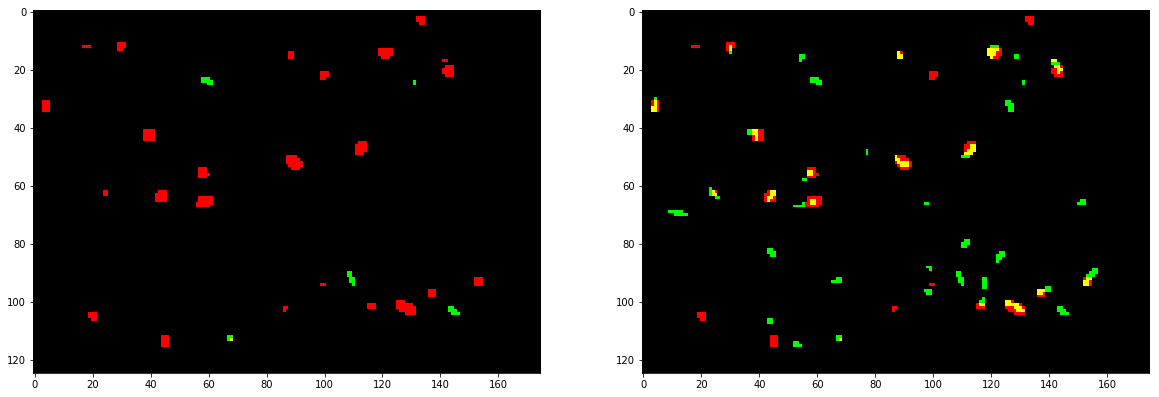

PSD95_488  at  4


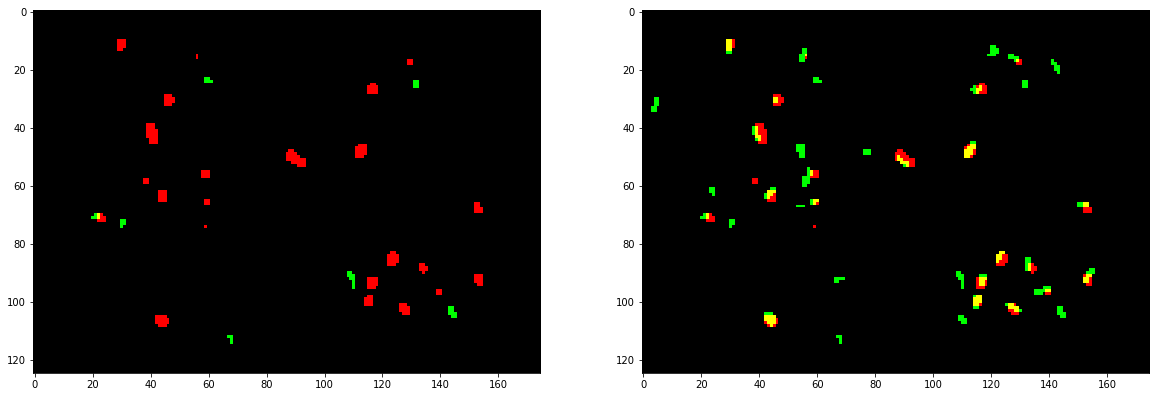

PSD95_488  at  5


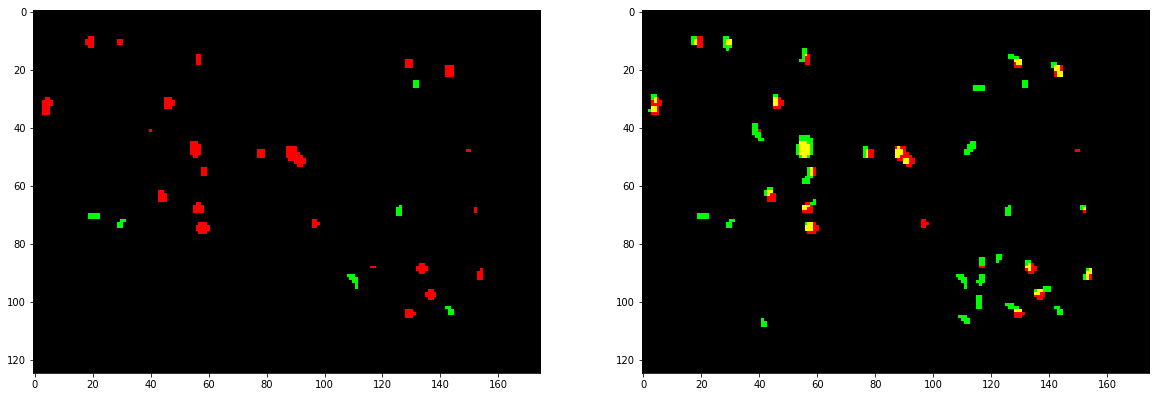

PSD95_488  at  6


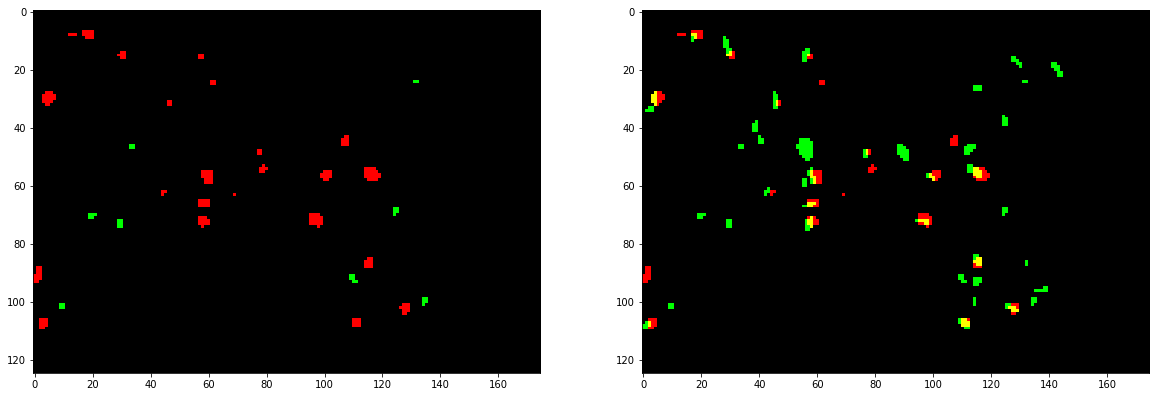

PSD95_488  at  7


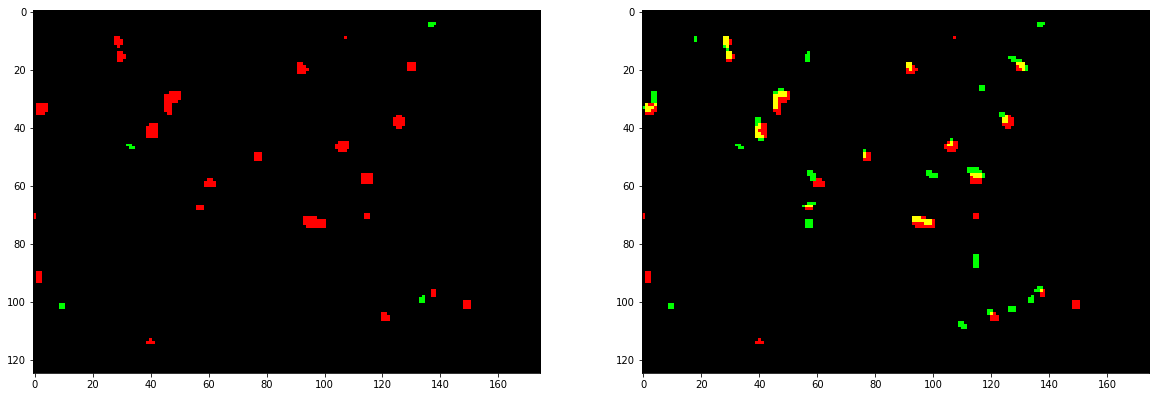

PSD95_488  at  8


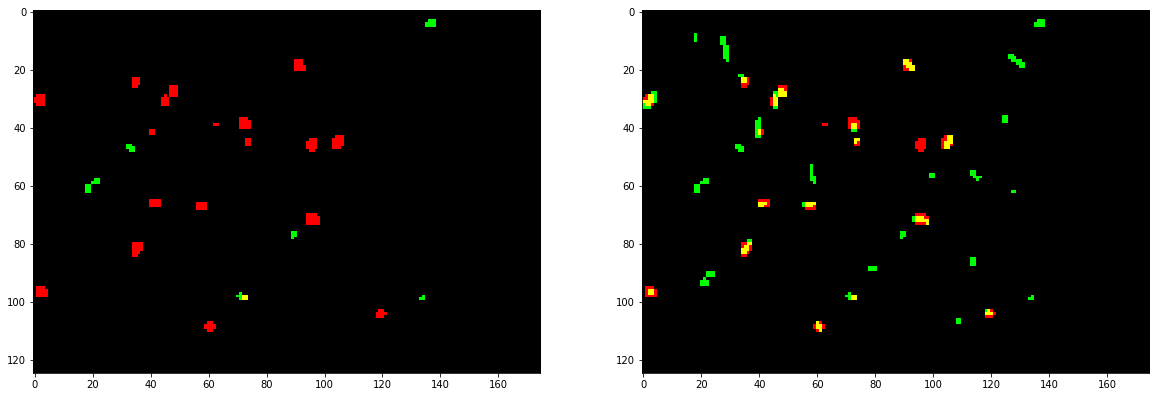

PSD95_488  at  9


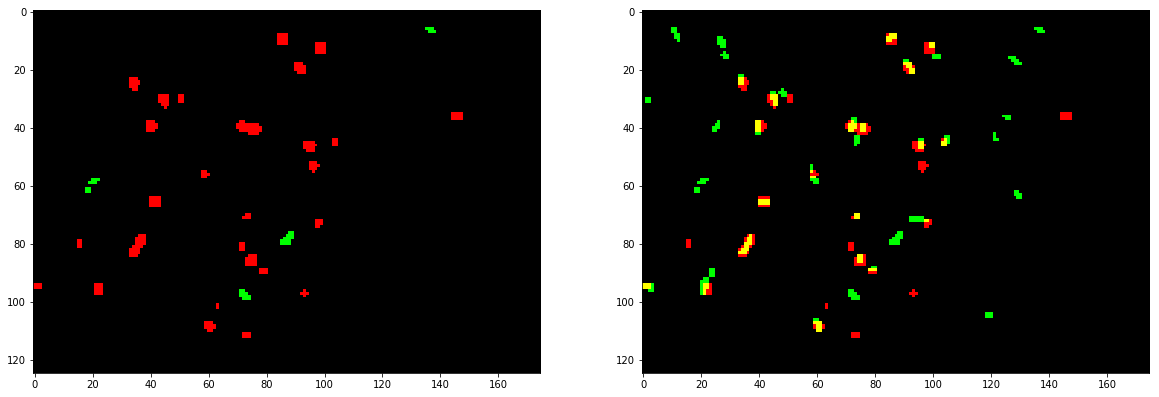

gephyrin594  at  1


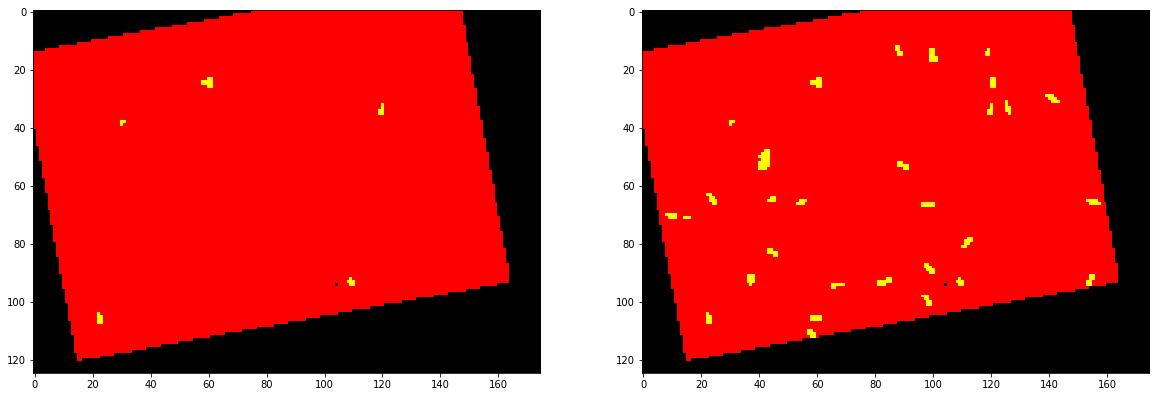

gephyrin594  at  2


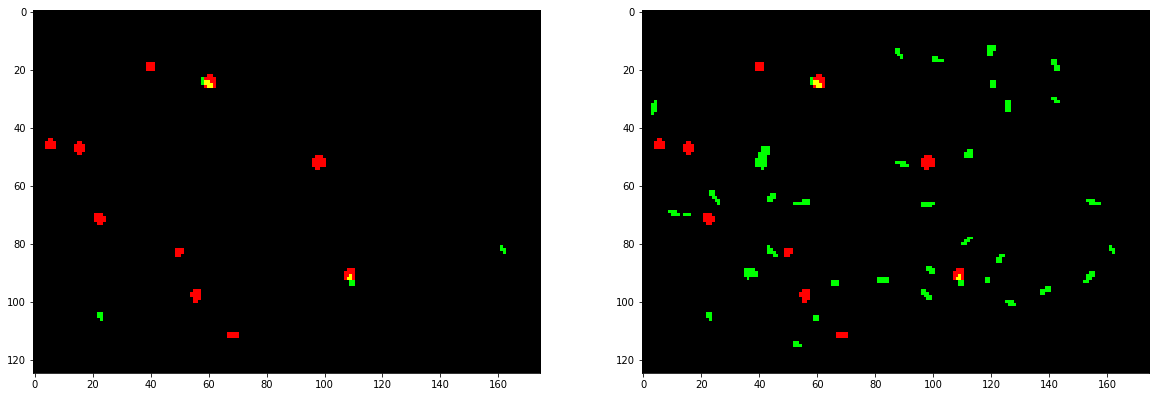

gephyrin594  at  3


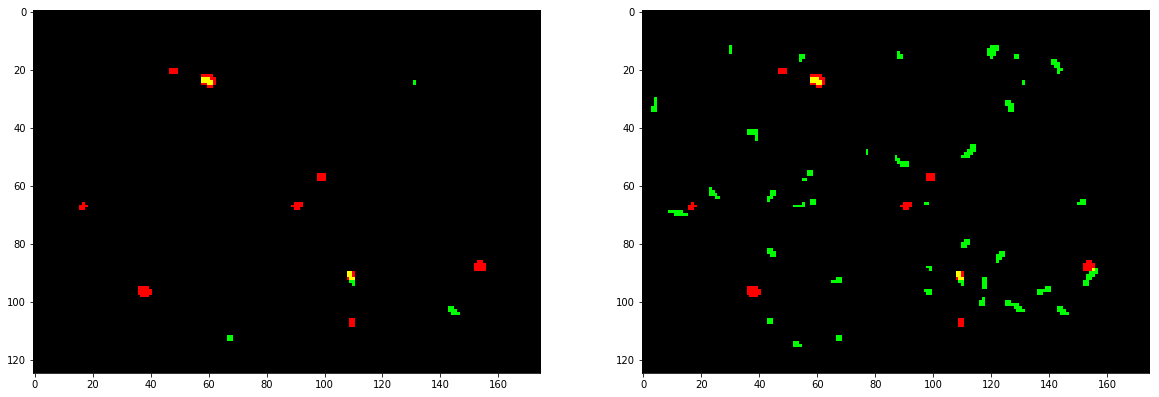

gephyrin594  at  4


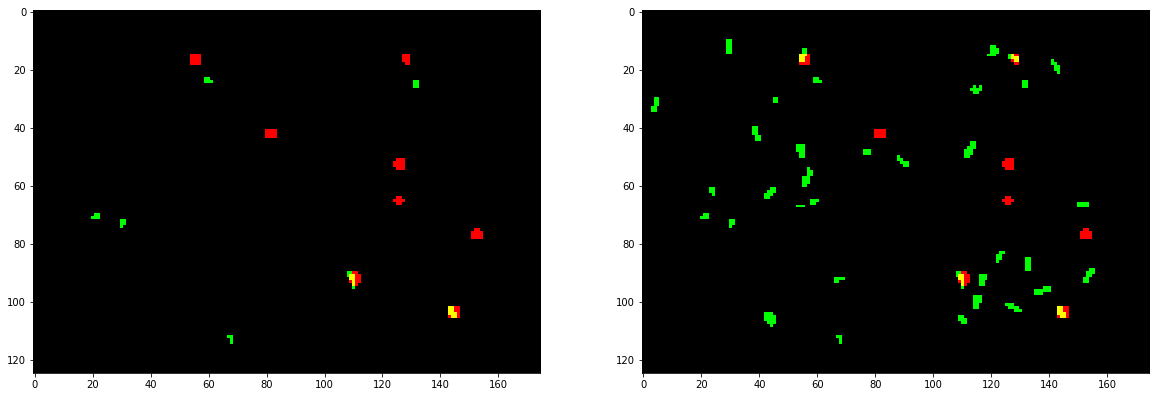

gephyrin594  at  5


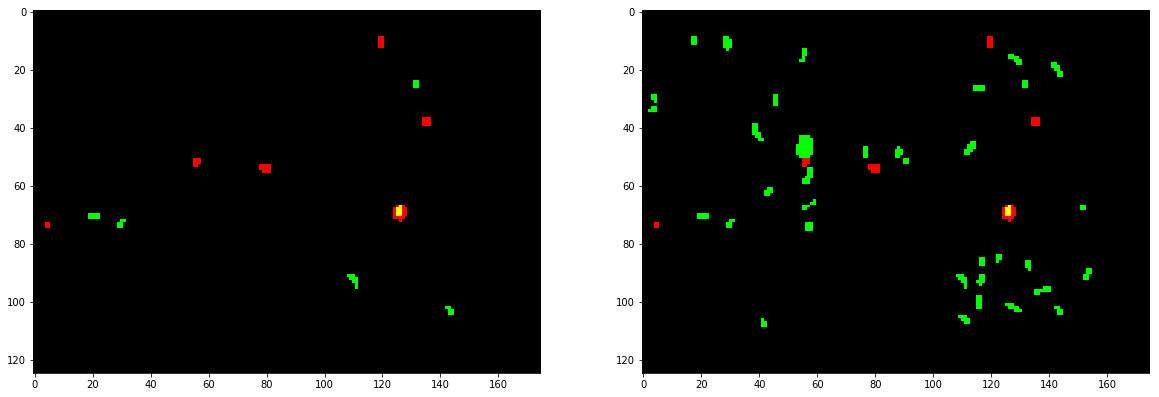

gephyrin594  at  6


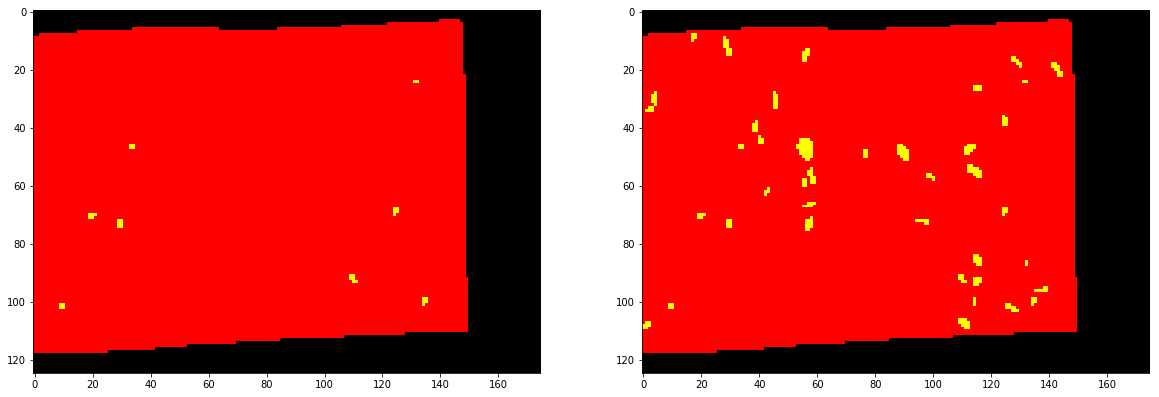

gephyrin594  at  7


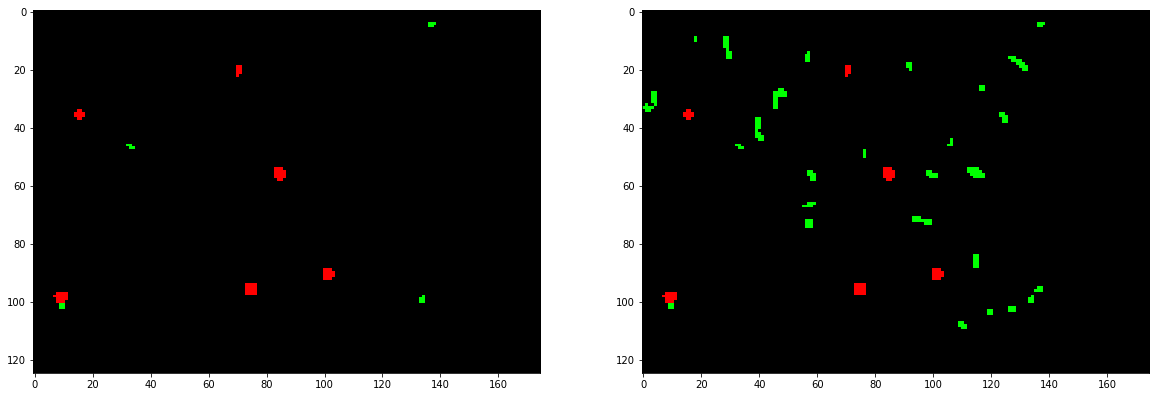

gephyrin594  at  8


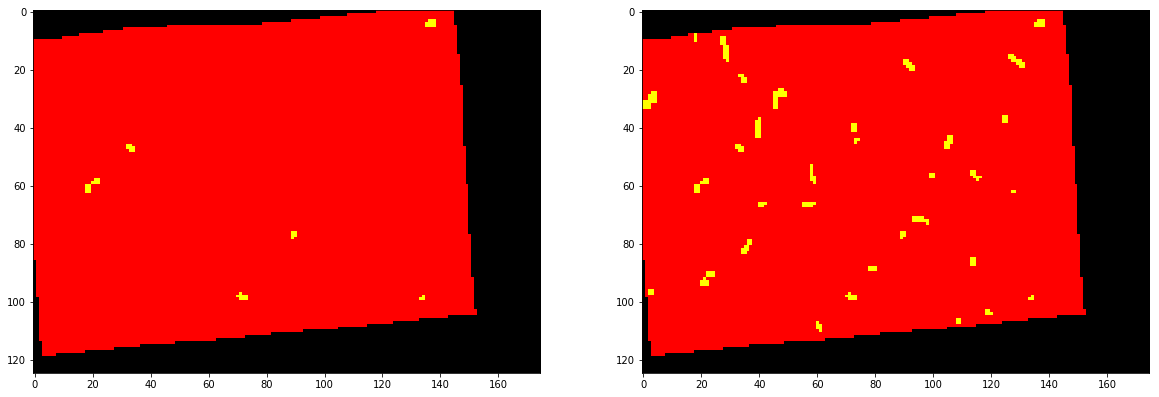

gephyrin594  at  9


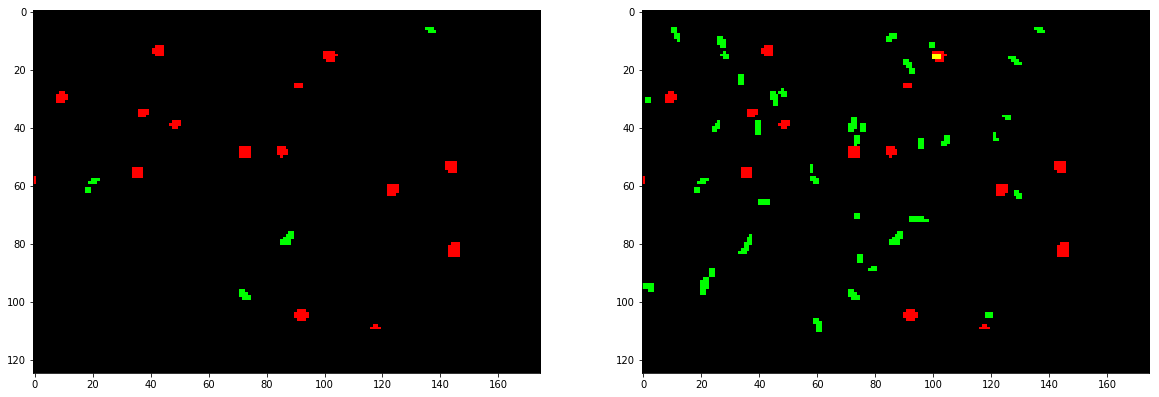

Synapsin647  at  1


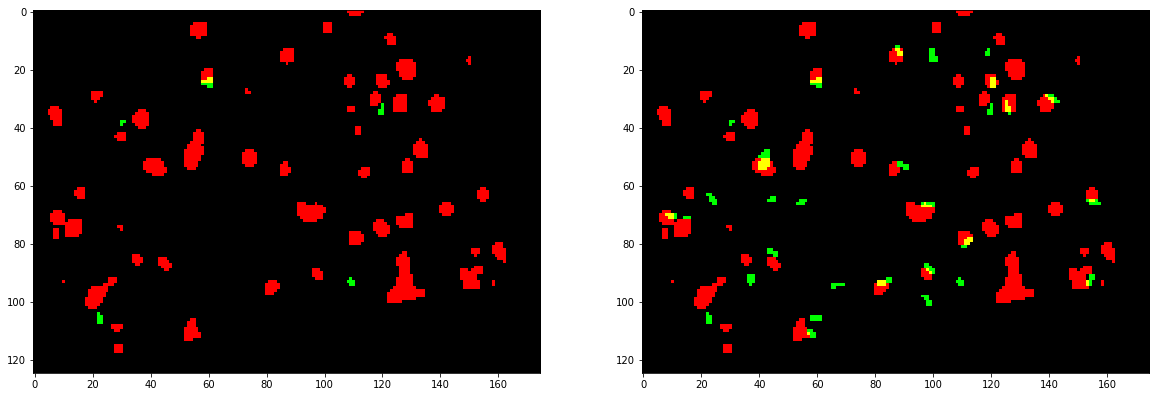

Synapsin647  at  2


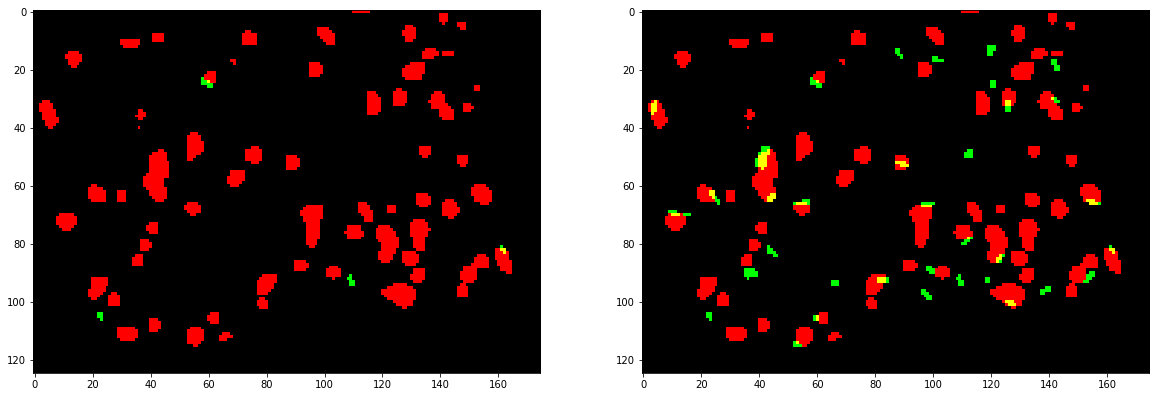

Synapsin647  at  3


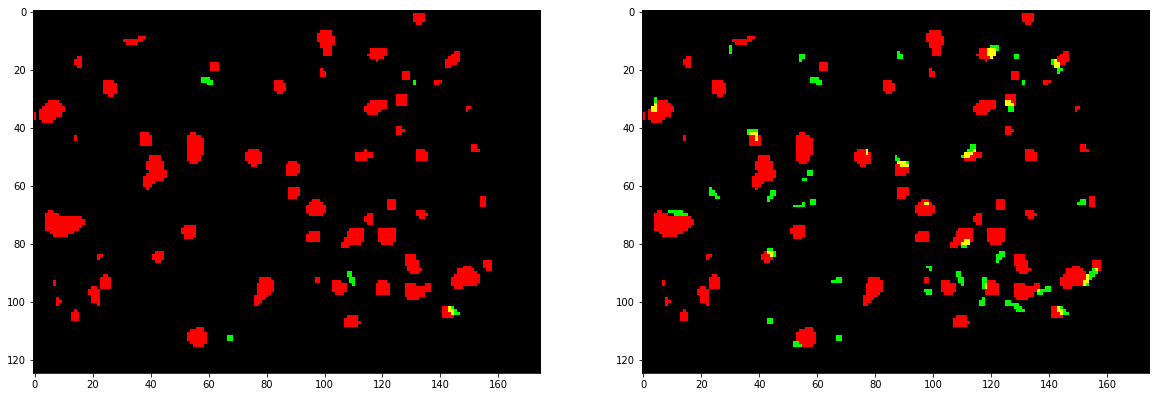

Synapsin647  at  4


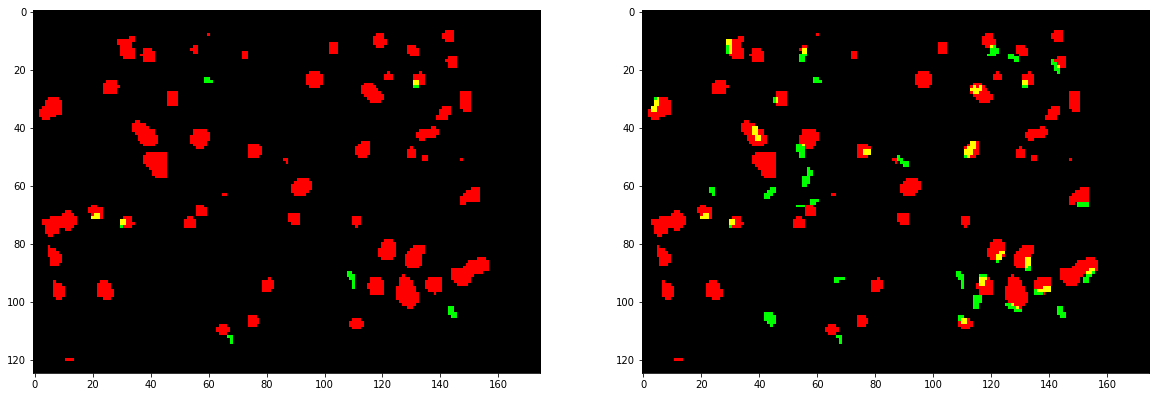

Synapsin647  at  5


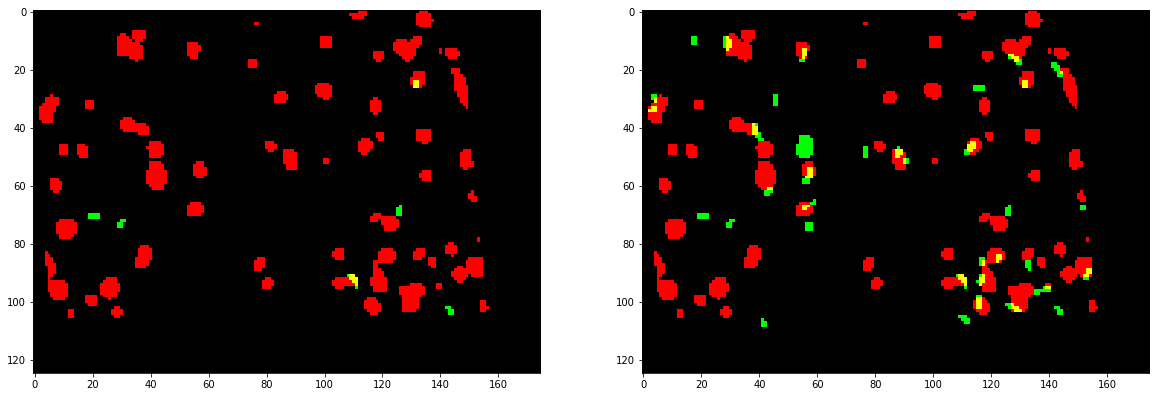

Synapsin647  at  6


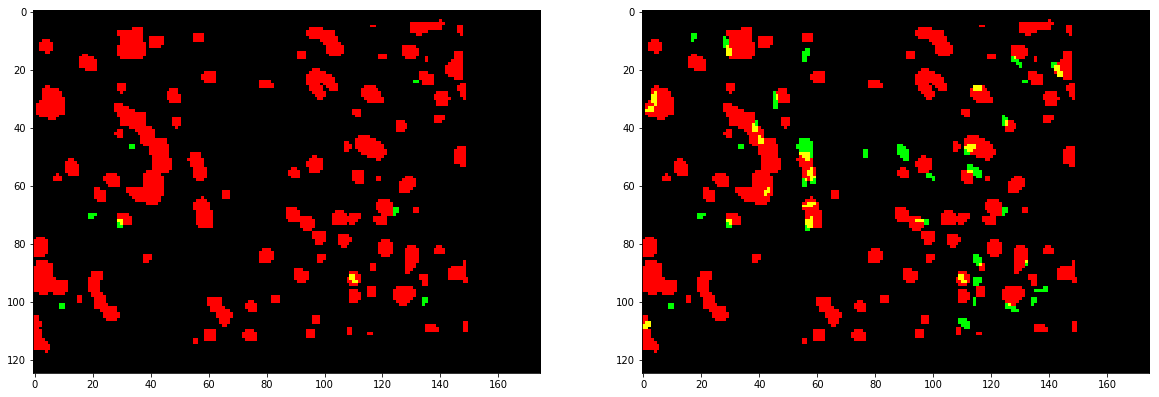

Synapsin647  at  7


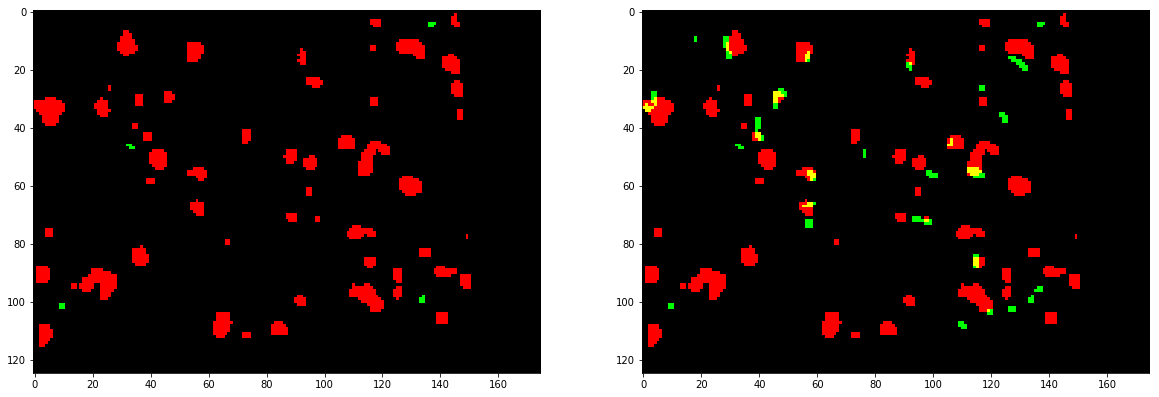

Synapsin647  at  8


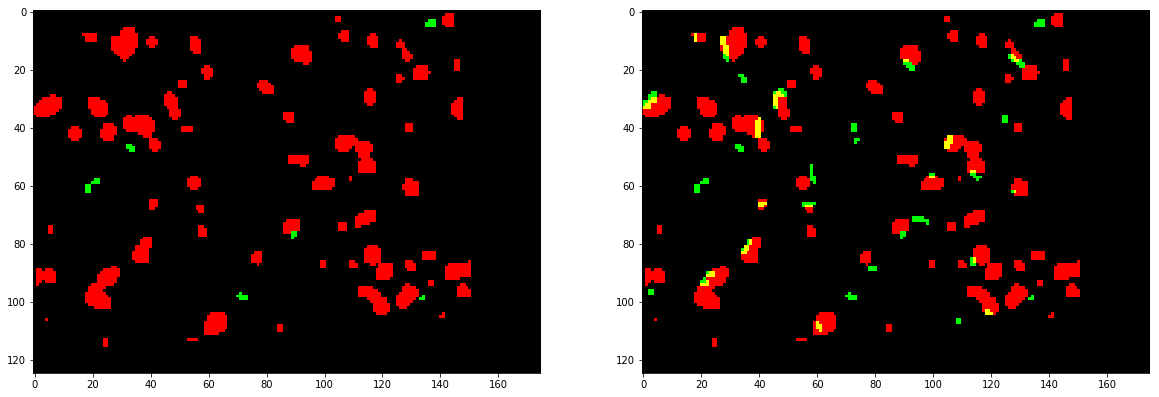

Synapsin647  at  9


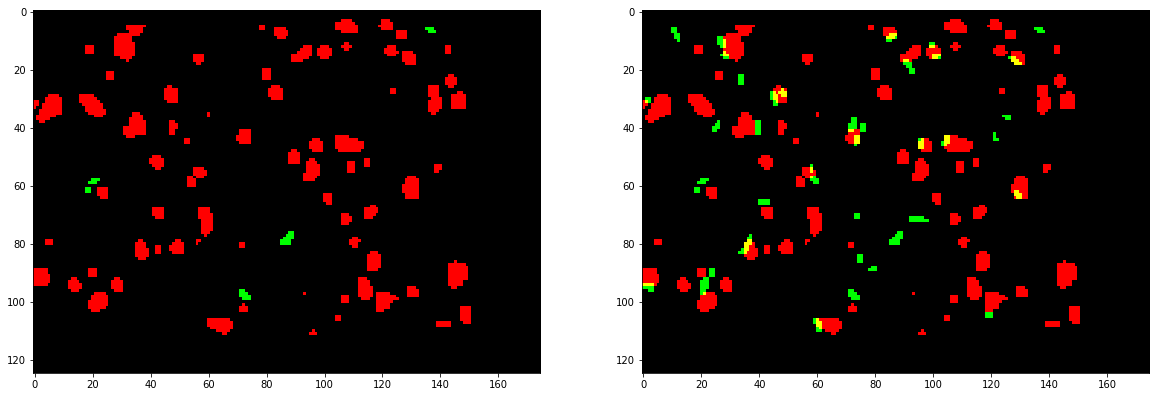

In [28]:
for key in data.keys():
    if not 'annot' in key:
        try:
            chan = np.stack(data[key]).astype(float)
            bin_chan = np.stack([elem > threshold_otsu(elem) for elem in chan])
            img = np.stack([bin_chan[z].astype(float), fn_annot[z].astype(float), np.zeros_like(bin_chan[z]).astype(float)] for z in range(bin_chan.shape[0]))
            img = np.moveaxis(img, 1, -1)

            img2 = np.stack([bin_chan[z].astype(float), annot[z].astype(float) > 0, np.zeros_like(bin_chan[z]).astype(float)] for z in range(bin_chan.shape[0]))
            img2 = np.moveaxis(img2, 1, -1)
            
            for disp_z in range(1, 10):
                print(key, ' at ', disp_z)
                plt.figure(figsize=(20, 20))
                plt.subplot(121)
                plt.imshow(img[disp_z])
                plt.subplot(122)
                plt.imshow(img2[disp_z])
                plt.show()
        except: 
            continue
        
        
        

In [29]:
data.keys()

dict_keys(['GS594', 'GABA488', 'NR1594', 'GAD647', 'annotation', 'MBP488', 'PSD95_488', 'gephyrin594', 'Synapsin647', 'VGluT1_647'])

NR vs GS594 at 1


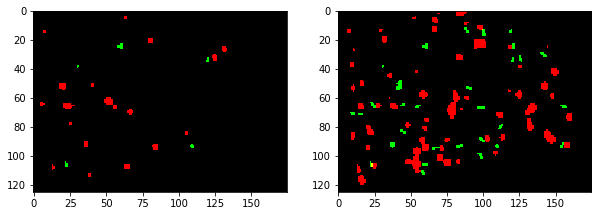

NR vs GS594 at 2


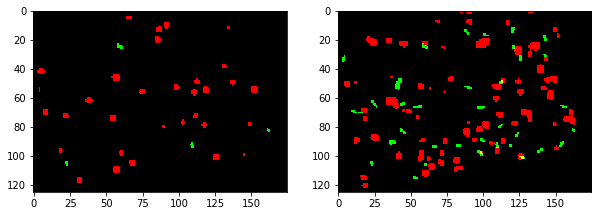

NR vs GS594 at 3


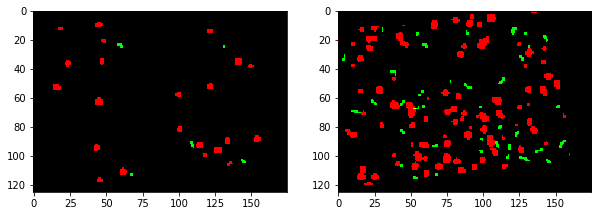

NR vs GS594 at 4


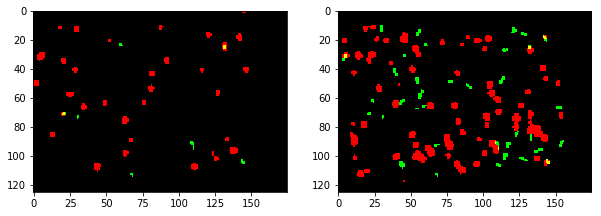

NR vs GS594 at 5


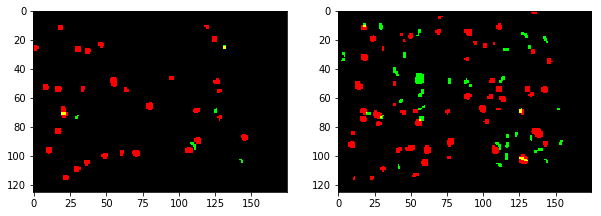

NR vs GS594 at 6


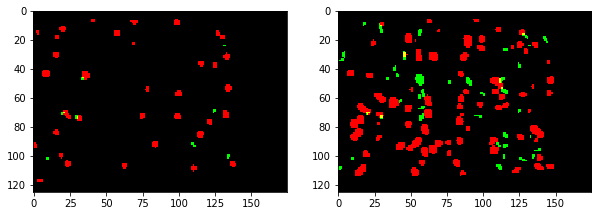

NR vs GS594 at 7


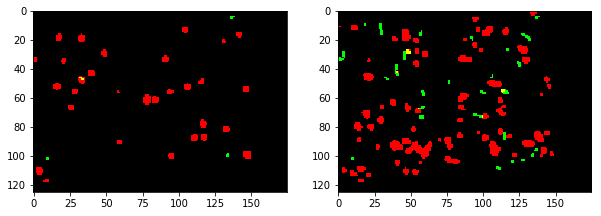

NR vs GS594 at 8


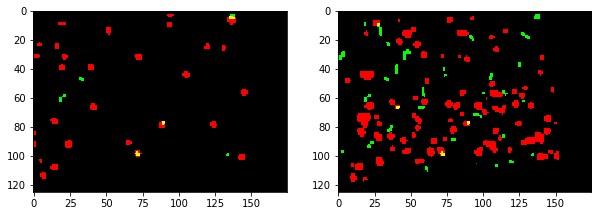

NR vs GS594 at 9


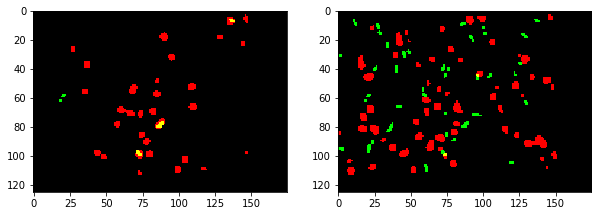

NR vs GABA488 at 1


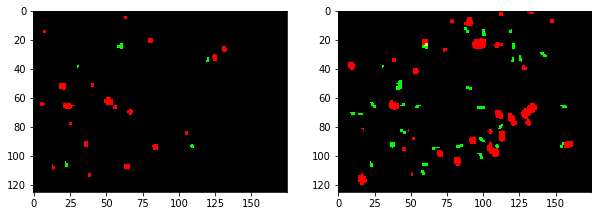

NR vs GABA488 at 2


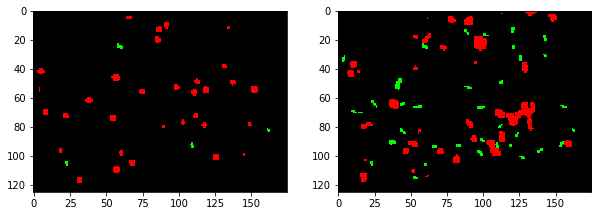

NR vs GABA488 at 3


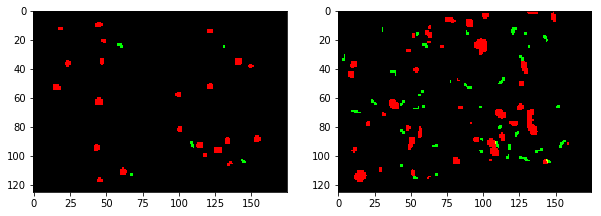

NR vs GABA488 at 4


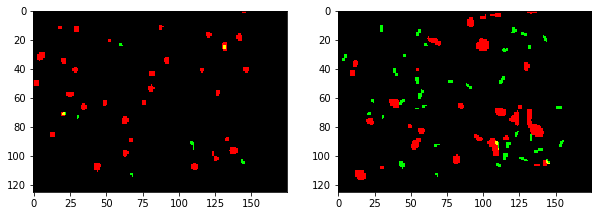

NR vs GABA488 at 5


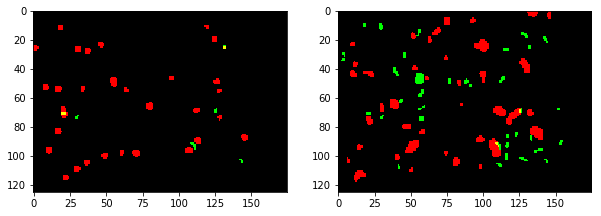

NR vs GABA488 at 6


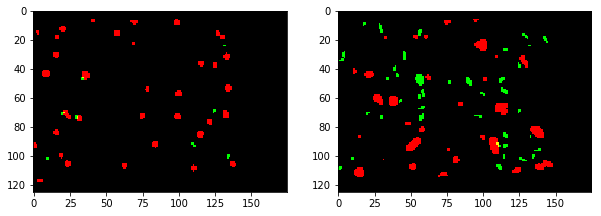

NR vs GABA488 at 7


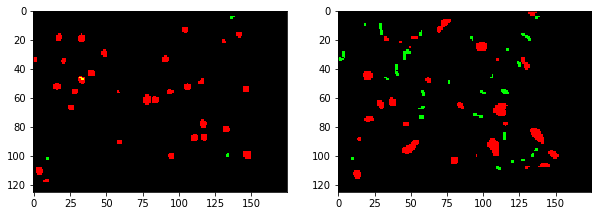

NR vs GABA488 at 8


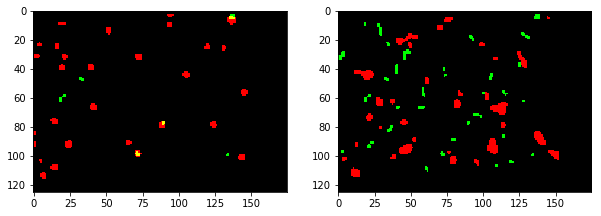

NR vs GABA488 at 9


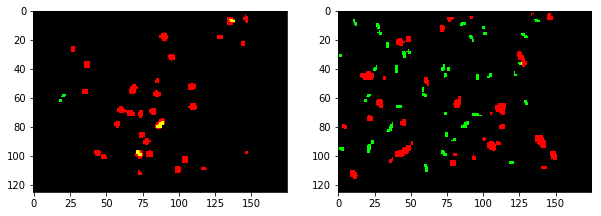

NR vs NR1594 at 1


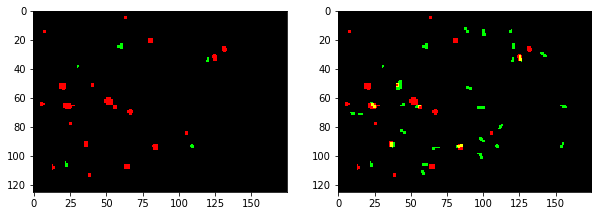

NR vs NR1594 at 2


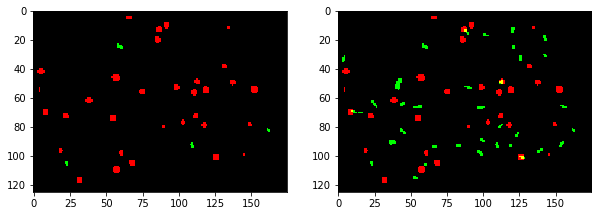

NR vs NR1594 at 3


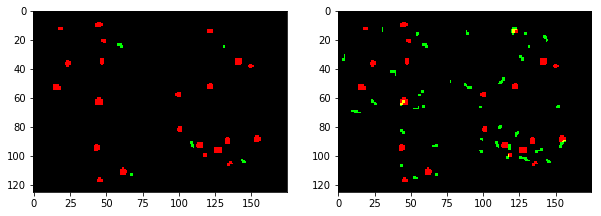

NR vs NR1594 at 4


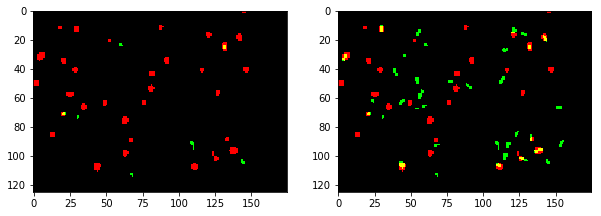

NR vs NR1594 at 5


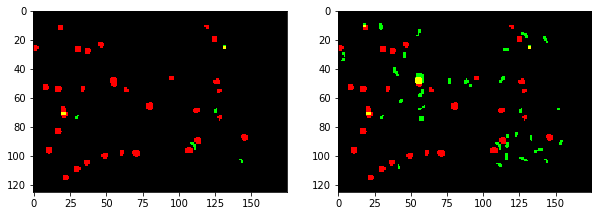

NR vs NR1594 at 6


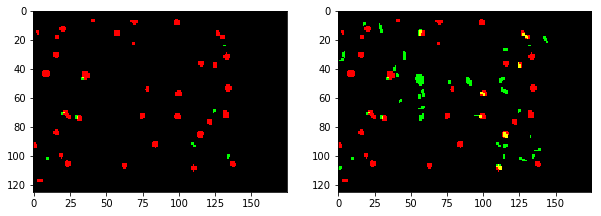

NR vs NR1594 at 7


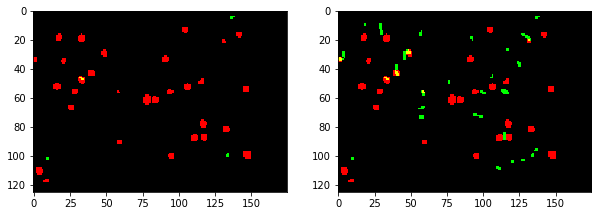

NR vs NR1594 at 8


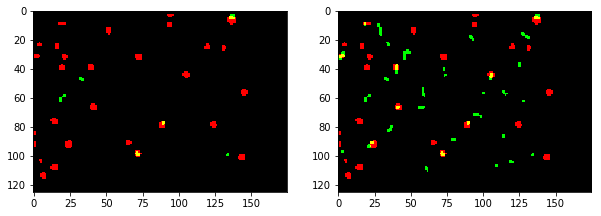

NR vs NR1594 at 9


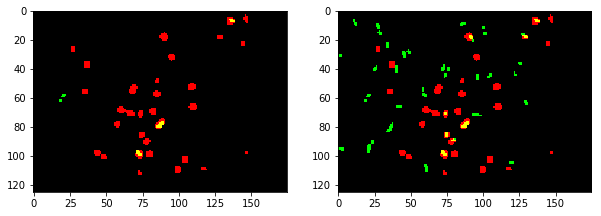

NR vs GAD647 at 1


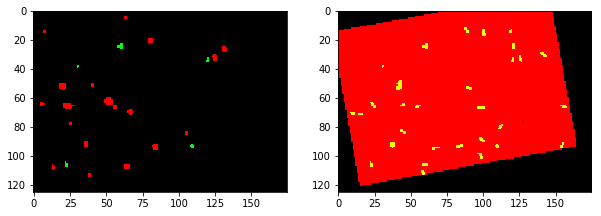

NR vs GAD647 at 2


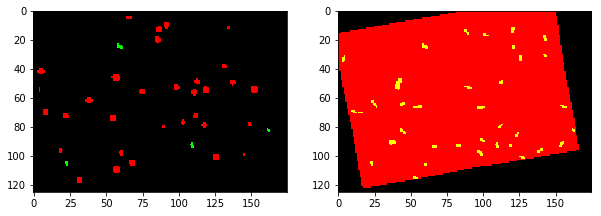

NR vs GAD647 at 3


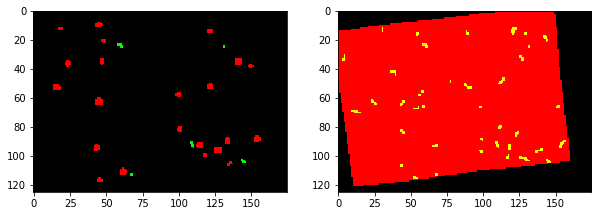

NR vs GAD647 at 4


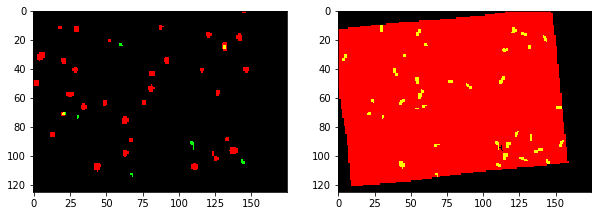

NR vs GAD647 at 5


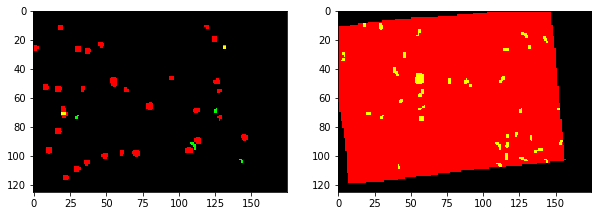

NR vs GAD647 at 6


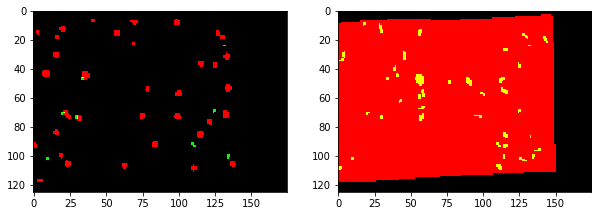

NR vs GAD647 at 7


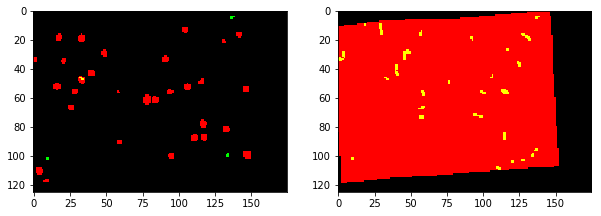

NR vs GAD647 at 8


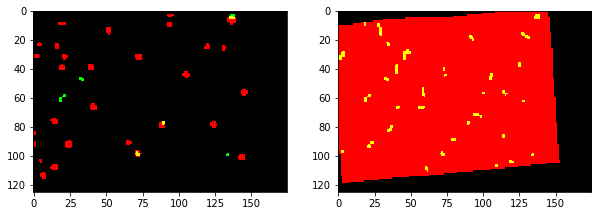

NR vs GAD647 at 9


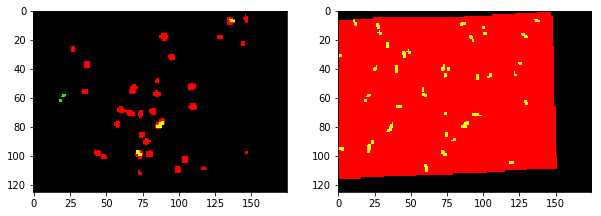

NR vs annotation at 1


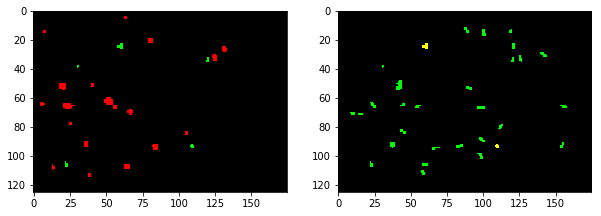

NR vs annotation at 2


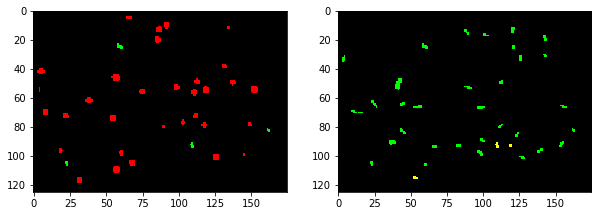

NR vs annotation at 3


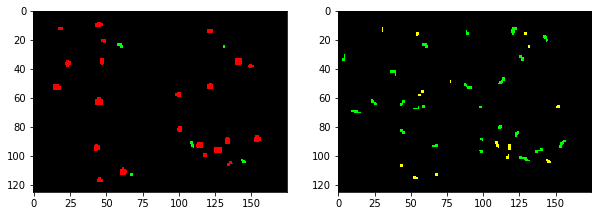

NR vs annotation at 4


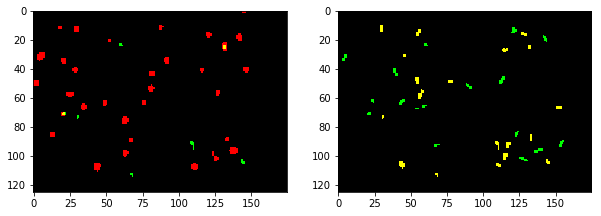

NR vs annotation at 5


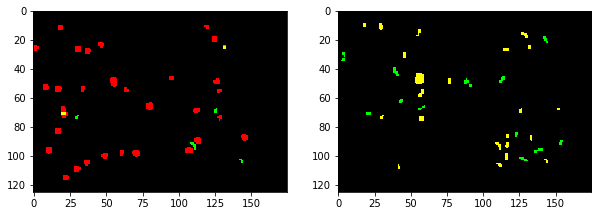

NR vs annotation at 6


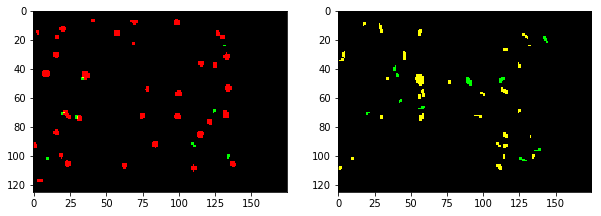

NR vs annotation at 7


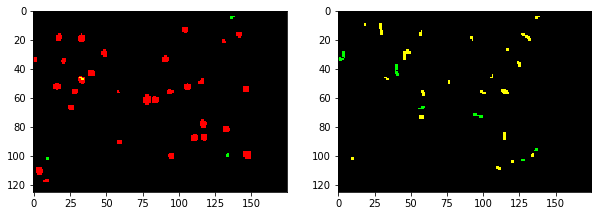

NR vs annotation at 8


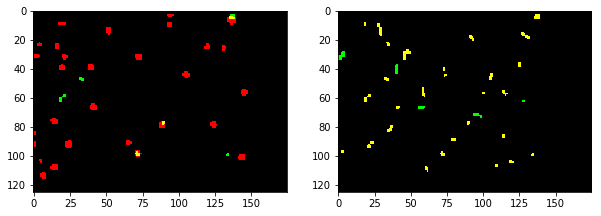

NR vs annotation at 9


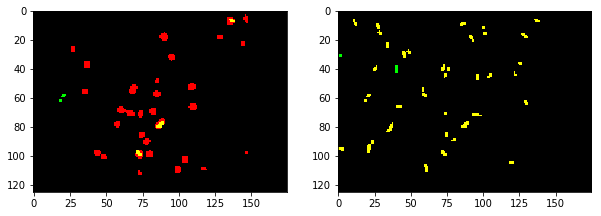

NR vs MBP488 at 1


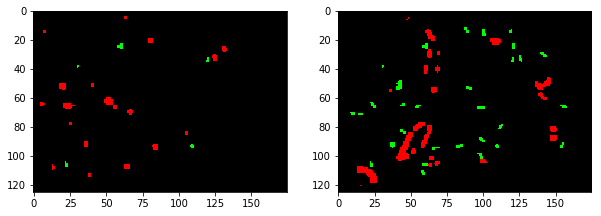

NR vs MBP488 at 2


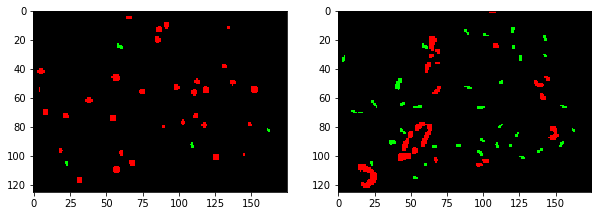

NR vs MBP488 at 3


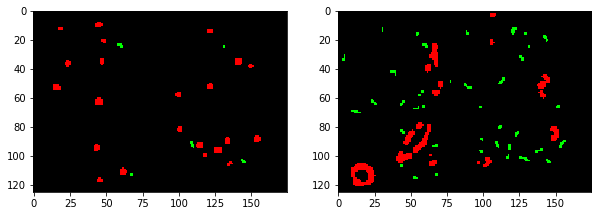

NR vs MBP488 at 4


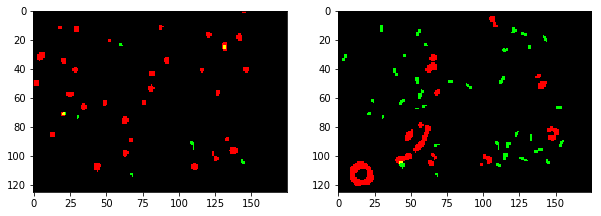

NR vs MBP488 at 5


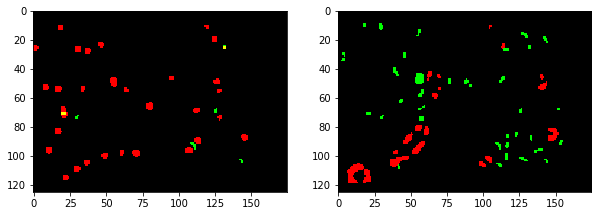

NR vs MBP488 at 6


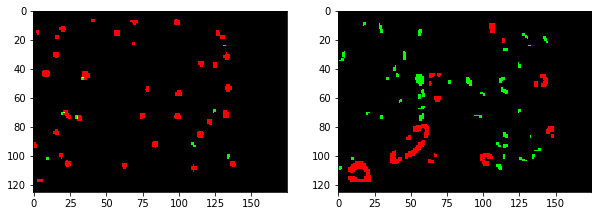

NR vs MBP488 at 7


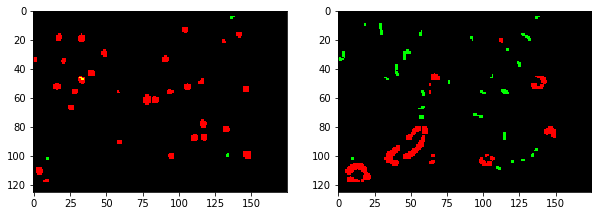

NR vs MBP488 at 8


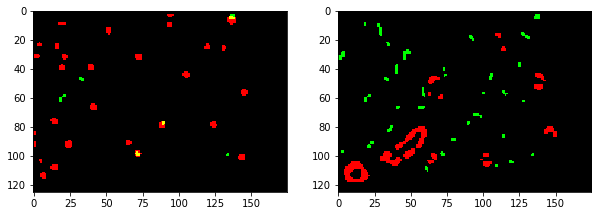

NR vs MBP488 at 9


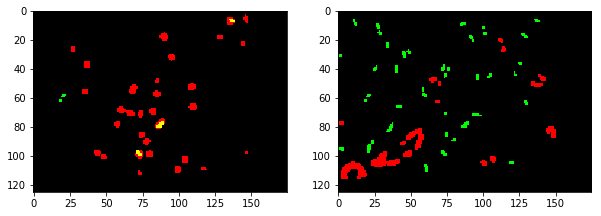

NR vs PSD95_488 at 1


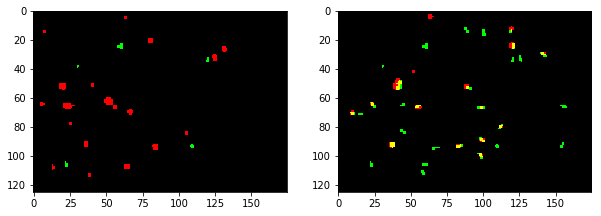

NR vs PSD95_488 at 2


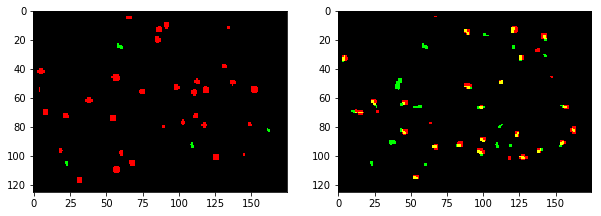

NR vs PSD95_488 at 3


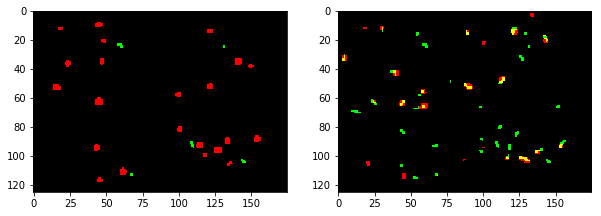

NR vs PSD95_488 at 4


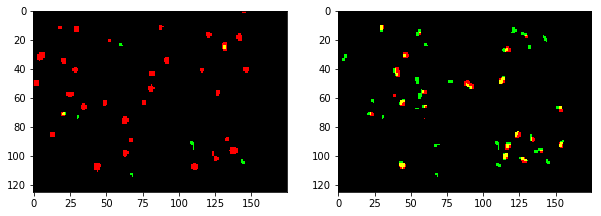

NR vs PSD95_488 at 5


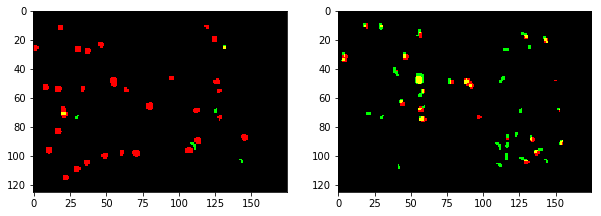

NR vs PSD95_488 at 6


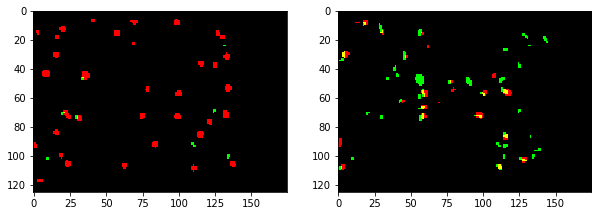

NR vs PSD95_488 at 7


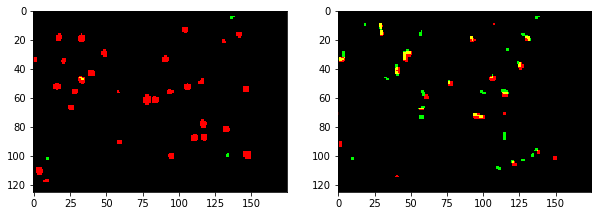

NR vs PSD95_488 at 8


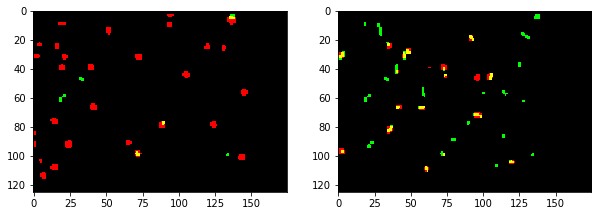

NR vs PSD95_488 at 9


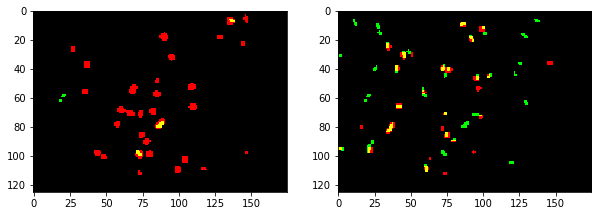

NR vs gephyrin594 at 1


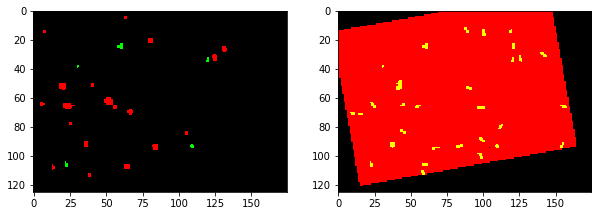

NR vs gephyrin594 at 2


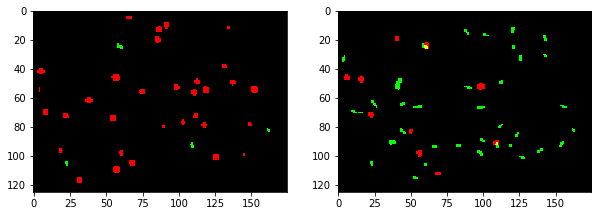

NR vs gephyrin594 at 3


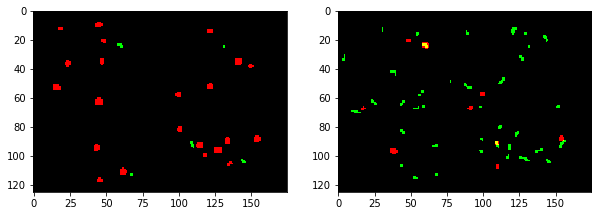

NR vs gephyrin594 at 4


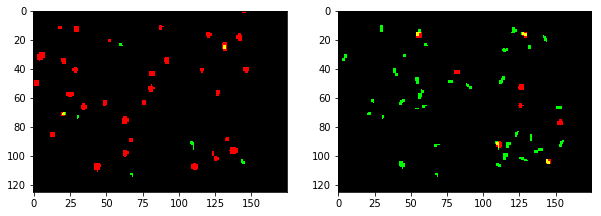

NR vs gephyrin594 at 5


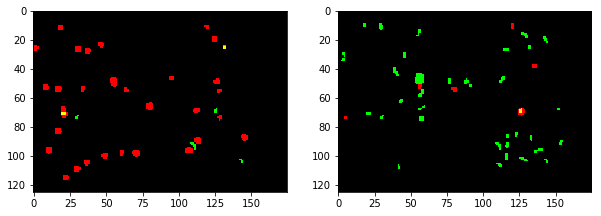

NR vs gephyrin594 at 6


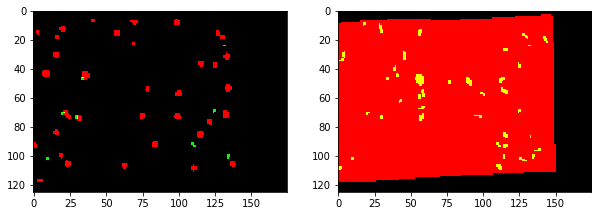

NR vs gephyrin594 at 7


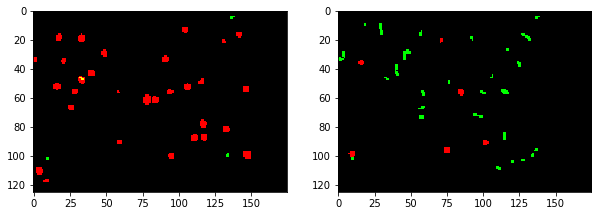

NR vs gephyrin594 at 8


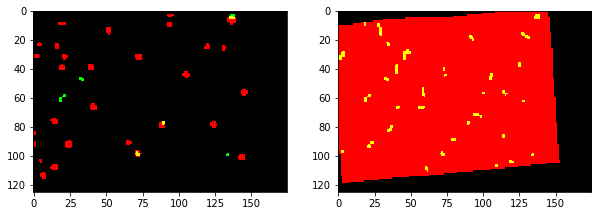

NR vs gephyrin594 at 9


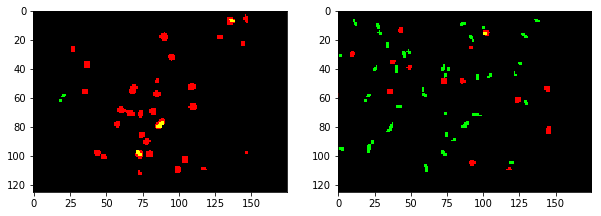

NR vs Synapsin647 at 1


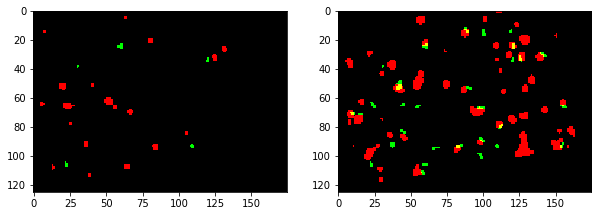

NR vs Synapsin647 at 2


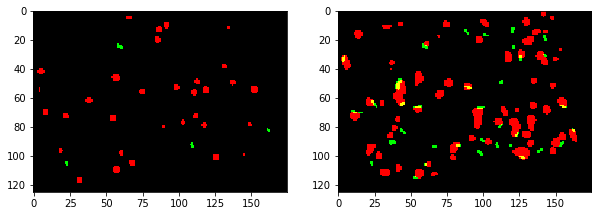

NR vs Synapsin647 at 3


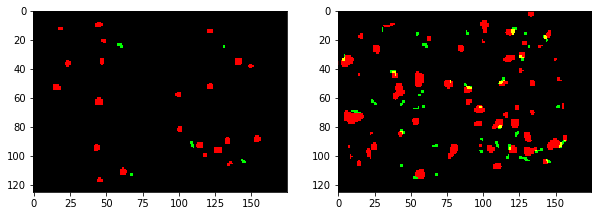

NR vs Synapsin647 at 4


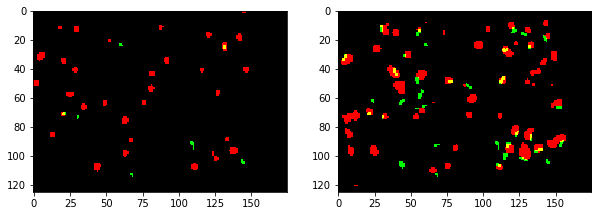

NR vs Synapsin647 at 5


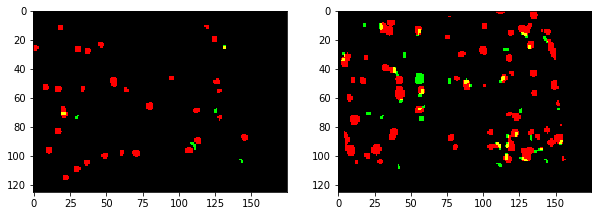

NR vs Synapsin647 at 6


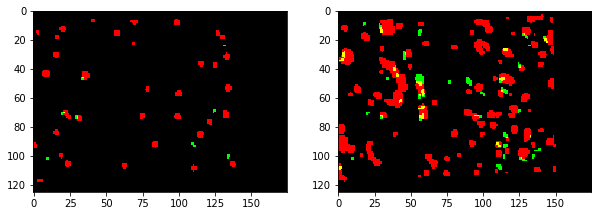

NR vs Synapsin647 at 7


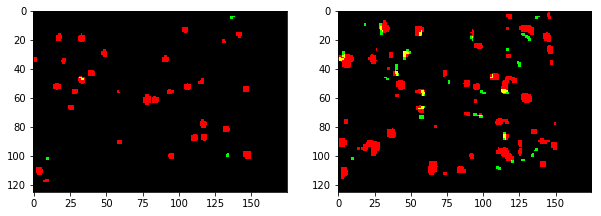

NR vs Synapsin647 at 8


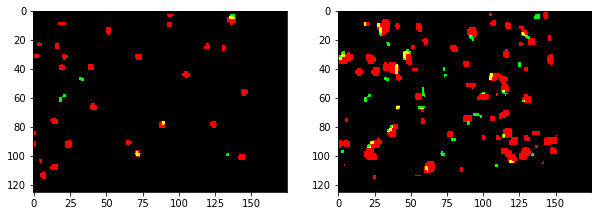

NR vs Synapsin647 at 9


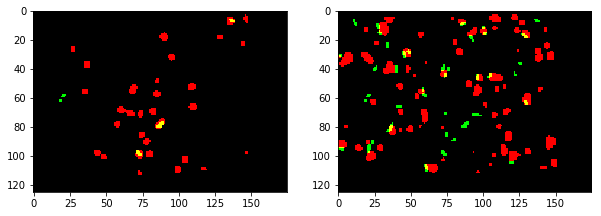

In [30]:
chan = np.stack(data['NR1594']).astype(float)
annot = annot.astype(int)
bin_annot = np.stack([elem > 0 for elem in annot])
bin_chan = np.stack([elem > threshold_otsu(elem) for elem in chan])
img = np.stack([bin_chan[z].astype(float), fn_annot[z].astype(float), np.zeros_like(bin_chan[z]).astype(float)] for z in range(bin_chan.shape[0]))
img = np.moveaxis(img, 1, -1)

for key in data.keys():
    if not 'annnot' in key:
        try:
            chan2 = np.stack(data[key]).astype(float)
            bin_chan2 = np.stack([elem > threshold_otsu(elem) for elem in chan2])
            img2 = np.stack([bin_chan2[z].astype(float), bin_annot[z].astype(float), np.zeros_like(bin_chan[z]).astype(float)] for z in range(bin_chan.shape[0]))
            img2 = np.moveaxis(img2, 1, -1)

            for disp_z in range(1, 10):
                plt.figure(figsize=(10, 10))
                print('NR vs ' + str(key) + ' at ' + str(disp_z))
                plt.subplot(121)
                plt.imshow(img[disp_z])
                plt.subplot(122)
                plt.imshow(img2[disp_z])
                plt.show()
        except:
            continue
        

In [31]:
data.keys()

dict_keys(['GS594', 'GABA488', 'NR1594', 'GAD647', 'annotation', 'MBP488', 'PSD95_488', 'gephyrin594', 'Synapsin647', 'VGluT1_647'])

In [32]:
feature_map = compute_convolutional_triv(np.stack(data['Synapsin647']).astype(float),
                                         np.stack(data['GS594']).astype(float),
                                         np.stack(data['NR1594']).astype(float),
                                         (3, 3, 3))

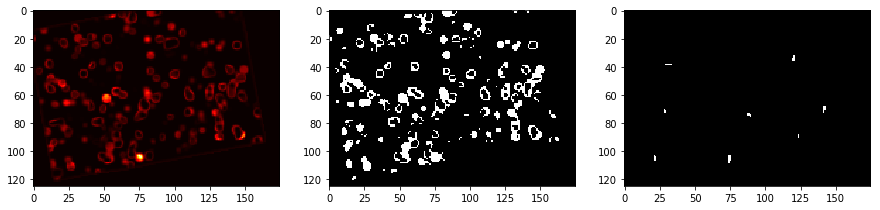

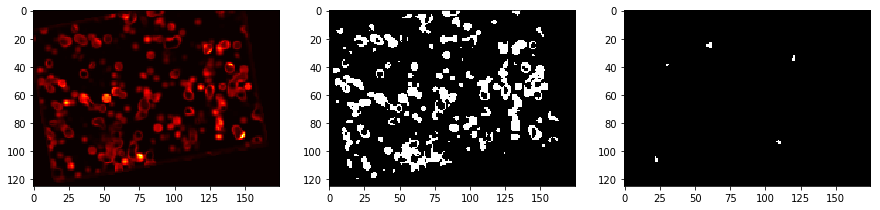

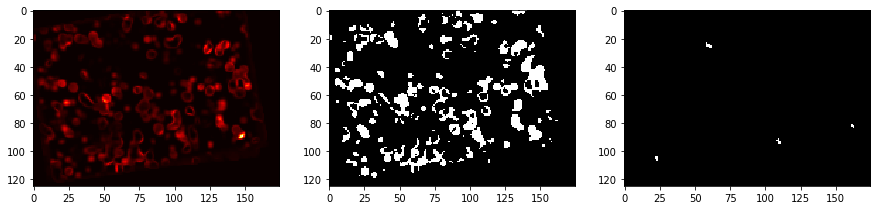

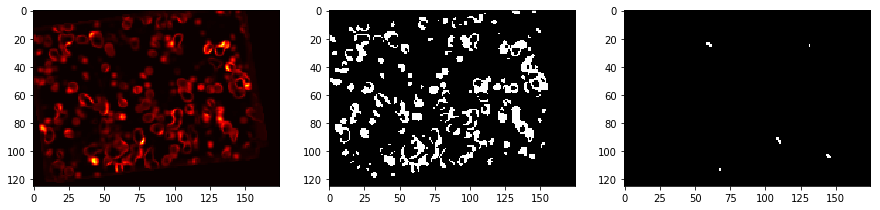

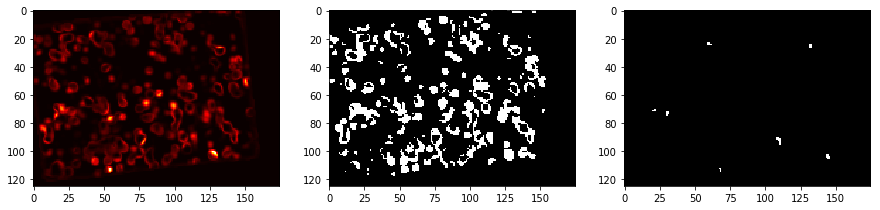

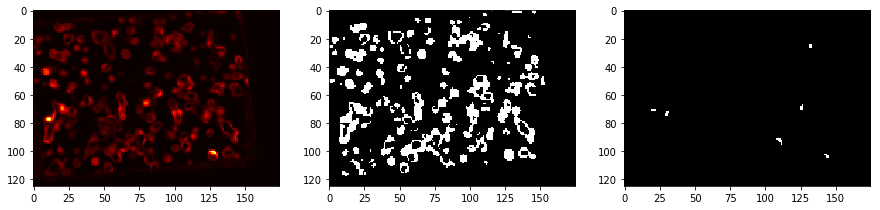

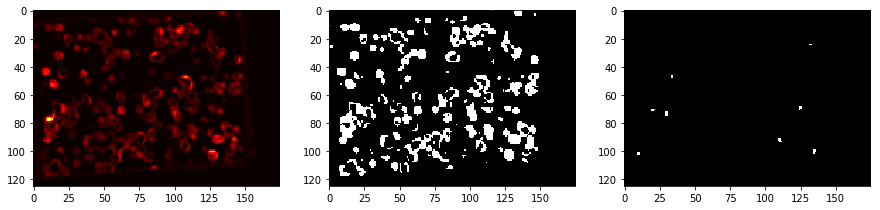

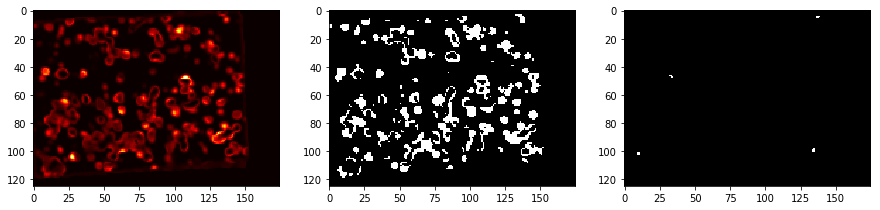

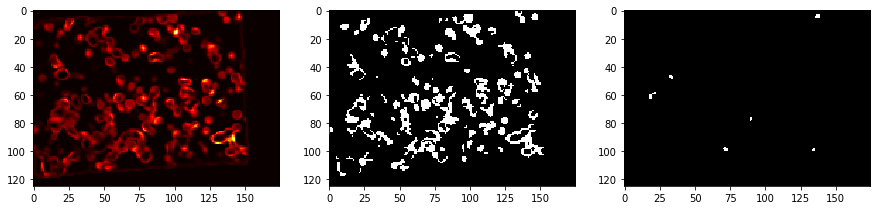

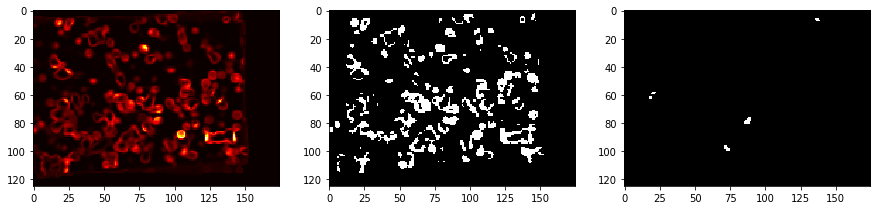

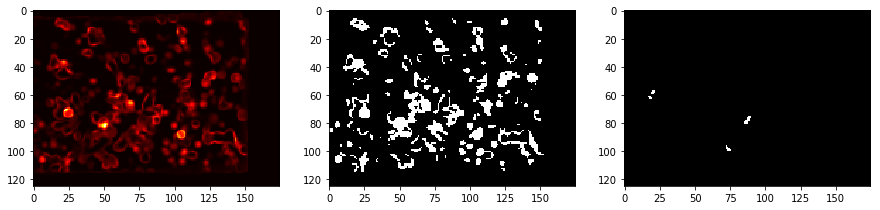

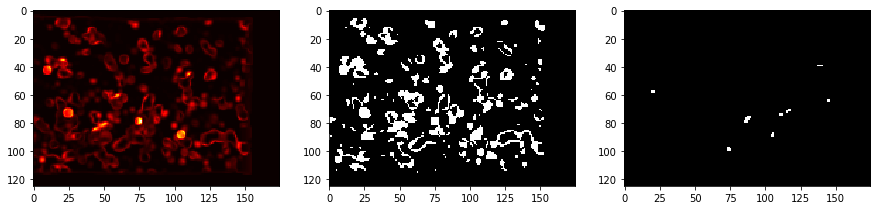

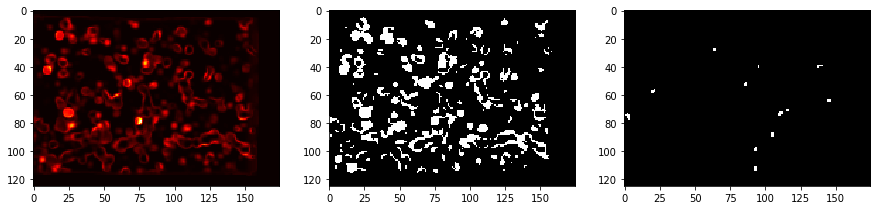

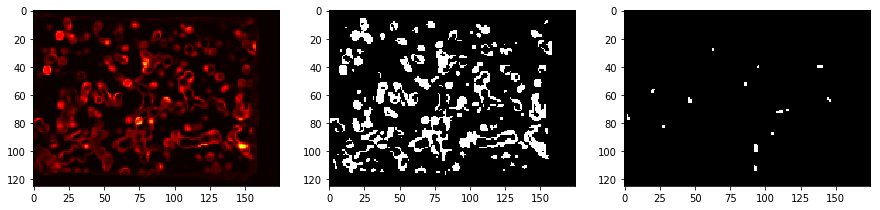

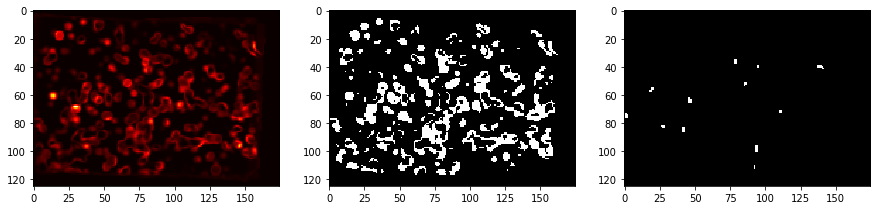

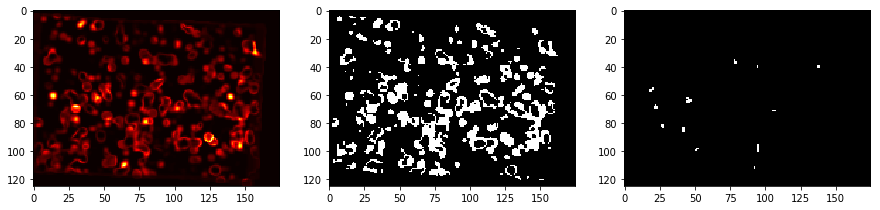

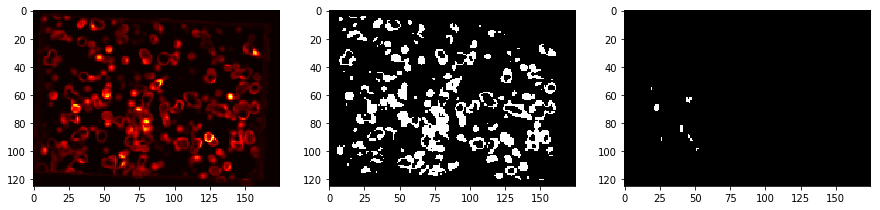

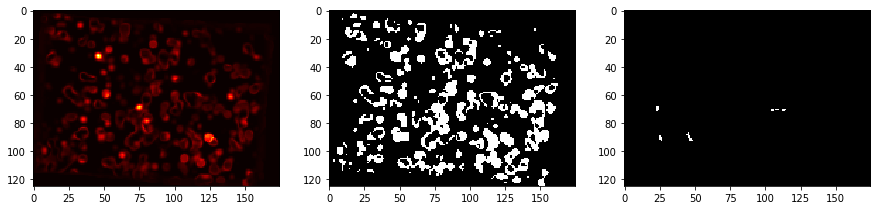

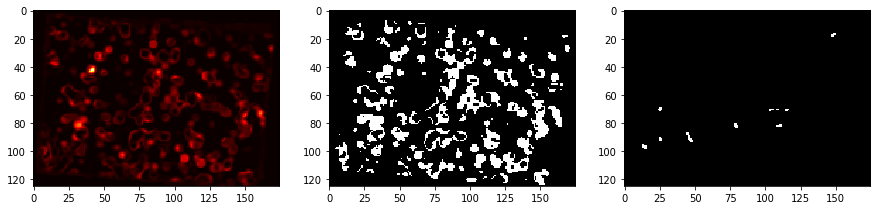

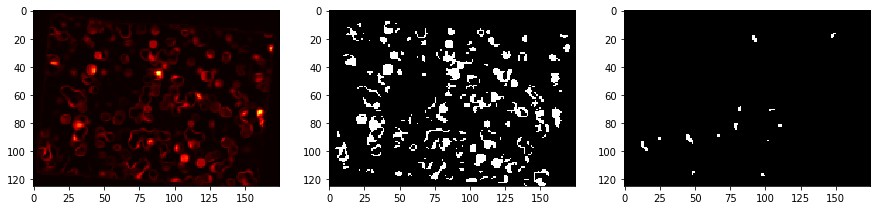

In [33]:
bin_map = feature_map > threshold_otsu(feature_map)
for display_z in range(feature_map.shape[0]):
    plt.figure(figsize=(15, 15))
    plt.subplot(131)
    plt.imshow(feature_map[display_z], cmap='hot')
    plt.subplot(132)
    plt.imshow(bin_map[display_z], cmap='gray')
    plt.subplot(133)
    plt.imshow(fn_annot[display_z] > 0, cmap='gray')
    plt.show()

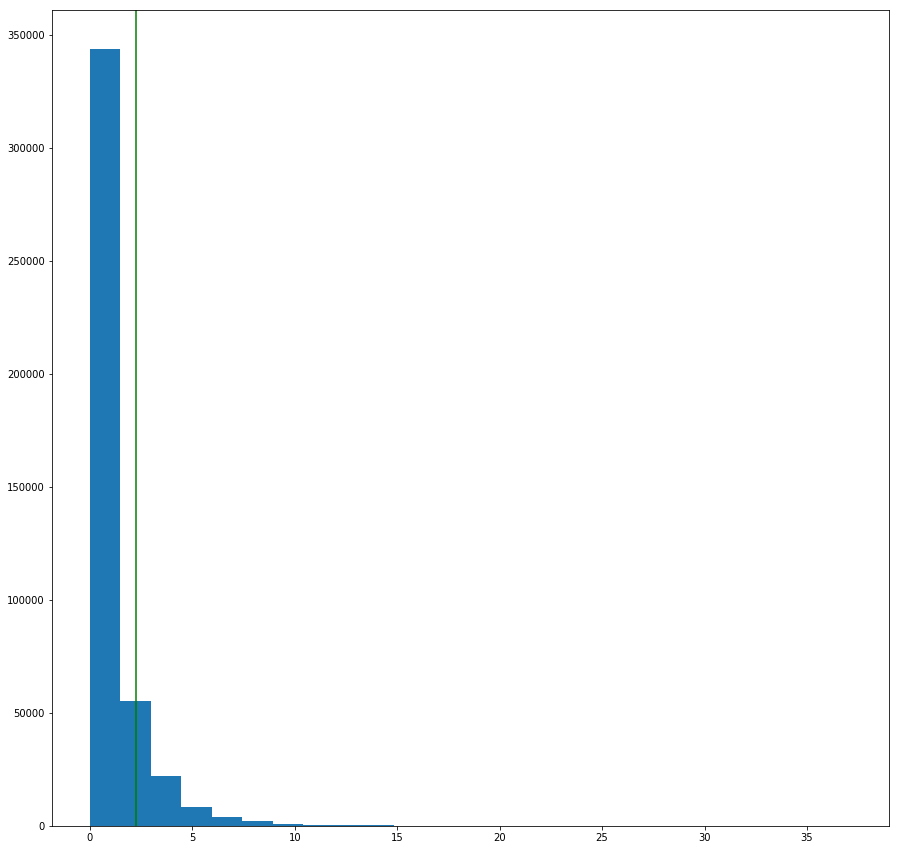

In [34]:
plt.figure(figsize=(15, 15))
plt.hist(feature_map.flatten(), bins=25)
plt.axvline(x = threshold_otsu(feature_map), c='g')
plt.show()